In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [2]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Logged In Users Pre and Post  User Menu Deployment Analysis

**Jennifer Wang, Staff Data Scientist, Wikimedia Foundation**

**28 October 2021**  
**24 January 2022**  
**3 February 2022**  
**11 February 2022**  
**15 February 2022**

[TICKET](https://phabricator.wikimedia.org/T289574)

# Table of Contents
1. [Introduction](#Introduction)
2. [Purpose](#Purpose)
3. [Methodology](#Methodology)
4. [Trend of User Link Clicks](#Trend-of-User-Link-Clicks)
5. [Comparison of Pre and Post Deployment](#Comparison-of-Pre-and-Post-Deployment)
6. [Pattern by edit buckets](#Pattern0-by-edit-buckets)

# Introduction
As a part of the [Desktop Improvements project](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements), The Wikimedia Foundation's [Web team](https://www.mediawiki.org/wiki/Readers/Web/Team) is introducing a new way to display the user tools found at the top of the page. The original user tools appear as links at the top of the page. The new solution reorganized the tools under a single menu that will allow users easy access to their user tools and make the navigation more intuitive by visually highlighting the structure of user links and their purpose. You can find more information on this change and other feature deployments on the [User menu project page](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements/Features/User_menu).

User menu is deployed on logged-in users with new skin version on all early adopter wikis in August 10,  2021.  This report details the analysis and results for the deployment of user menu on logged-in users.

Polit wikis are:  
        - French Wikitionary (frwiktionary)   
        - Hebrew Wikipedia (hewiki)    
        - Portuguese Wikiversity (ptwikiversity)   
        - French Wikipedia (frwiki)     
        - Basque Wikipedia (euwiki)  
        - Persian Wikipedia (fawiki)  
        - Portuguese Wikipedia (ptwiki)  
        - Korean Wikipedia (kowiki)  
        - Turkish Wikipedia (trwiki)  
        - Serbian Wikipedia (srwiki)  
        - Bengali Wikipedia (bnwiki)  
        - German Wikivoyage (dewikivoyage)  
        - Venetian Wikipedia (vecwiki)  
        - Wikimedia Incubator (incubatorwiki)  

__New feature -- user tools under user menu__
<img src="Figures/new.png" width="600" height="400" align="center"/>

__Old feature -- user tools without user menu__

<img src="Figures/old.png" width="600" height="360" align="center"/>

# Purpose

The goal of the pre-post analysis is to identify any changes in user behavior that might have resulted from the deployment of the user menu feature. Our hypothesis is that while we decrease visual clutter on interface, the clicks on user tools under user menu will slightly lower than the original design. 

# Methodology

We reviewed the total number of clicks/init events on each available user tools by each pilot wikis. The initiation events are recorded in `DesktopWebClickTracking` schema. The init event is fired for everyone who’s eligible for click tracking. The rate of clicks per init events is the click through rate of the users who clicked the links out of users who are eligible to click.  

We mainly focused on the logged-in users because this feature is designed for logged-in users. 

We selected a period of 4 weeks before the deployment as the pre deployment period, i.e. 2021-07-13 ~  2021-08-09 .  Post period analysis reviewed the numbers within the 4 weeks since the deployment, i.e. 2021-08-10  ~  2021-09-06.

The clicks on some user tools on some wikis are too few to show a consistent trend. When we analyze the pattern by editing buckets, we look at the total number of clicks from all wikis on each user tool.



# Trend of User Menu Clicks

In [4]:
query_user_link_clicks <- 
"
SELECT TO_DATE(dt) AS event_date, 
    wiki, 
    event.name, 
    event.isAnon, 
    COUNT(1) AS clicks 
FROM event_sanitized.desktopwebuiactionstracking 
WHERE year=2021 and month >=7
AND event.action='click' 
-- only users with new skin version will see the new user menu
AND event.skinversion=2
AND event.name IN ('ui.dropdown-p-personal', 'pt-watchlist' , 'pt-mytalk', 
'pt-sandbox', 'pt-preferences', 'pt-betafeatures', 'pt-mycontris', 'pt-logout') 
AND wiki IN ('frwiktionary' , 'hewiki' ,'ptwikiversity' ,'frwiki', 'euwiki' ,
         'fawiki' ,'ptwiki' , 'kowiki' , 'trwiki' , 'srwiki' , 'bnwiki' , 'dewikivoyage' ,
         'vecwiki' , 'incubatorwiki' )
GROUP BY  TO_DATE(dt) , wiki, event.name, event.isAnon
"

In [5]:
df_user_link_clicks <-  wmfdata::query_hive(query_user_link_clicks)

Don't forget to authenticate with Kerberos using kinit



In [6]:
df_user_link_clicks$event_date <- as.Date(df_user_link_clicks$event_date)

In [7]:
head(df_user_link_clicks)

event_date wiki   name       isanon clicks
1 2021-07-01 bnwiki pt-mytalk  false   4    
2 2021-07-01 fawiki pt-sandbox false  13    
3 2021-07-01 trwiki pt-sandbox false   6    
4 2021-07-02 bnwiki pt-mytalk  false   6    
5 2021-07-02 fawiki pt-sandbox false   6    
6 2021-07-02 trwiki pt-sandbox false  11

In [8]:
df_user_link_clicks <- df_user_link_clicks %>%
mutate(
wiki_name = case_when( #clarfiy Wiki project names
        wiki == 'frwiktionary' ~ "French Wikitionary",
        wiki == 'hewiki' ~ 'Hebrew Wikipedia',
        wiki == 'ptwikiversity' ~ 'Portuguese Wikiversity',
        wiki == 'frwiki'~ "French Wikipedia",
        wiki == 'euwiki' ~ "Basque Wikipedia",
        wiki == 'fawiki' ~ 'Persian Wikipedia',
        wiki == 'ptwiki' ~ 'Portuguese Wikipedia',
        wiki == 'kowiki' ~ 'Korean Wikipedia',
        wiki == 'trwiki' ~ 'Turkish Wikipedia',
        wiki == 'srwiki' ~ 'Serbian Wikipedia',
        wiki == 'bnwiki' ~ 'Bengali Wikipedia',
        wiki == 'dewikivoyage' ~ 'German Wikivoyage',
        wiki == 'vecwiki' ~ 'Venetian Wikipedia',
        wiki == 'incubatorwiki' ~ 'Wikimedia Incubator'),
)

In [92]:
df_user_menu <- df_user_link_clicks %>%
    filter((isanon=='false') & (name=='ui.dropdown-p-personal'))


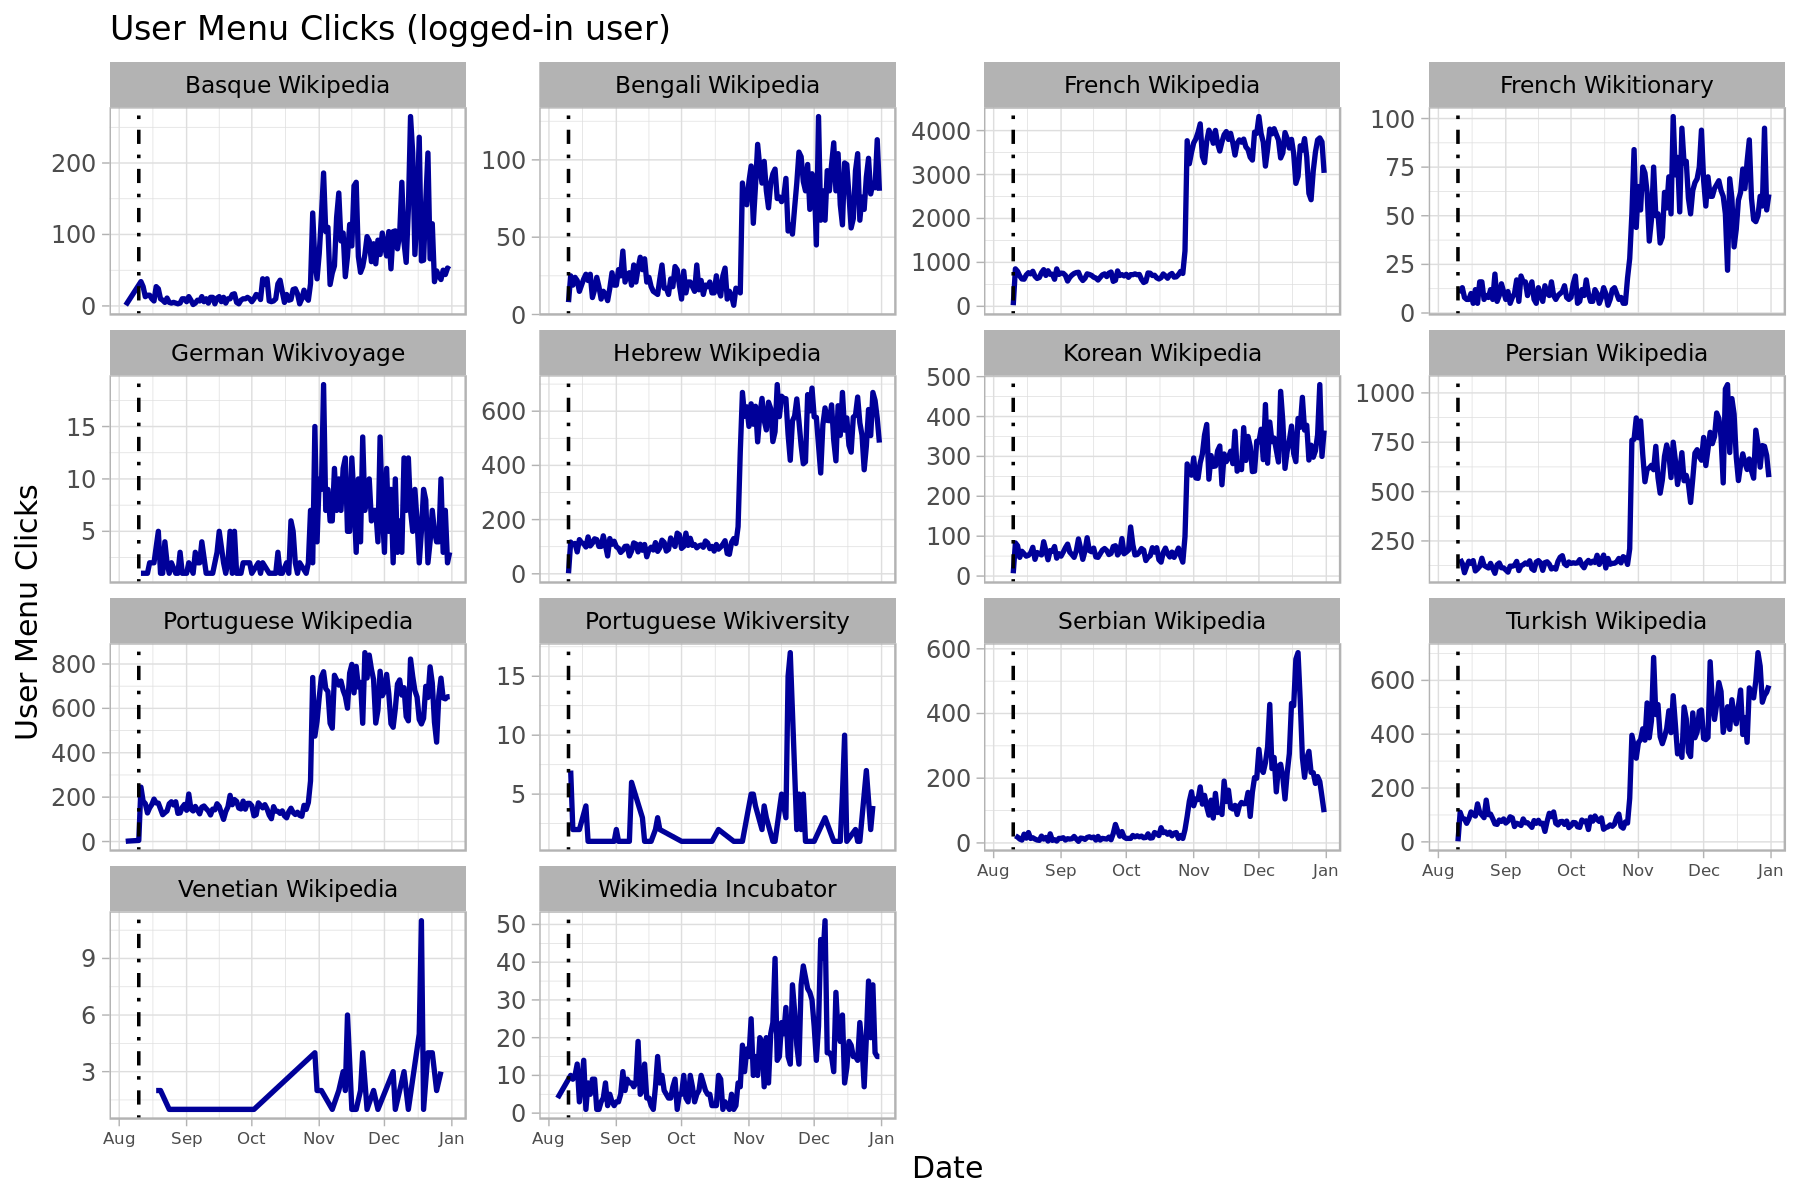

In [10]:
menu_g <- ggplot(data=filter( df_user_link_clicks,  (name=='ui.dropdown-p-personal')&(isanon=='false')), 
                                mapping=aes(x=event_date)) +
geom_line(aes(y=clicks ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Menu Clicks (logged-in user) ',
     x = 'Date',
     y = 'User Menu Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
menu_g

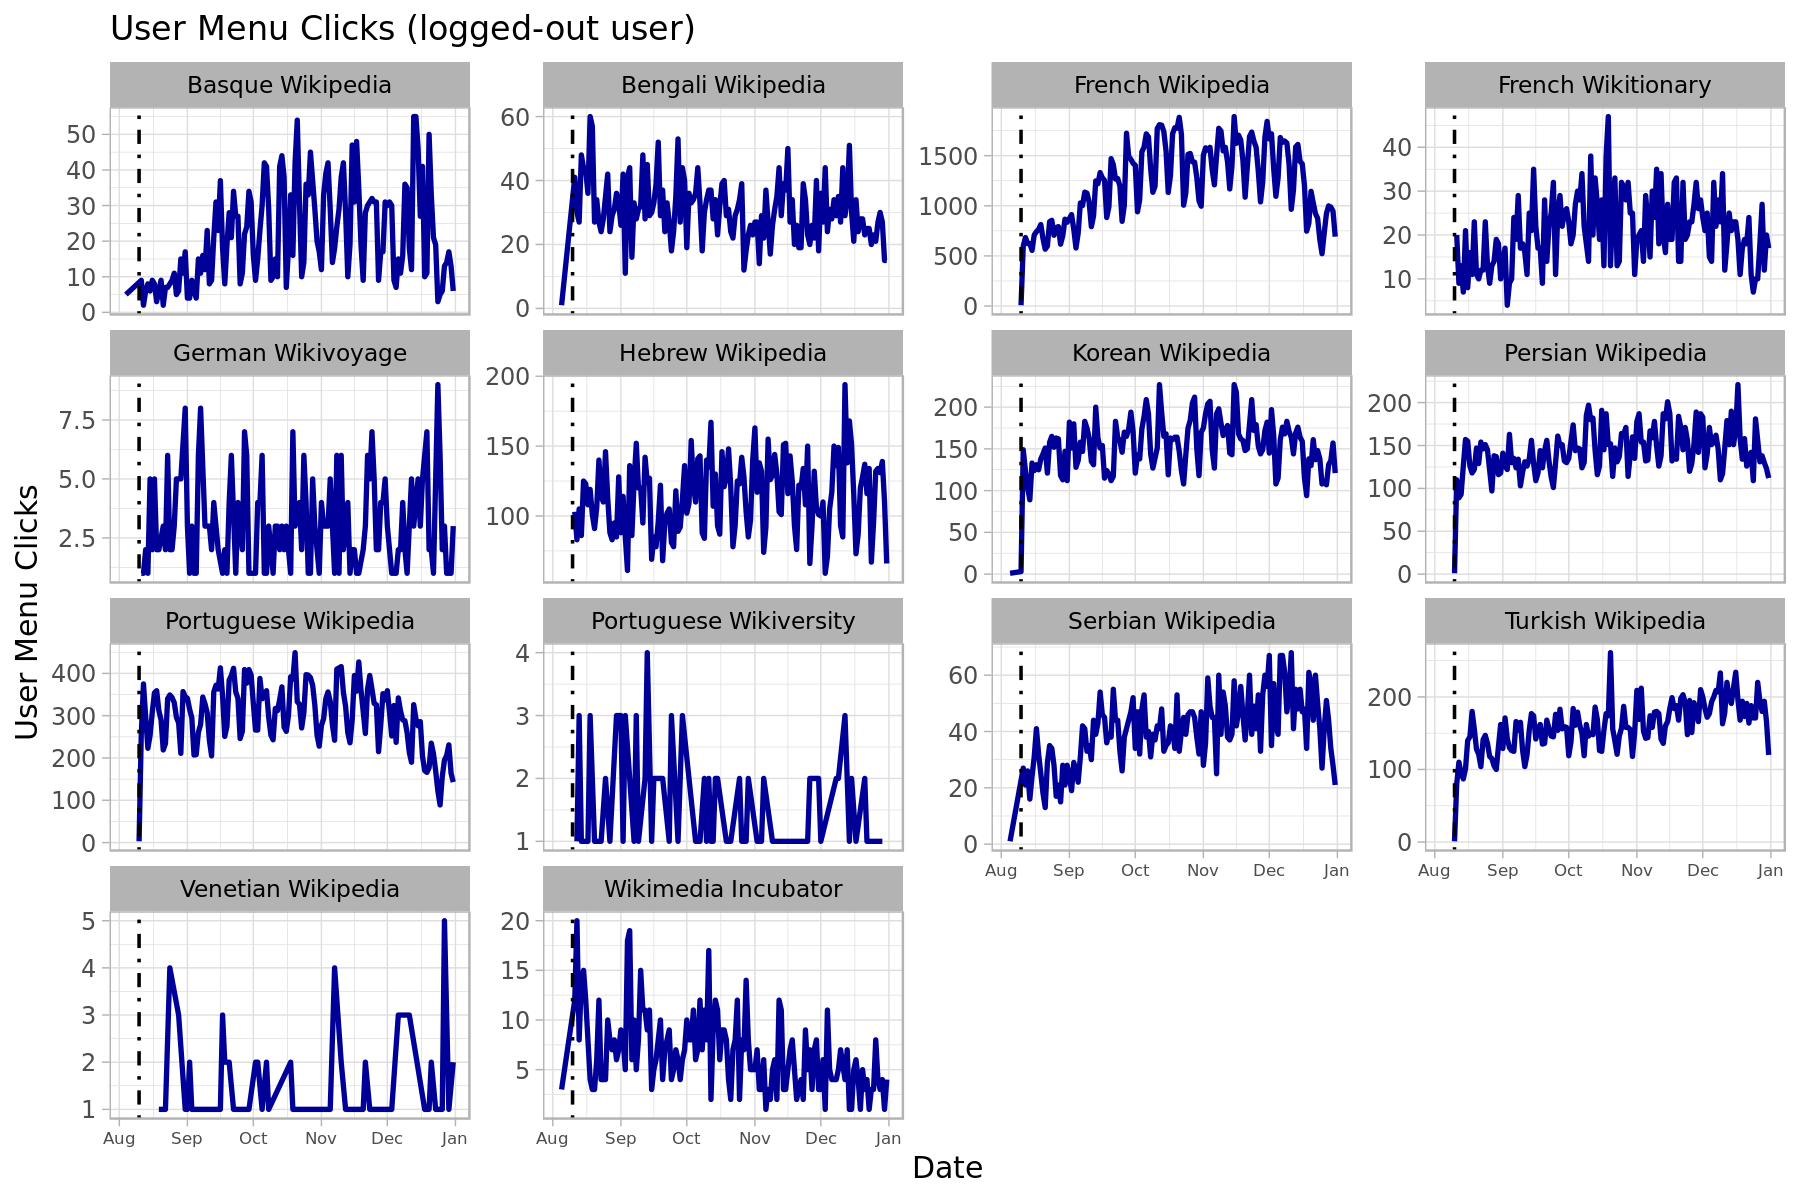

In [11]:
menu_anon_g <- ggplot(data=filter( df_user_link_clicks,  (name=='ui.dropdown-p-personal')&(isanon=='true')), 
                                mapping=aes(x=event_date)) +
geom_line(aes(y=clicks ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Menu Clicks (logged-out user) ',
     x = 'Date',
     y = 'User Menu Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
menu_anon_g

__Summary__


User dropdown menu is in use since 2021-08-10.

# Trend of User Link Clicks

## init events

In [83]:
query_init_events <- 
"
SELECT TO_DATE(dt) AS event_date, 
    wiki, 
    COUNT(1) AS init_events 
FROM event_sanitized.desktopwebuiactionstracking 
WHERE year=2021 and month >=7
AND event.action='init' AND NOT event.isAnon
-- only users with new skin version will see the new user menu
AND event.skinversion=2
AND wiki IN ('frwiktionary' , 'hewiki' ,'ptwikiversity' ,'frwiki', 'euwiki' ,
         'fawiki' ,'ptwiki' , 'kowiki' , 'trwiki' , 'srwiki' , 'bnwiki' , 'dewikivoyage' ,
         'vecwiki' , 'incubatorwiki' )
GROUP BY  TO_DATE(dt) , wiki, event.name, event.isAnon
"

In [84]:
df_init_events <-  wmfdata::query_hive(query_init_events)

Don't forget to authenticate with Kerberos using kinit



In [87]:
df_init_events$event_date <- as.Date(df_init_events$event_date)

In [88]:
df_init_events 

event_date wiki   init_events
1    2021-07-01 bnwiki  538       
2    2021-07-02 bnwiki  568       
3    2021-07-03 bnwiki  833       
4    2021-07-04 bnwiki 1018       
5    2021-07-05 bnwiki  595       
6    2021-07-06 bnwiki  881       
7    2021-07-07 bnwiki  644       
8    2021-07-08 bnwiki  816       
9    2021-07-09 bnwiki  660       
10   2021-07-10 bnwiki  713       
11   2021-07-11 bnwiki  718       
12   2021-07-12 bnwiki  774       
13   2021-07-13 bnwiki  642       
14   2021-07-14 bnwiki  722       
15   2021-07-15 bnwiki  836       
16   2021-07-16 bnwiki  878       
17   2021-07-17 bnwiki  734       
18   2021-07-18 bnwiki  657       
19   2021-07-19 bnwiki  875       
20   2021-07-20 bnwiki  784       
21   2021-07-21 bnwiki  492       
22   2021-07-22 bnwiki  617       
23   2021-07-23 bnwiki  770       
24   2021-07-24 bnwiki  646       
25   2021-07-25 bnwiki  704       
26   2021-07-26 bnwiki  873       
27   2021-07-27 bnwiki 1086       
28   2021-07-28 bnwiki 1066       
29   2021-07-29 bnwiki  813       
30   2021-07-30 bnwiki  956       
⋮    ⋮          ⋮      ⋮          
2544 2021-12-02 trwiki 13020      
2545 2021-12-03 trwiki 12845      
2546 2021-12-04 trwiki 17777      
2547 2021-12-05 trwiki 15036      
2548 2021-12-06 trwiki 14003      
2549 2021-12-07 trwiki 14084      
2550 2021-12-08 trwiki 16112      
2551 2021-12-09 trwiki 15339      
2552 2021-12-10 trwiki 13380      
2553 2021-12-11 trwiki 12956      
2554 2021-12-12 trwiki 15707      
2555 2021-12-13 trwiki 14218      
2556 2021-12-14 trwiki 14003      
2557 2021-12-15 trwiki 12847      
2558 2021-12-16 trwiki 14344      
2559 2021-12-17 trwiki 14074      
2560 2021-12-18 trwiki 12614      
2561 2021-12-19 trwiki 13543      
2562 2021-12-20 trwiki 14380      
2563 2021-12-21 trwiki 13705      
2564 2021-12-22 trwiki 14587      
2565 2021-12-23 trwiki 15003      
2566 2021-12-24 trwiki 15612      
2567 2021-12-25 trwiki 15459      
2568 2021-12-26 trwiki 17332      
2569 2021-12-27 trwiki 17851      
2570 2021-12-28 trwiki 14180      
2571 2021-12-29 trwiki 16108      
2572 2021-12-30 trwiki 17391      
2573 2021-12-31 trwiki 16377

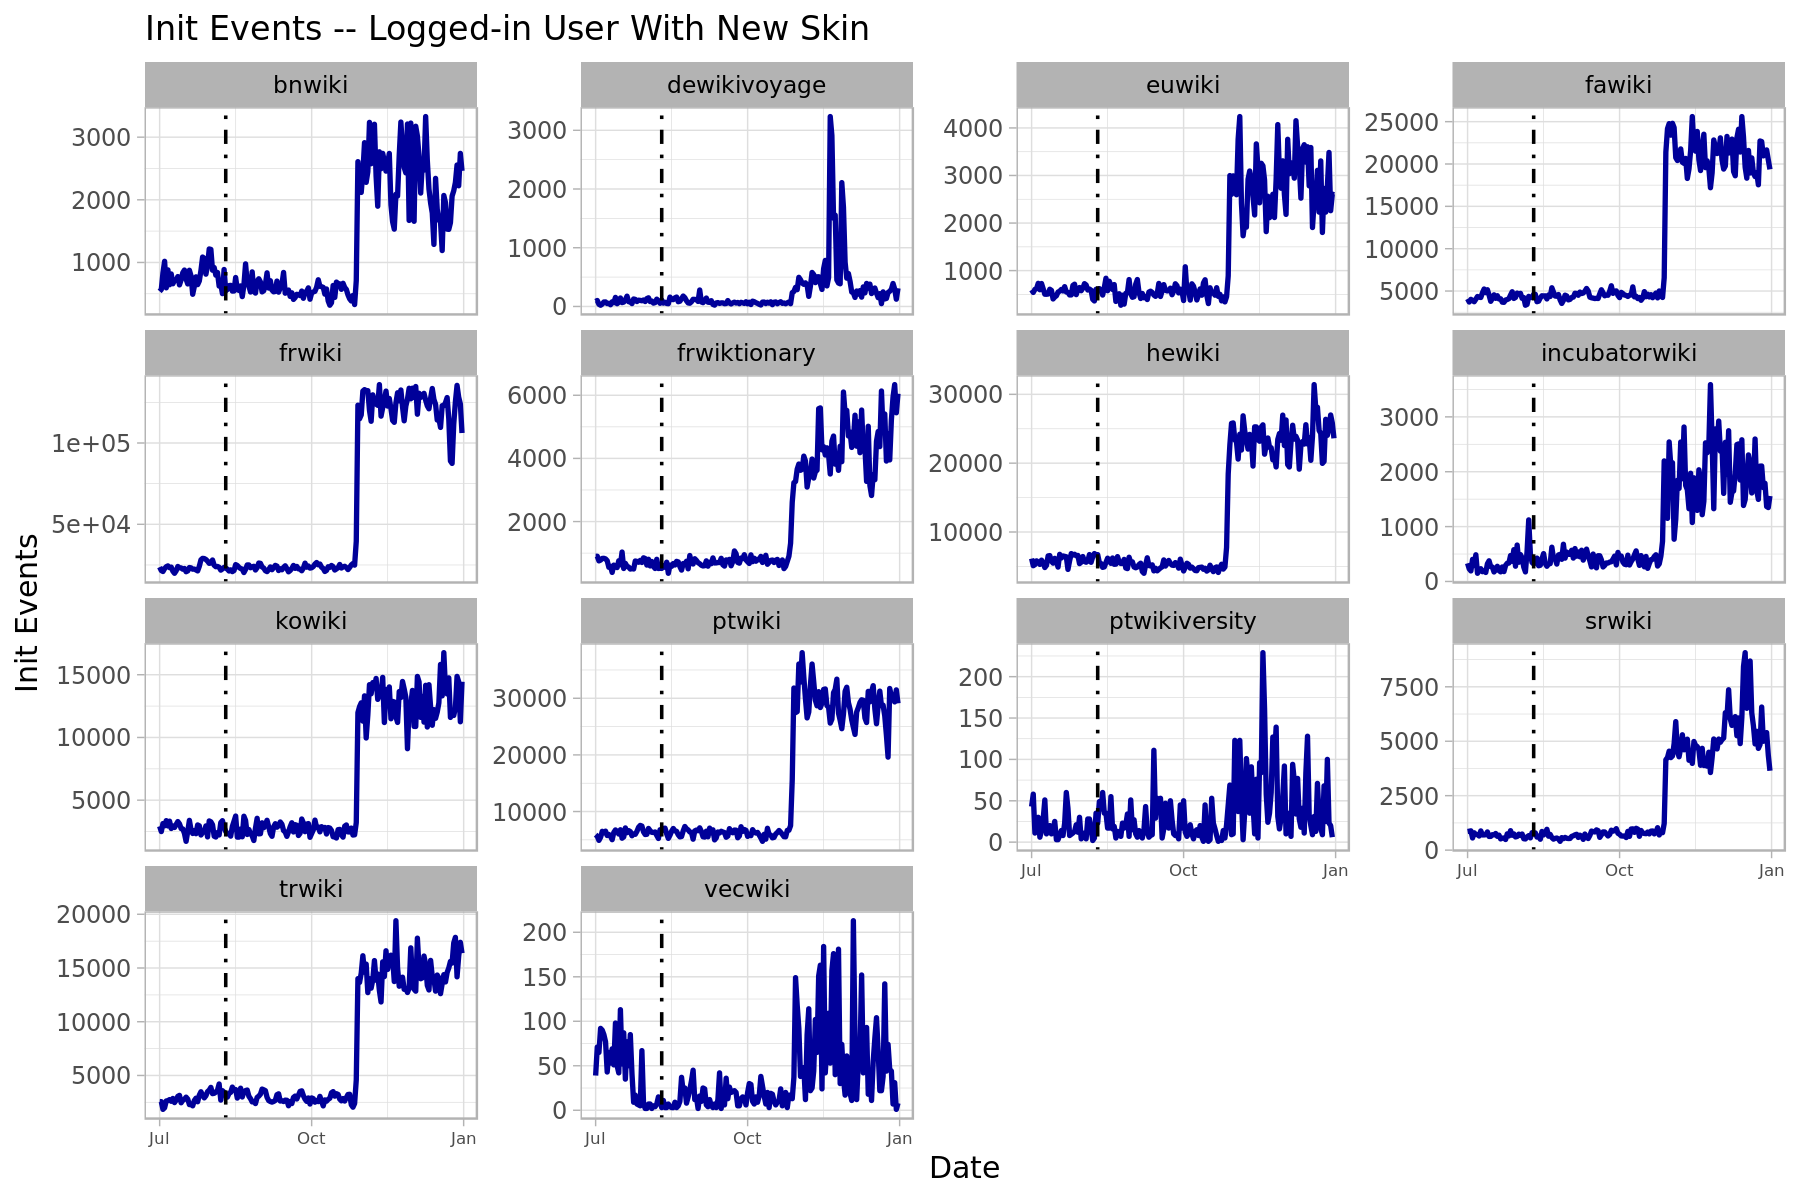

In [91]:
init_g <- ggplot(data=df_init_events , 
                                mapping=aes(x=event_date)) +
geom_line(aes(y=init_events ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki,nrow=4,scale = 'free_y')+
labs(title = 'Init Events -- Logged-in User With New Skin',
     x = 'Date',
     y = 'Init Events') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
init_g

__Note__   

The number of initiated events is consistent between 4 weeks before deployment and 4 weeks after deployment, except for 3 wikis: bnwiki, vecwiki and incubatorwiki.  Bnwiki and vecwiki have higher numbers of initiated events. Incubatorwiki has a pulse before deployment. We will use clicks/inits to measure the click trend to exclude the fluctuation in traffic. 

We also may use clicks/number of unique initiated sessions to measure the click trend. However session Id (`token`) is not saved in `event_sanitized.desktopwebuiactionstracking` table. 

## By wiki and user tool

In [101]:
df_watchlist <- df_user_link_clicks %>% 
    filter( (name=='pt-watchlist')&(isanon=='false')) %>%
    left_join(df_init_events,  by =c('event_date'='event_date','wiki'='wiki')) %>%
    mutate(clicks_per_inits=round((clicks/init_events)* 100 , 2))



geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



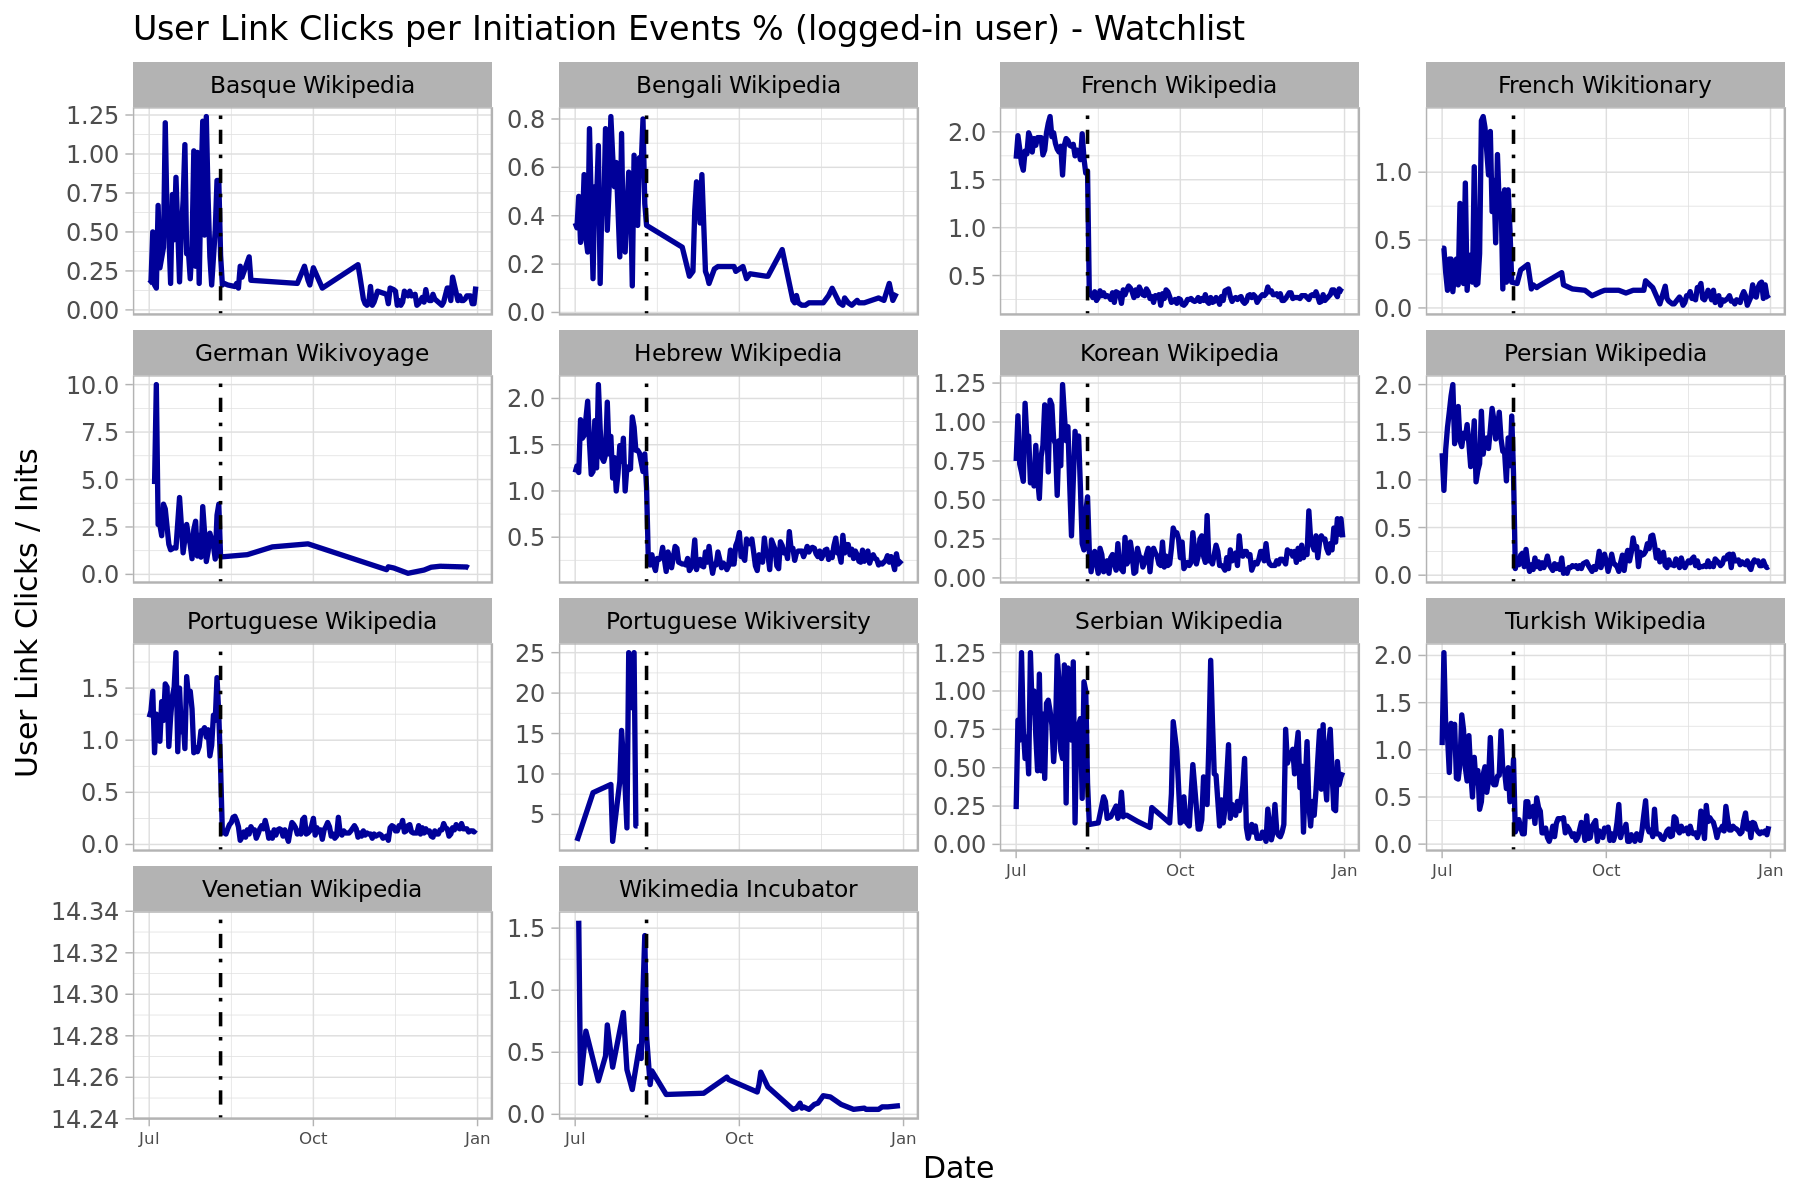

In [114]:
watchlist_g <- ggplot(data=df_watchlist, 
                                mapping=aes(x=event_date)) +
geom_line(aes(y=clicks_per_inits ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks per Initiation Events % (logged-in user) - Watchlist ',
     x = 'Date',
     y = 'User Link Clicks / Inits') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
     
watchlist_g 

In [107]:
df_talk <- df_user_link_clicks %>% 
    filter( (name=='pt-mytalk')&(isanon=='false')) %>%
    left_join(df_init_events,  by =c('event_date'='event_date','wiki'='wiki')) %>%
    mutate(clicks_per_inits=round((clicks/init_events)* 100 , 2))

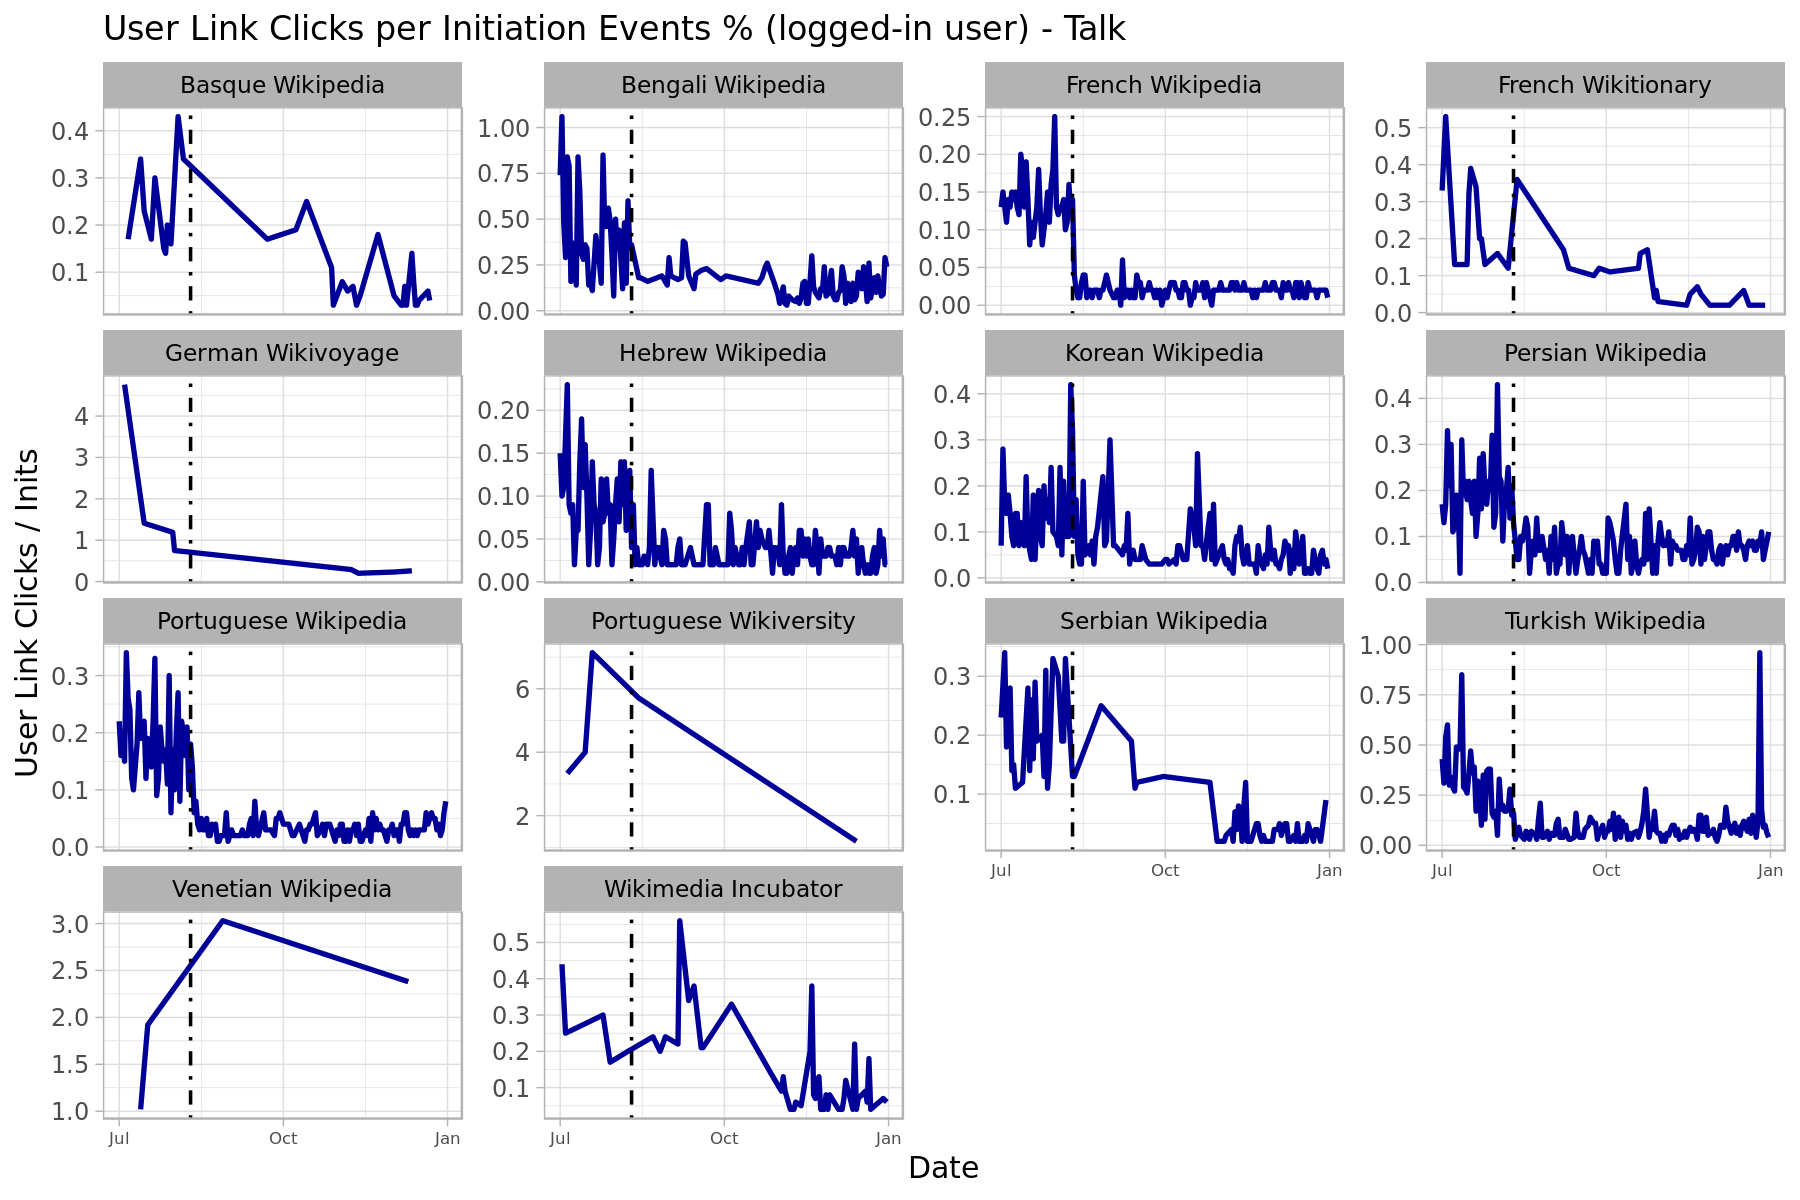

In [113]:
talk_g <- ggplot(data=df_talk, 
                                mapping=aes(x=event_date)) +
geom_line(aes(y=clicks_per_inits ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks per Initiation Events % (logged-in user) - Talk ',
     x = 'Date',
     y = 'User Link Clicks / Inits') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
     
talk_g 

In [115]:
df_sandbox <- df_user_link_clicks %>% 
    filter( (name=='pt-sandbox')&(isanon=='false')) %>%
    left_join(df_init_events,  by =c('event_date'='event_date','wiki'='wiki')) %>%
    mutate(clicks_per_inits=round((clicks/init_events)* 100 , 2))

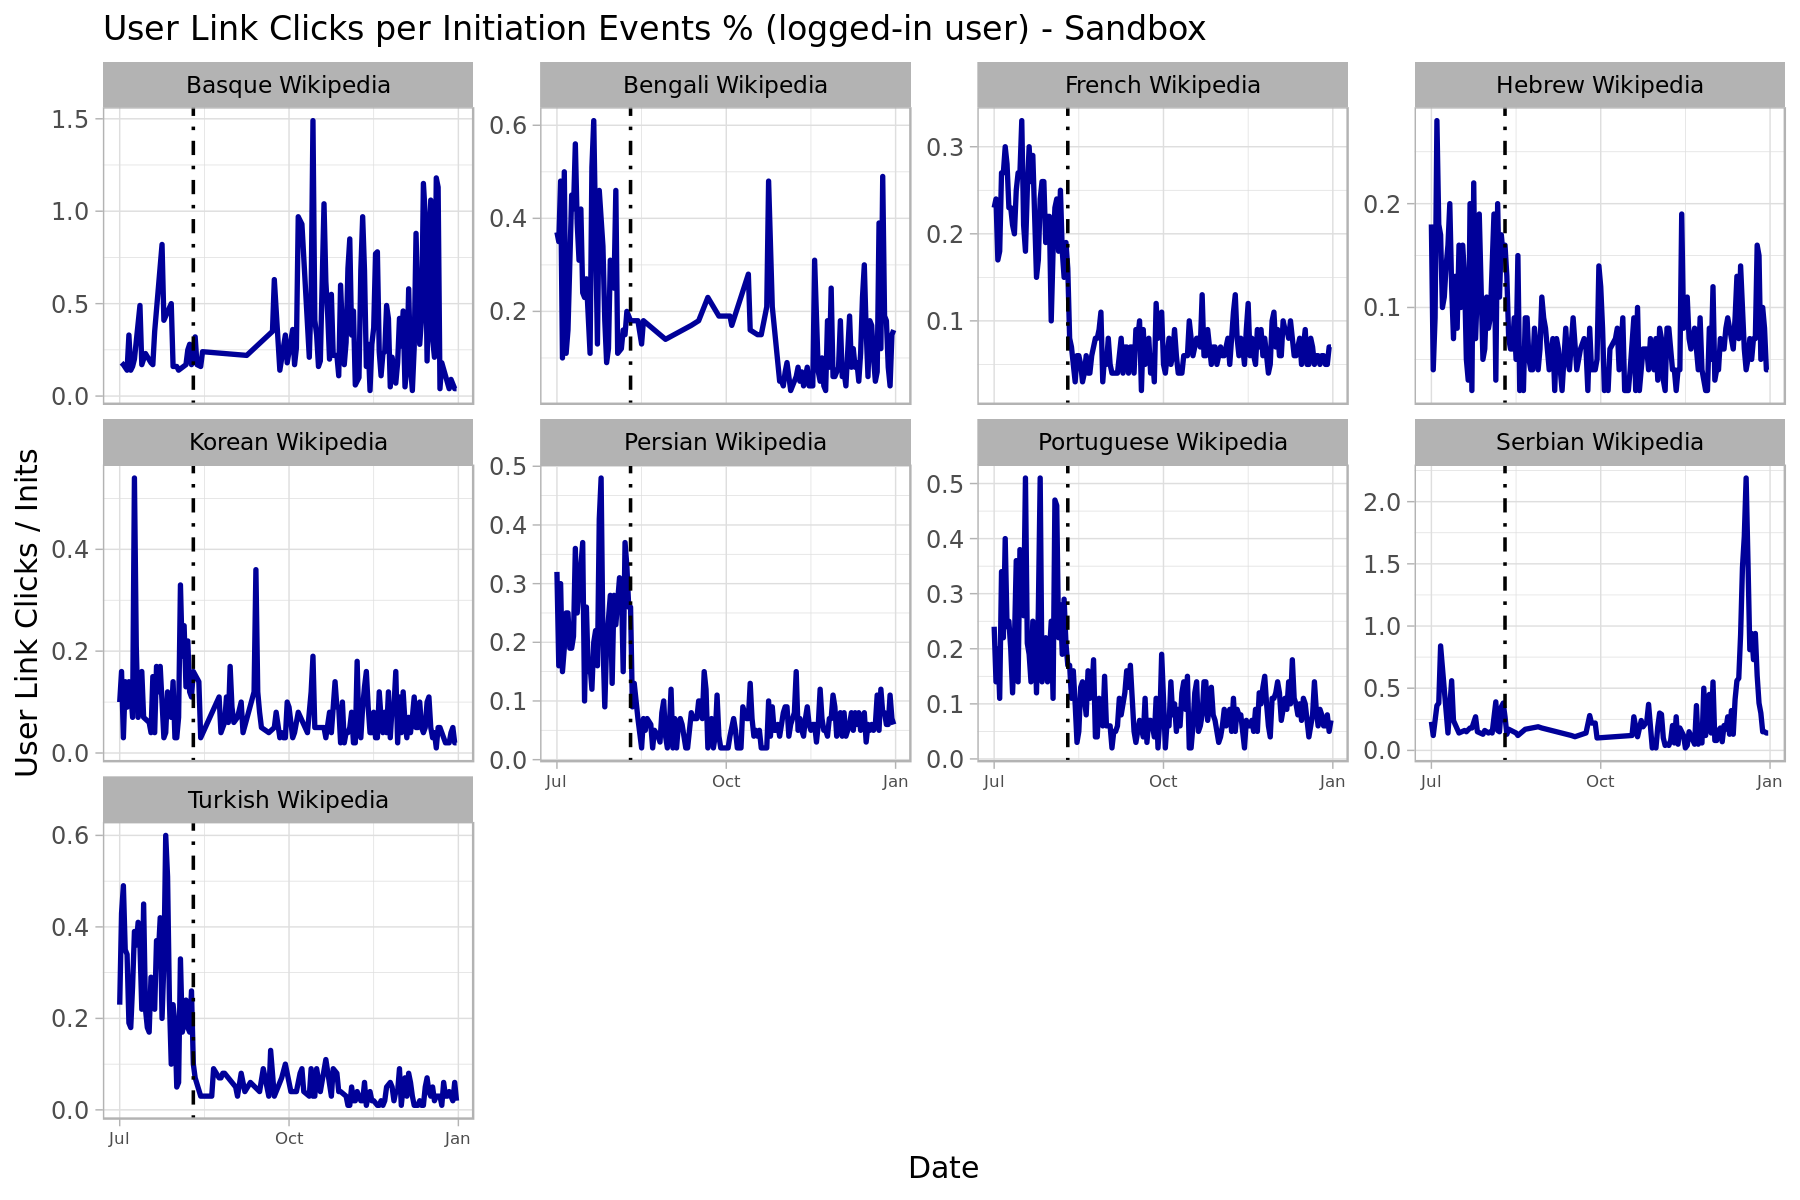

In [117]:
sandbox_g <- ggplot(data=df_sandbox,
                                mapping=aes(x=event_date)) +
geom_line(aes(y=clicks_per_inits), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,ncol=4,scale = 'free_y')+
labs(title = 'User Link Clicks per Initiation Events % (logged-in user) - Sandbox ',
     x = 'Date',
     y = 'User Link Clicks / Inits') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
     
sandbox_g 

In [118]:
df_preferences <- df_user_link_clicks %>% 
    filter( (name=='pt-preferences')&(isanon=='false')) %>%
    left_join(df_init_events,  by =c('event_date'='event_date','wiki'='wiki')) %>%
    mutate(clicks_per_inits=round((clicks/init_events)* 100 , 2))

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



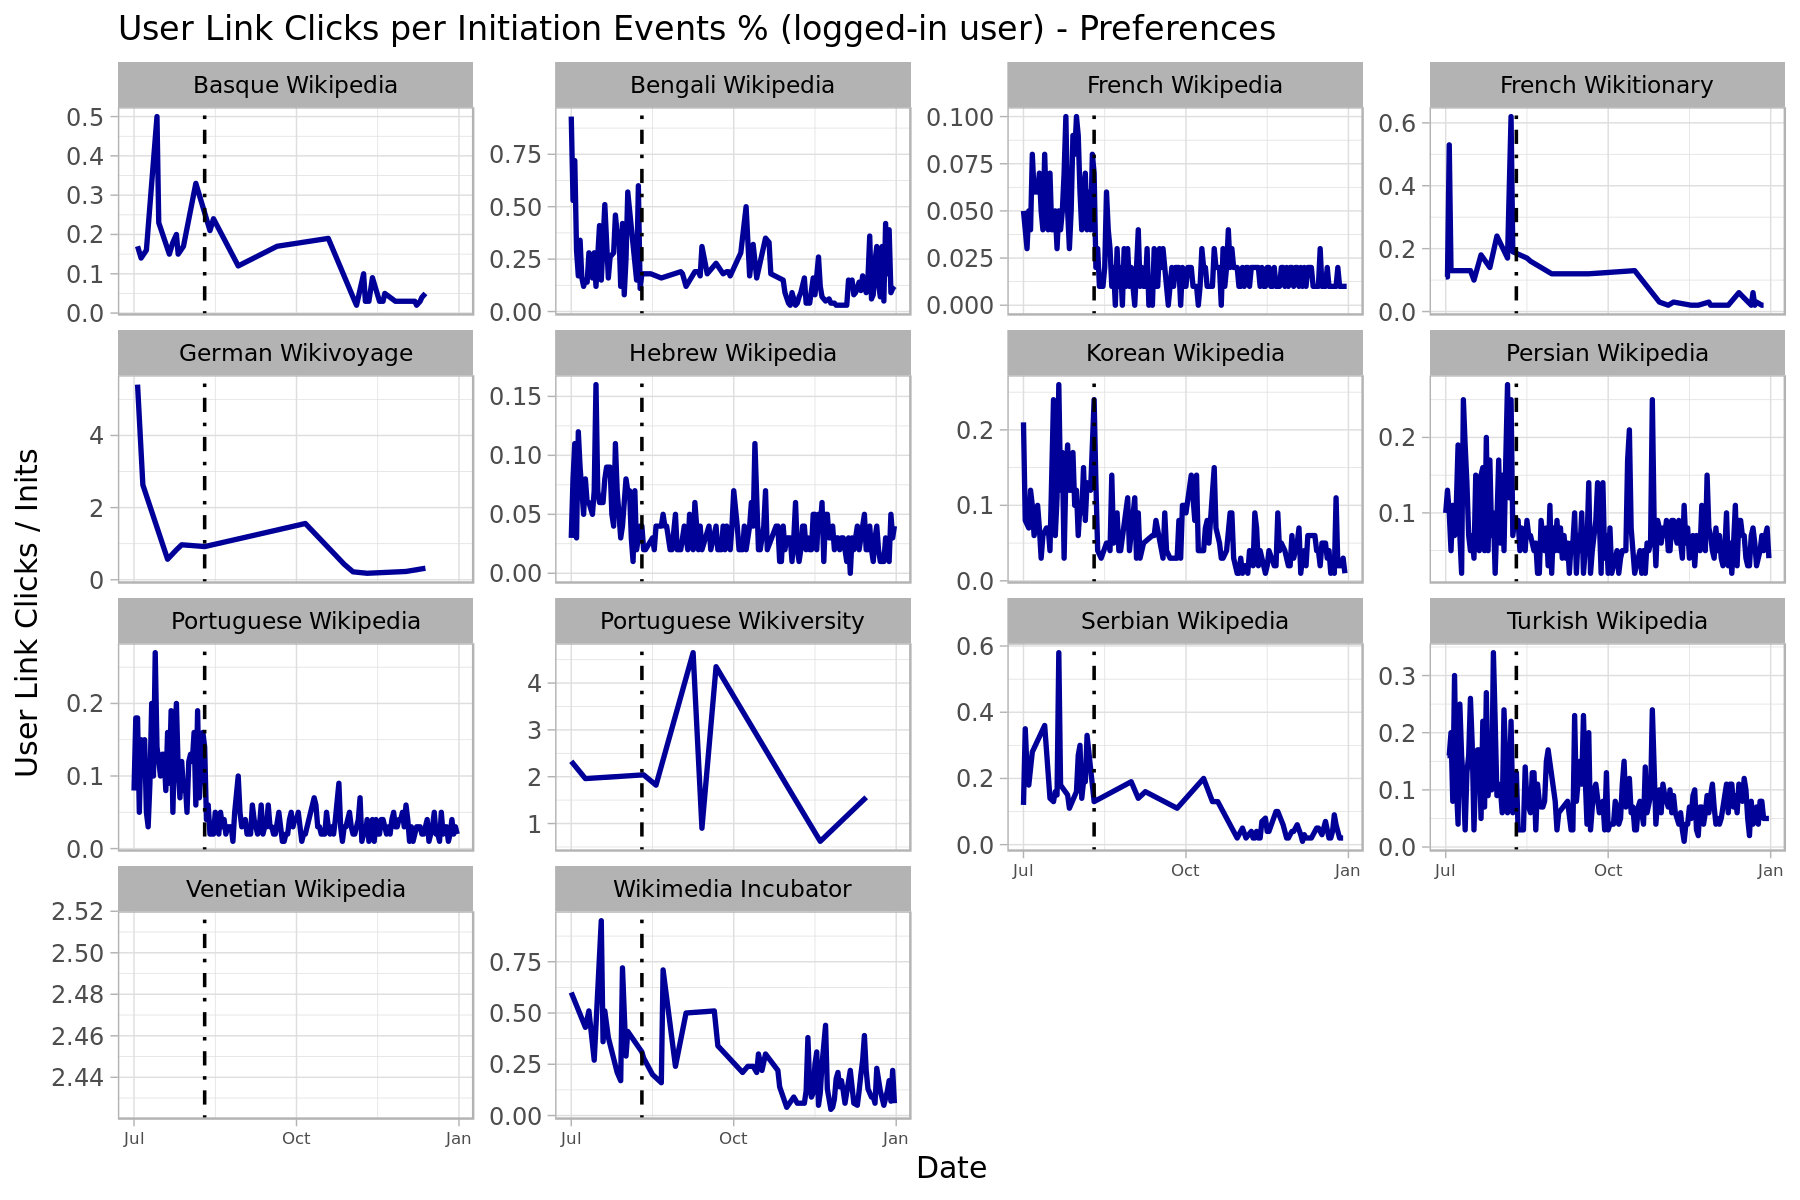

In [119]:
preferences_g <- ggplot(data=df_preferences,
                                mapping=aes(x=event_date)) +
geom_line(aes(y=clicks_per_inits), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks per Initiation Events % (logged-in user) - Preferences ',
     x = 'Date',
     y = 'User Link Clicks / Inits') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
     
preferences_g 

In [120]:
df_beta <- df_user_link_clicks %>% 
    filter( (name=='pt-betafeatures')&(isanon=='false')) %>%
    left_join(df_init_events,  by =c('event_date'='event_date','wiki'='wiki')) %>%
    mutate(clicks_per_inits=round((clicks/init_events)* 100 , 2))

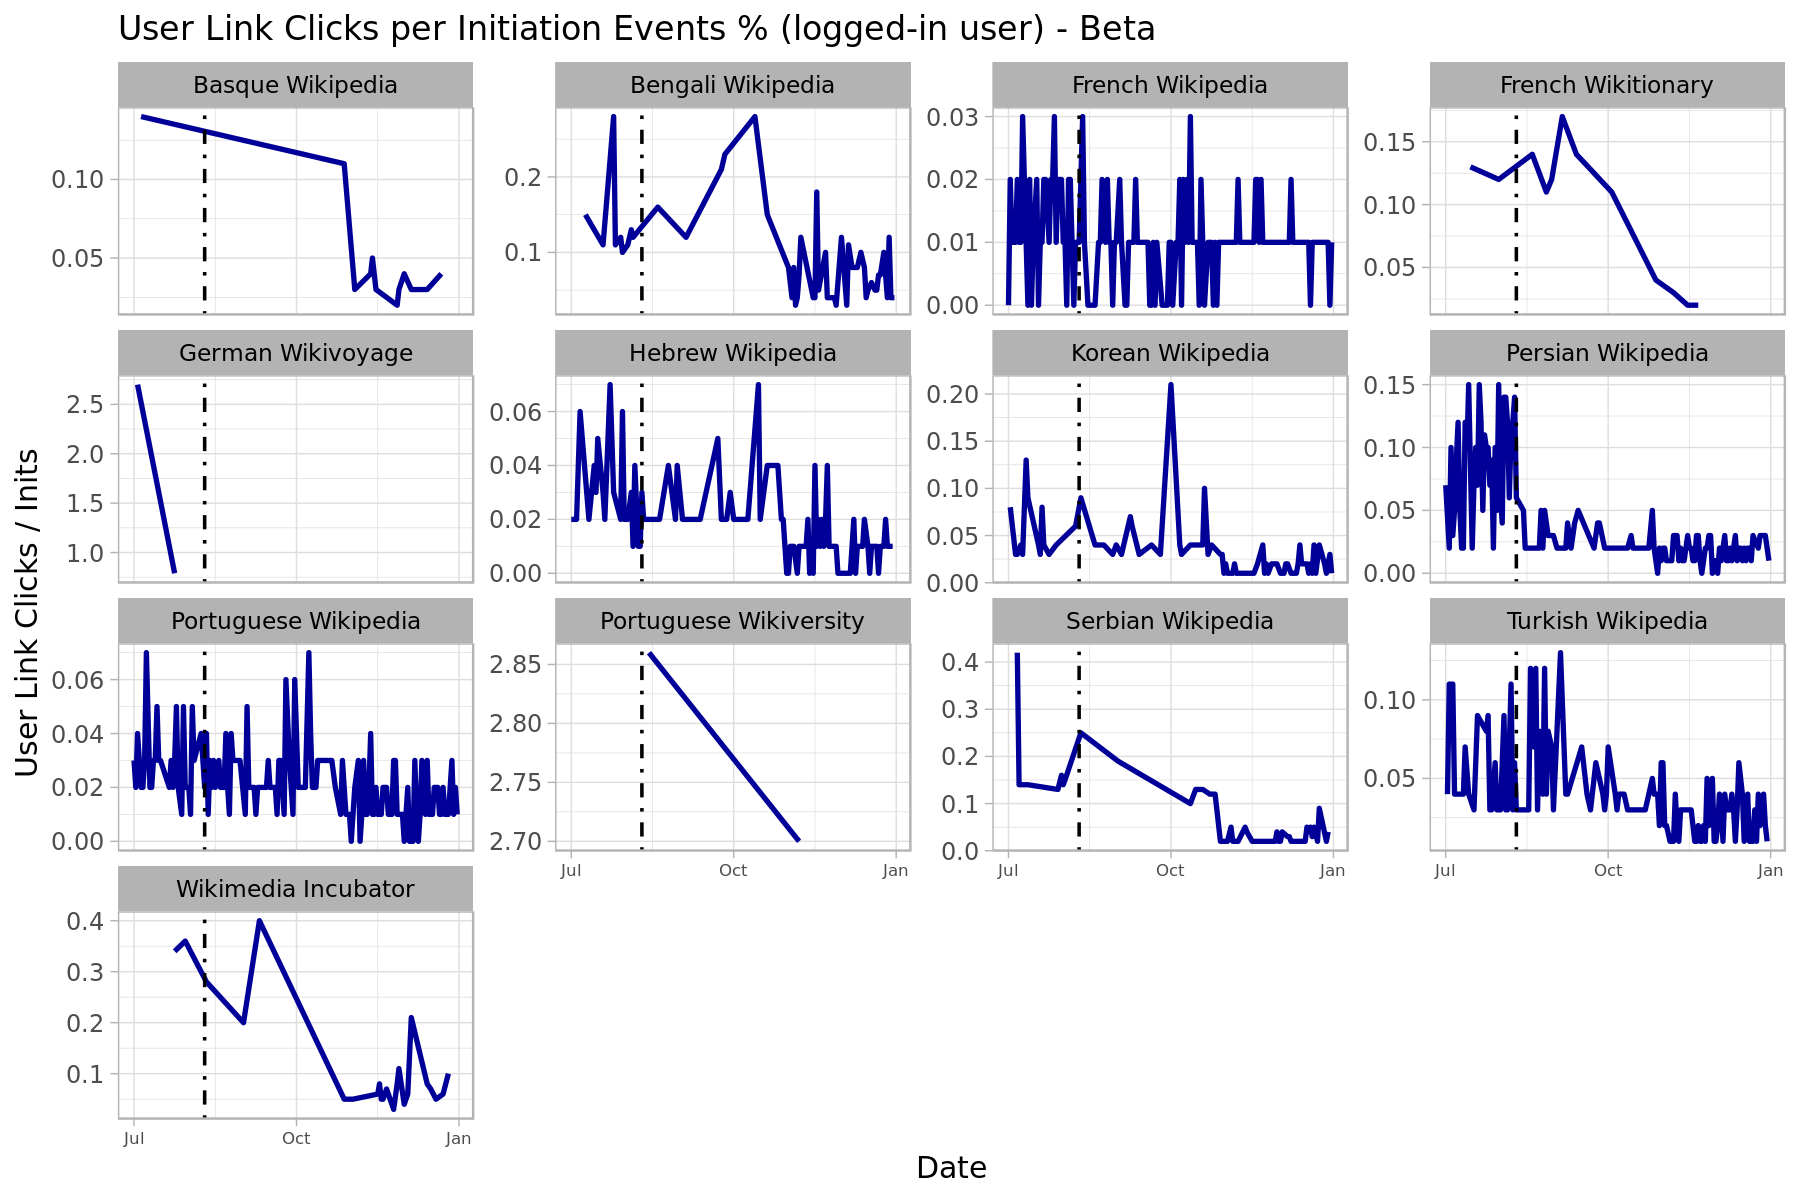

In [121]:
beta_g <- ggplot(data=df_beta,
                                mapping=aes(x=event_date)) +
geom_line(aes(y=clicks_per_inits ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,ncol=4,scale = 'free_y')+
labs(title = 'User Link Clicks per Initiation Events % (logged-in user) - Beta ',
     x = 'Date',
     y = 'User Link Clicks / Inits') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
     
beta_g 

In [122]:
df_contri <- df_user_link_clicks %>% 
    filter( (name=='pt-mycontris')&(isanon=='false')) %>%
    left_join(df_init_events,  by =c('event_date'='event_date','wiki'='wiki')) %>%
    mutate(clicks_per_inits=round((clicks/init_events)* 100 , 2))

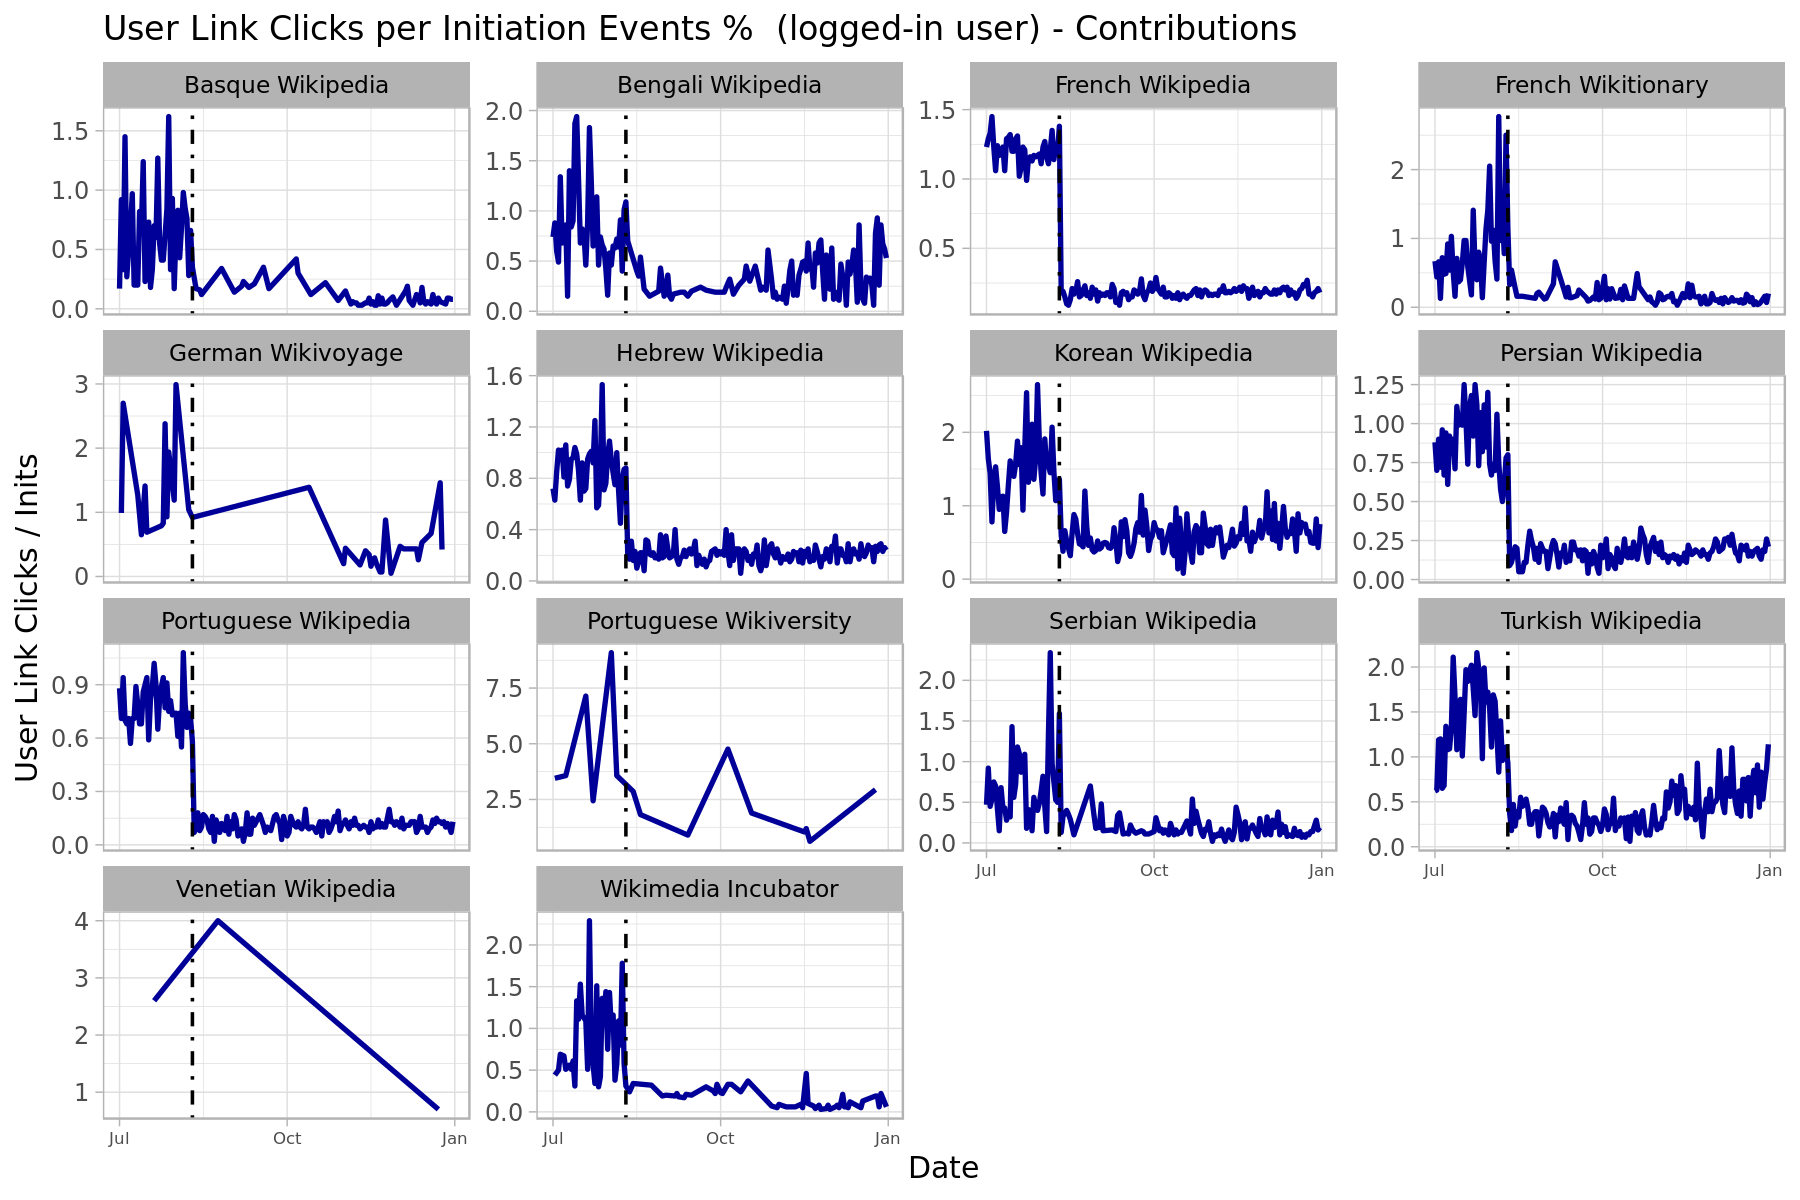

In [123]:
contri_g <- ggplot(data=df_contri,
                                mapping=aes(x=event_date)) +
geom_line(aes(y=clicks_per_inits ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks per Initiation Events %  (logged-in user) - Contributions ',
     x = 'Date',
     y = 'User Link Clicks / Inits ') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
     
contri_g 

In [125]:
df_logout <- df_user_link_clicks %>% 
    filter( (name=='pt-mycontris')&(isanon=='false')) %>%
    left_join(df_init_events,  by =c('event_date'='event_date','wiki'='wiki')) %>%
    mutate(clicks_per_inits=round((clicks/init_events)* 100 , 2))

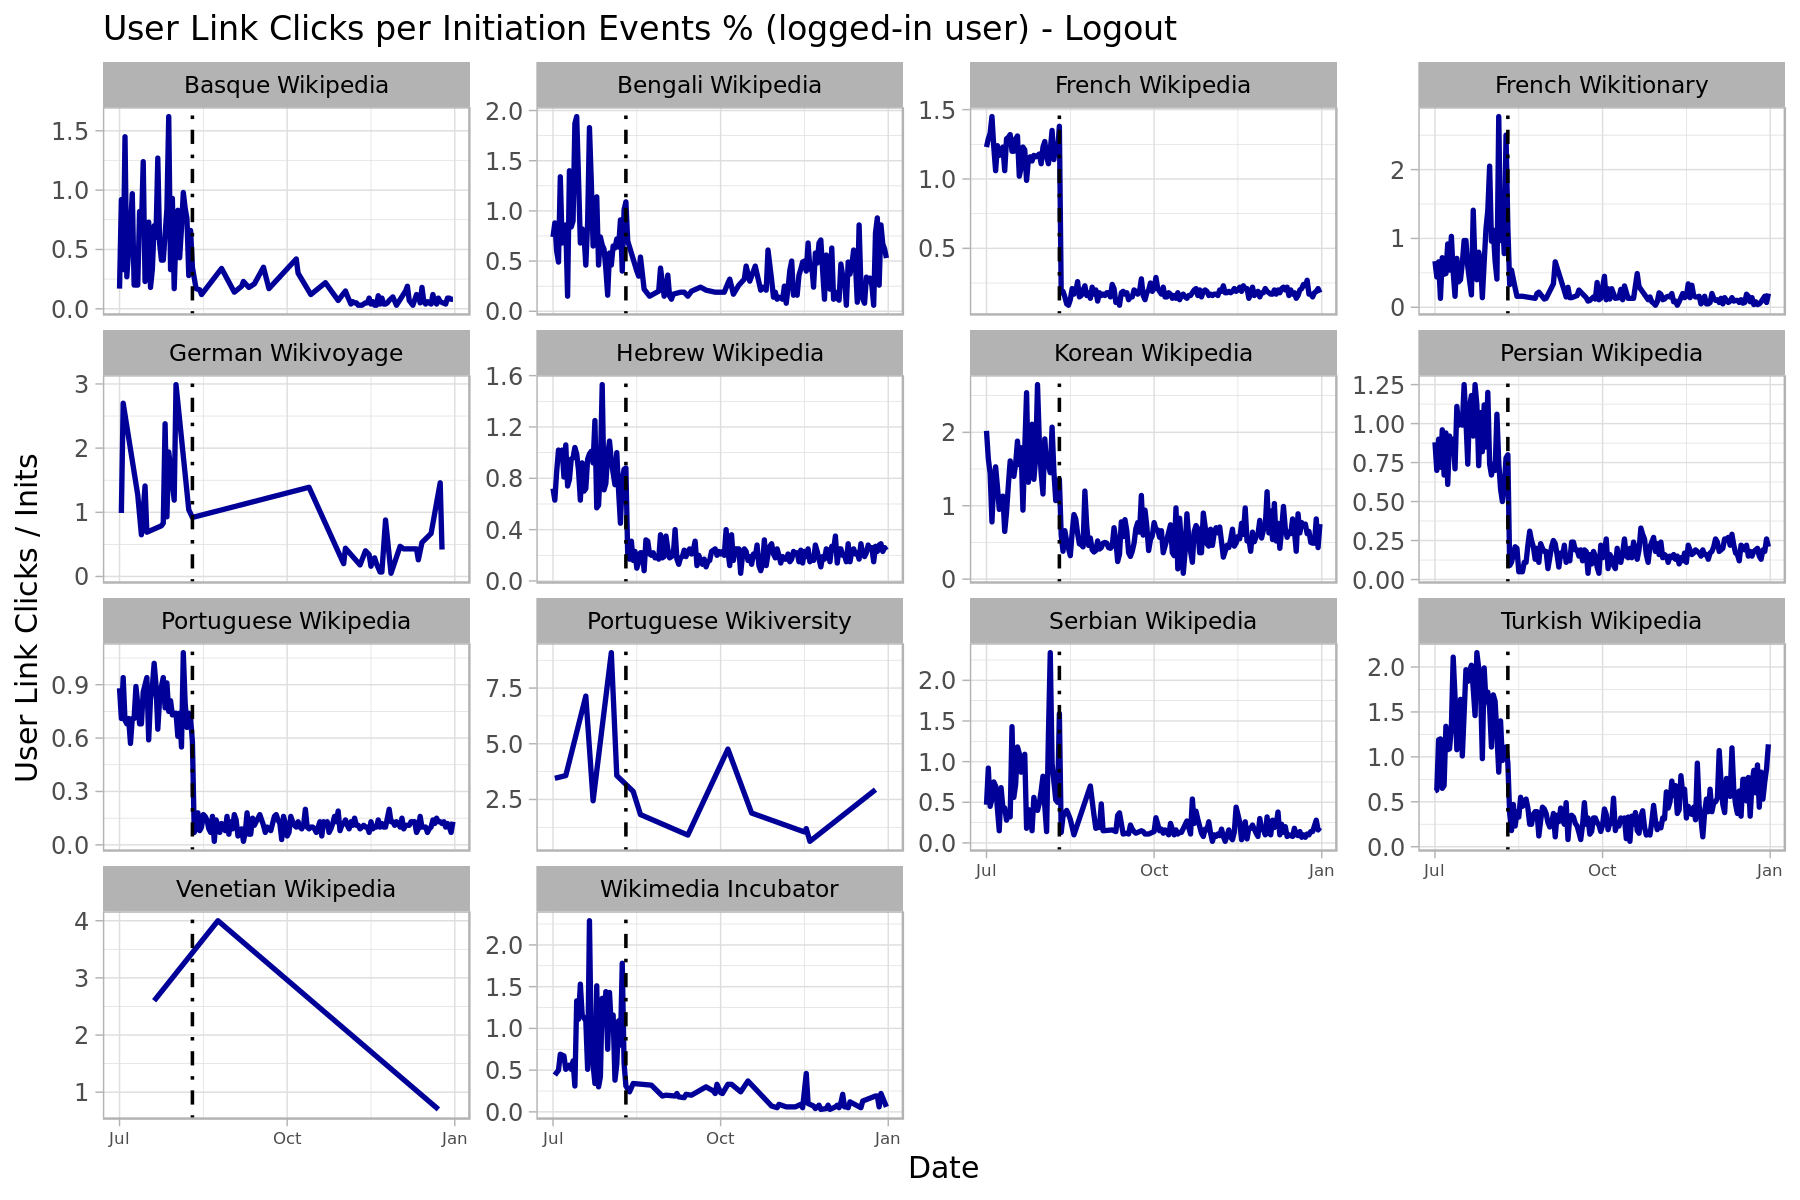

In [126]:
logout_g <- ggplot(data=df_logout ,
                                mapping=aes(x=event_date)) +
geom_line(aes(y=clicks_per_inits ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks per Initiation Events % (logged-in user) - Logout ',
     x = 'Date',
     y = 'User Link Clicks / Inits ') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
logout_g 

## By wiki

In [129]:
df_wiki <- df_user_link_clicks %>%
    filter((isanon=='false') & (name!='ui.dropdown-p-personal')) %>%
    group_by(wiki_name,wiki, event_date) %>%
    summarize(user_link_clicks=sum(clicks, na.rm=TRUE), .groups='drop') %>%
    left_join(df_init_events,  by =c('event_date'='event_date','wiki'='wiki')) %>%
    mutate(clicks_per_inits=round((user_link_clicks/init_events)* 100 , 2))

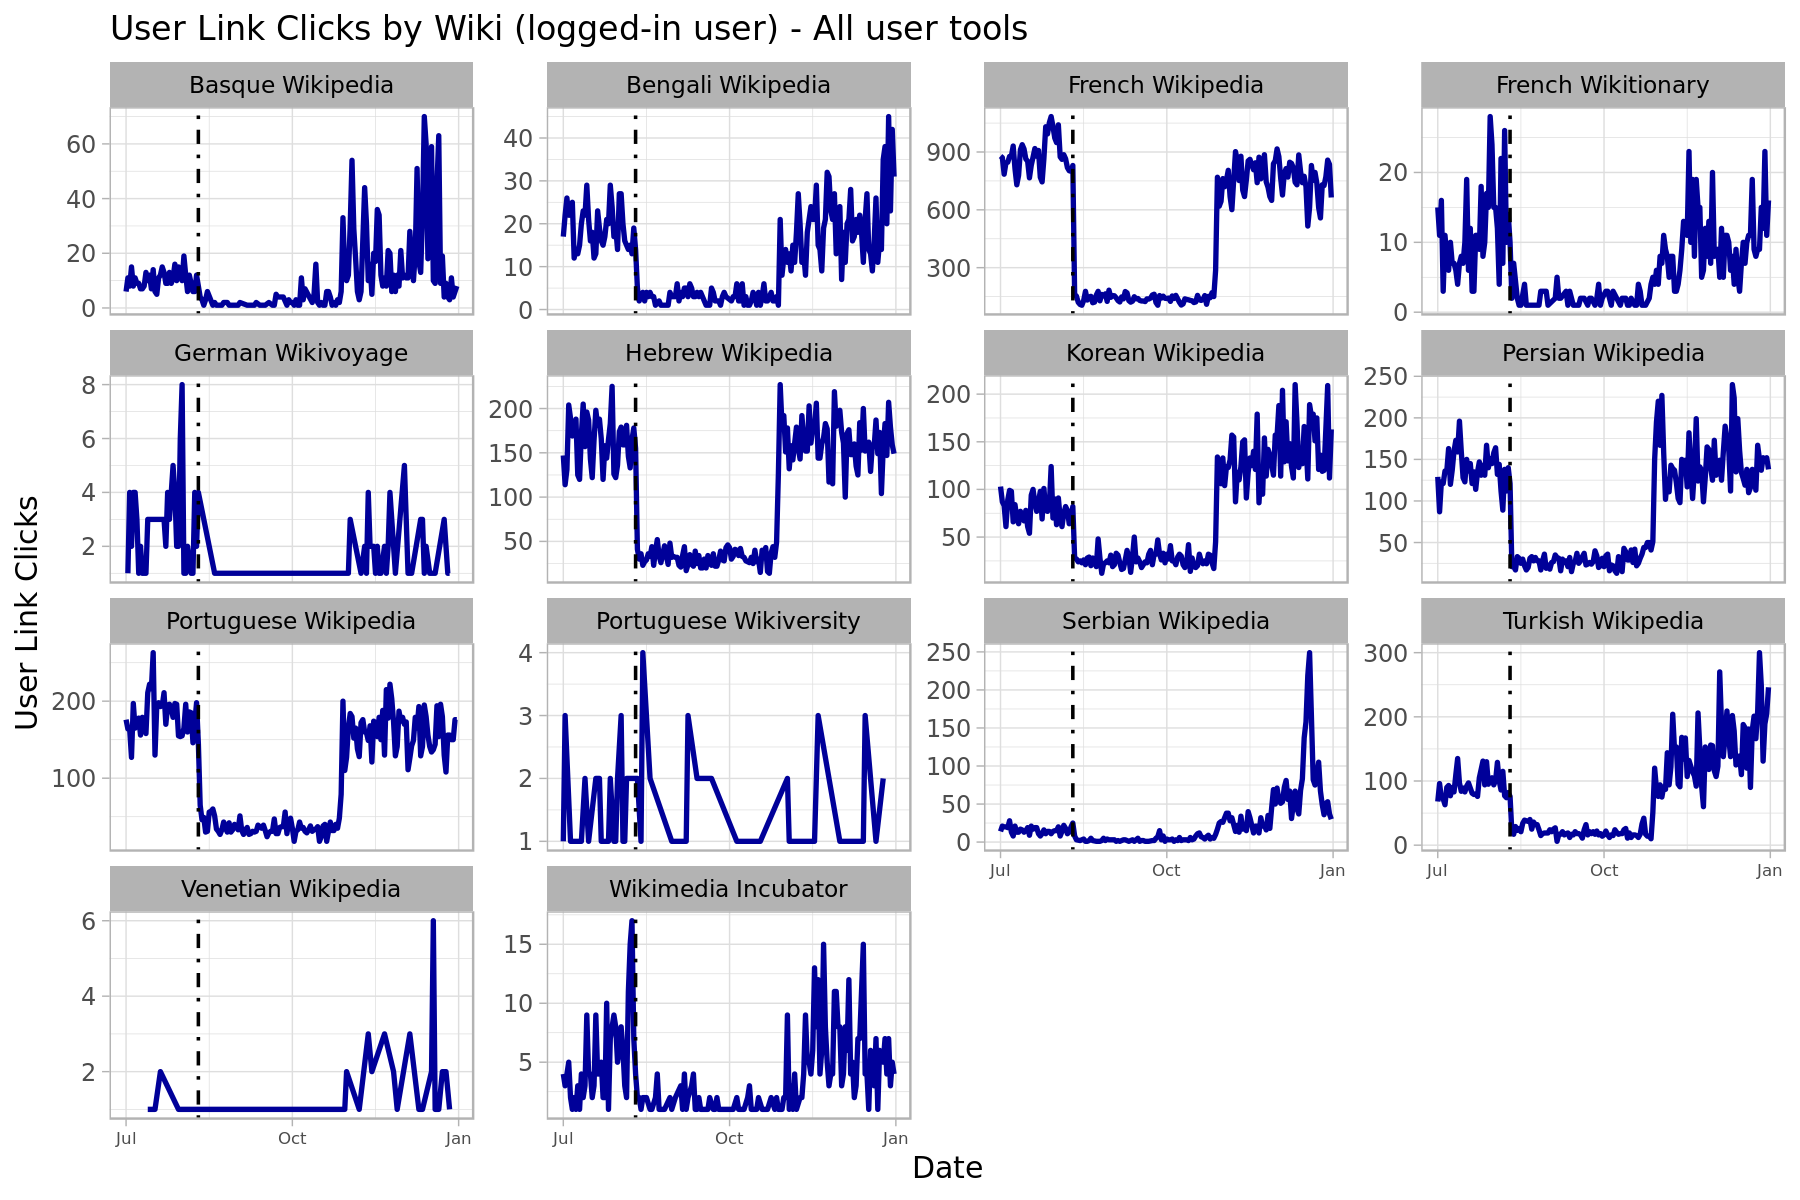

In [23]:
wiki_g <- ggplot(data=df_wiki,
                                mapping=aes(x=event_date)) +
geom_line(aes(y=user_link_clicks ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks by Wiki (logged-in user) - All user tools ',
     x = 'Date',
     y = 'User Link Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
wiki_g 

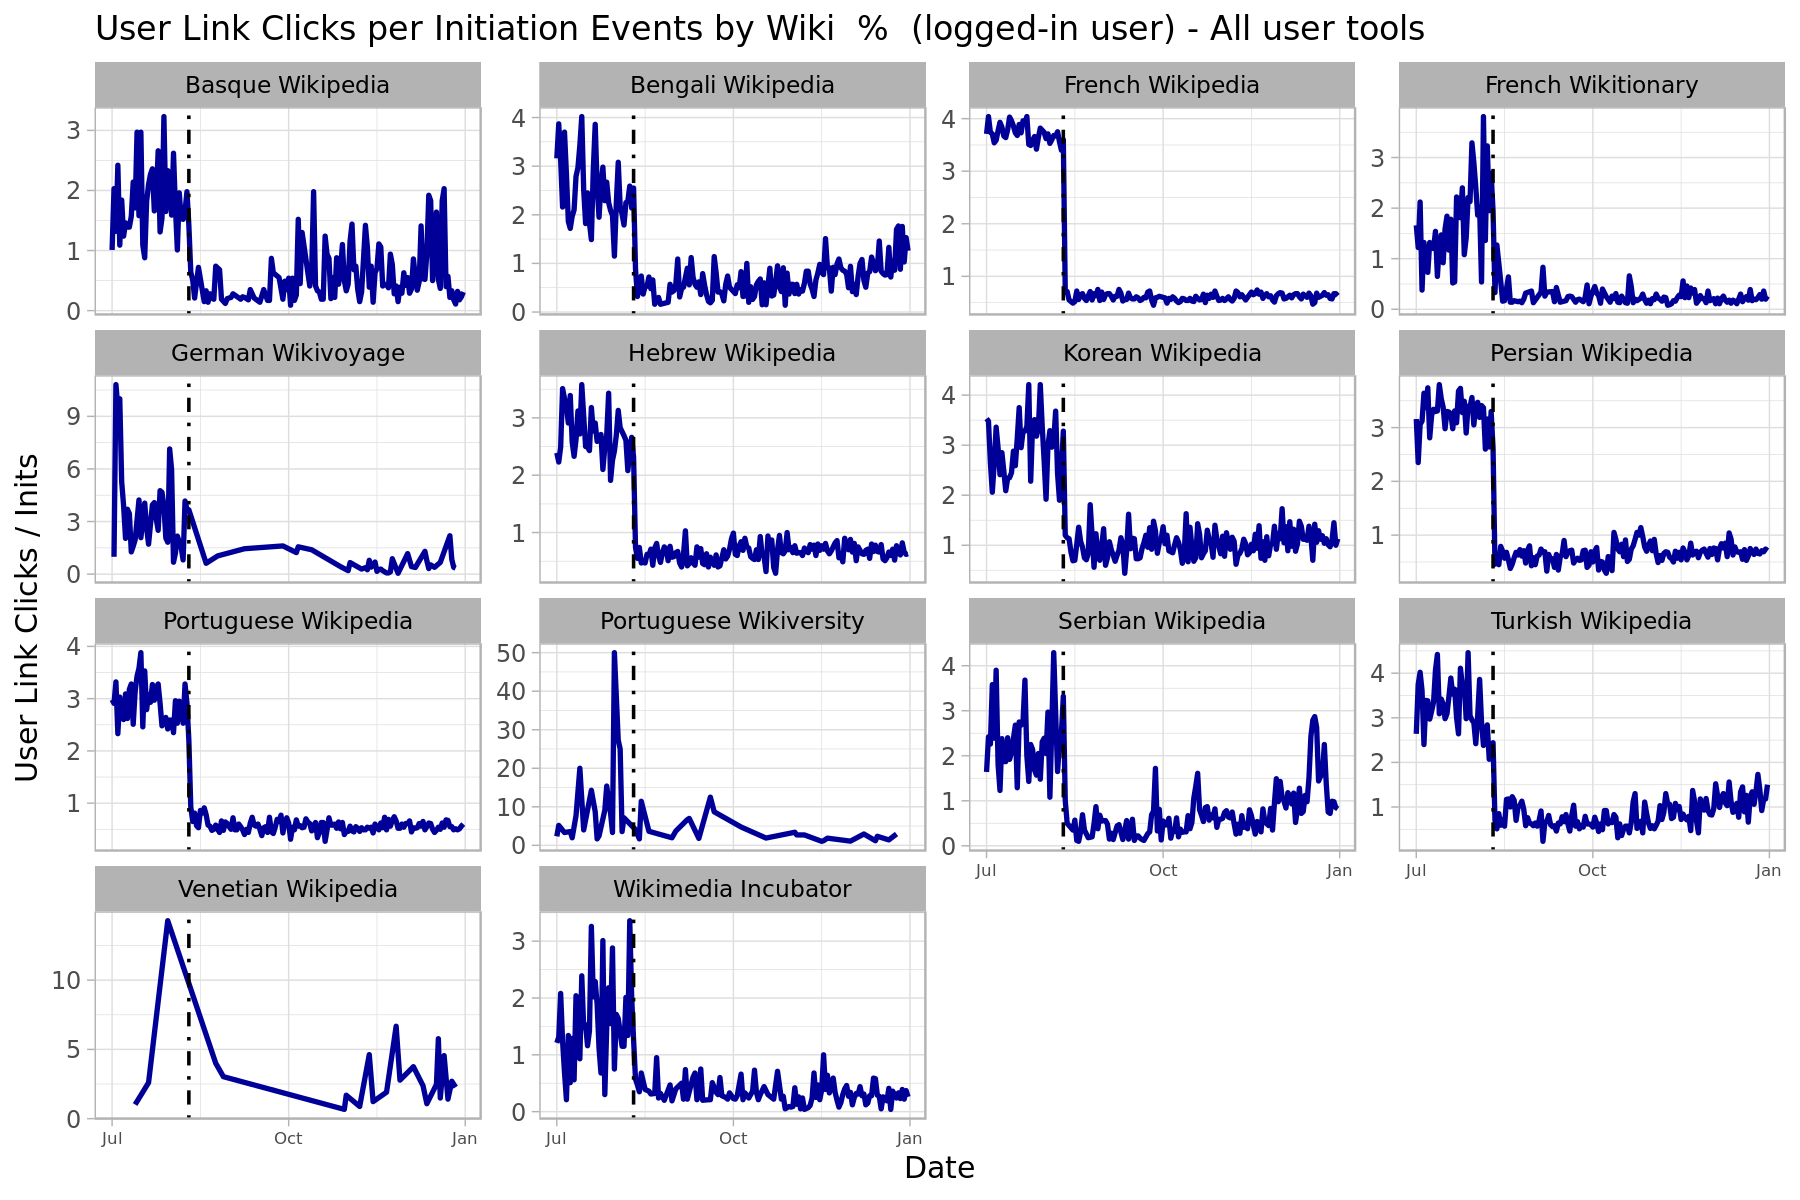

In [134]:
wiki_g <- ggplot(data=df_wiki,
                                mapping=aes(x=event_date)) +
geom_line(aes(y=clicks_per_inits), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~wiki_name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks per Initiation Events by Wiki  %  (logged-in user) - All user tools ',
     x = 'Date',
     y = 'User Link Clicks / Inits ') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
wiki_g 

## By user tool

In [24]:
df_tool <- df_user_link_clicks %>%
    filter((isanon=='false') & (name!='ui.dropdown-p-personal')) %>%
    group_by(name, event_date) %>%
    summarize(user_link_clicks=sum(clicks, na.rm=TRUE), .groups='drop')


In [132]:
df_init_tool <-   df_init_events %>%
    group_by(event_date) %>%
    summarize(sum_inits=sum(init_events)) %>%
    right_join(df_tool,  by ='event_date') %>%
    mutate(clicks_per_inits=round((user_link_clicks/sum_inits)* 100 , 2))

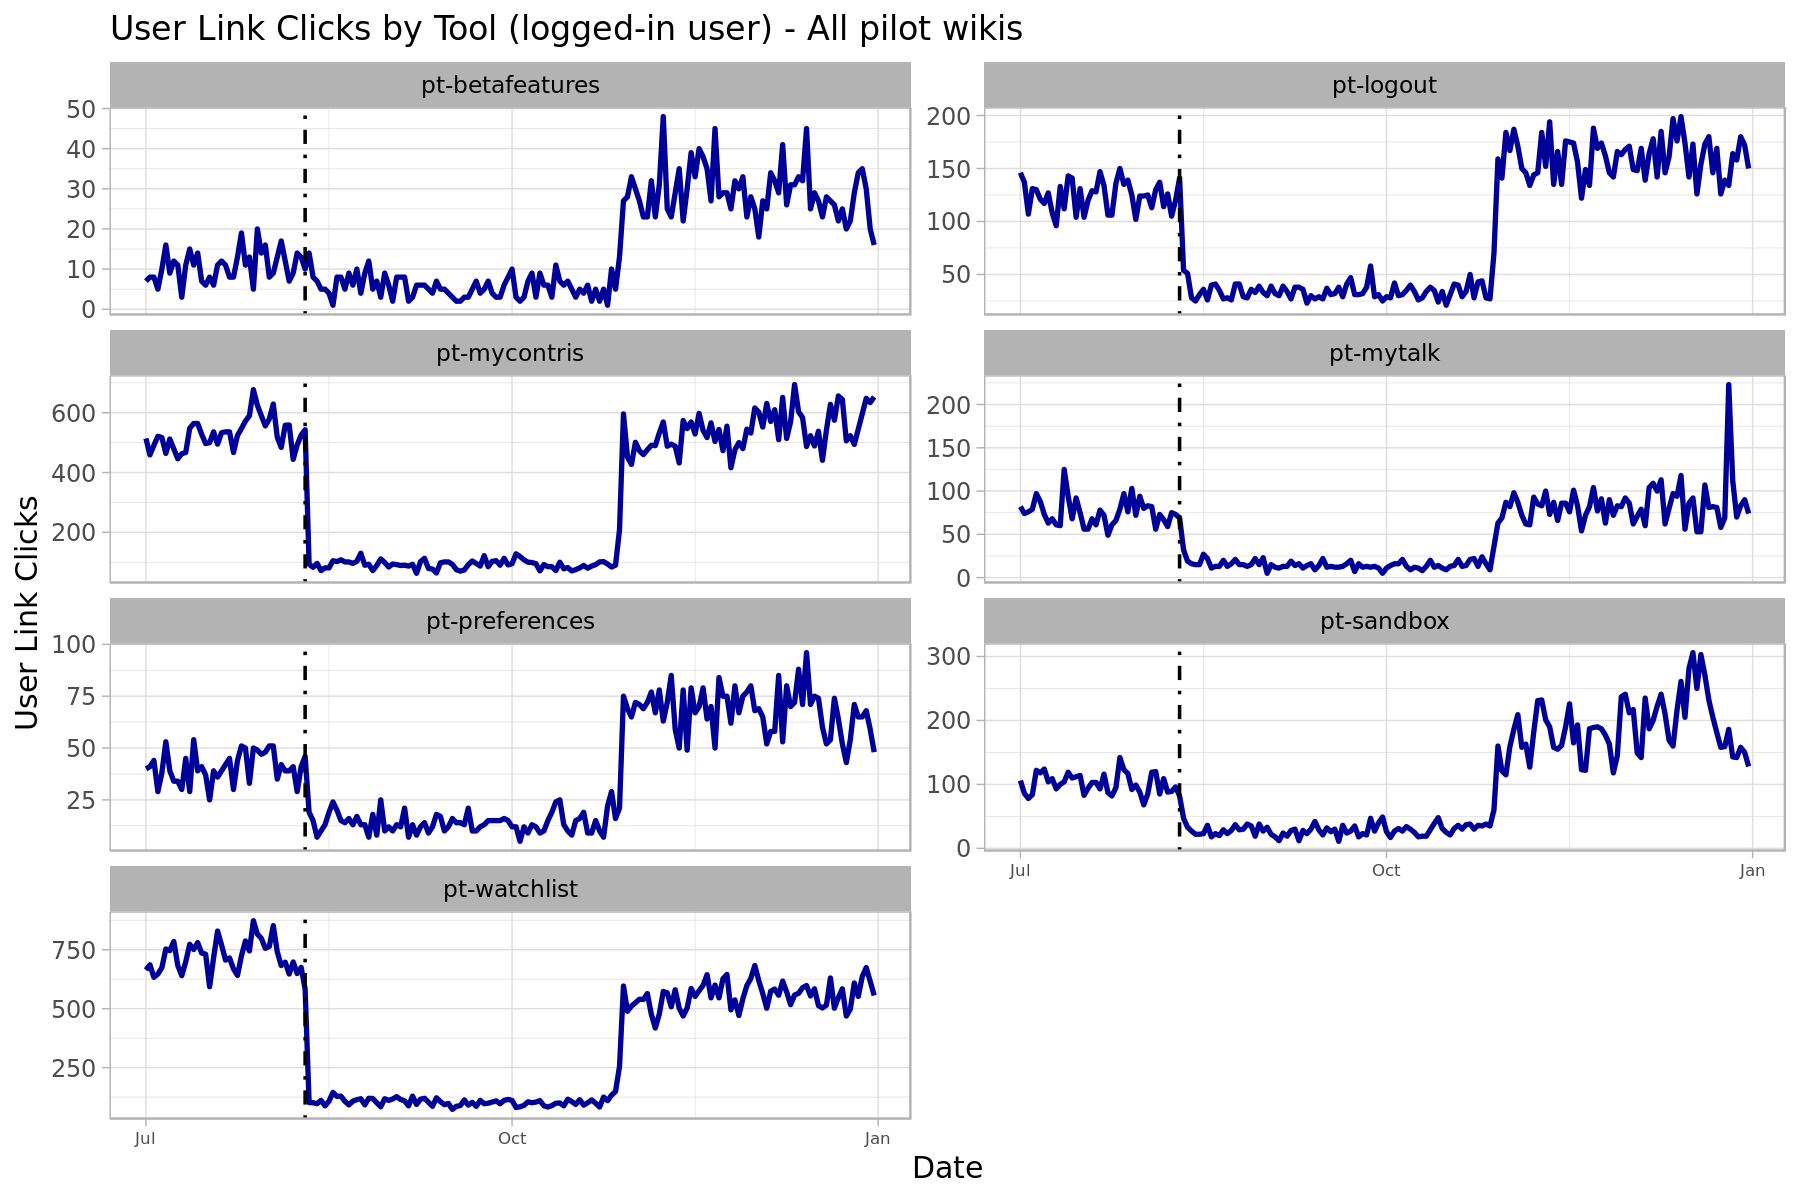

In [26]:
tool_g <- ggplot(data=df_tool,
                                mapping=aes(x=event_date)) +
geom_line(aes(y=user_link_clicks ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks by Tool (logged-in user) - All pilot wikis ',
     x = 'Date',
     y = 'User Link Clicks') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
tool_g 

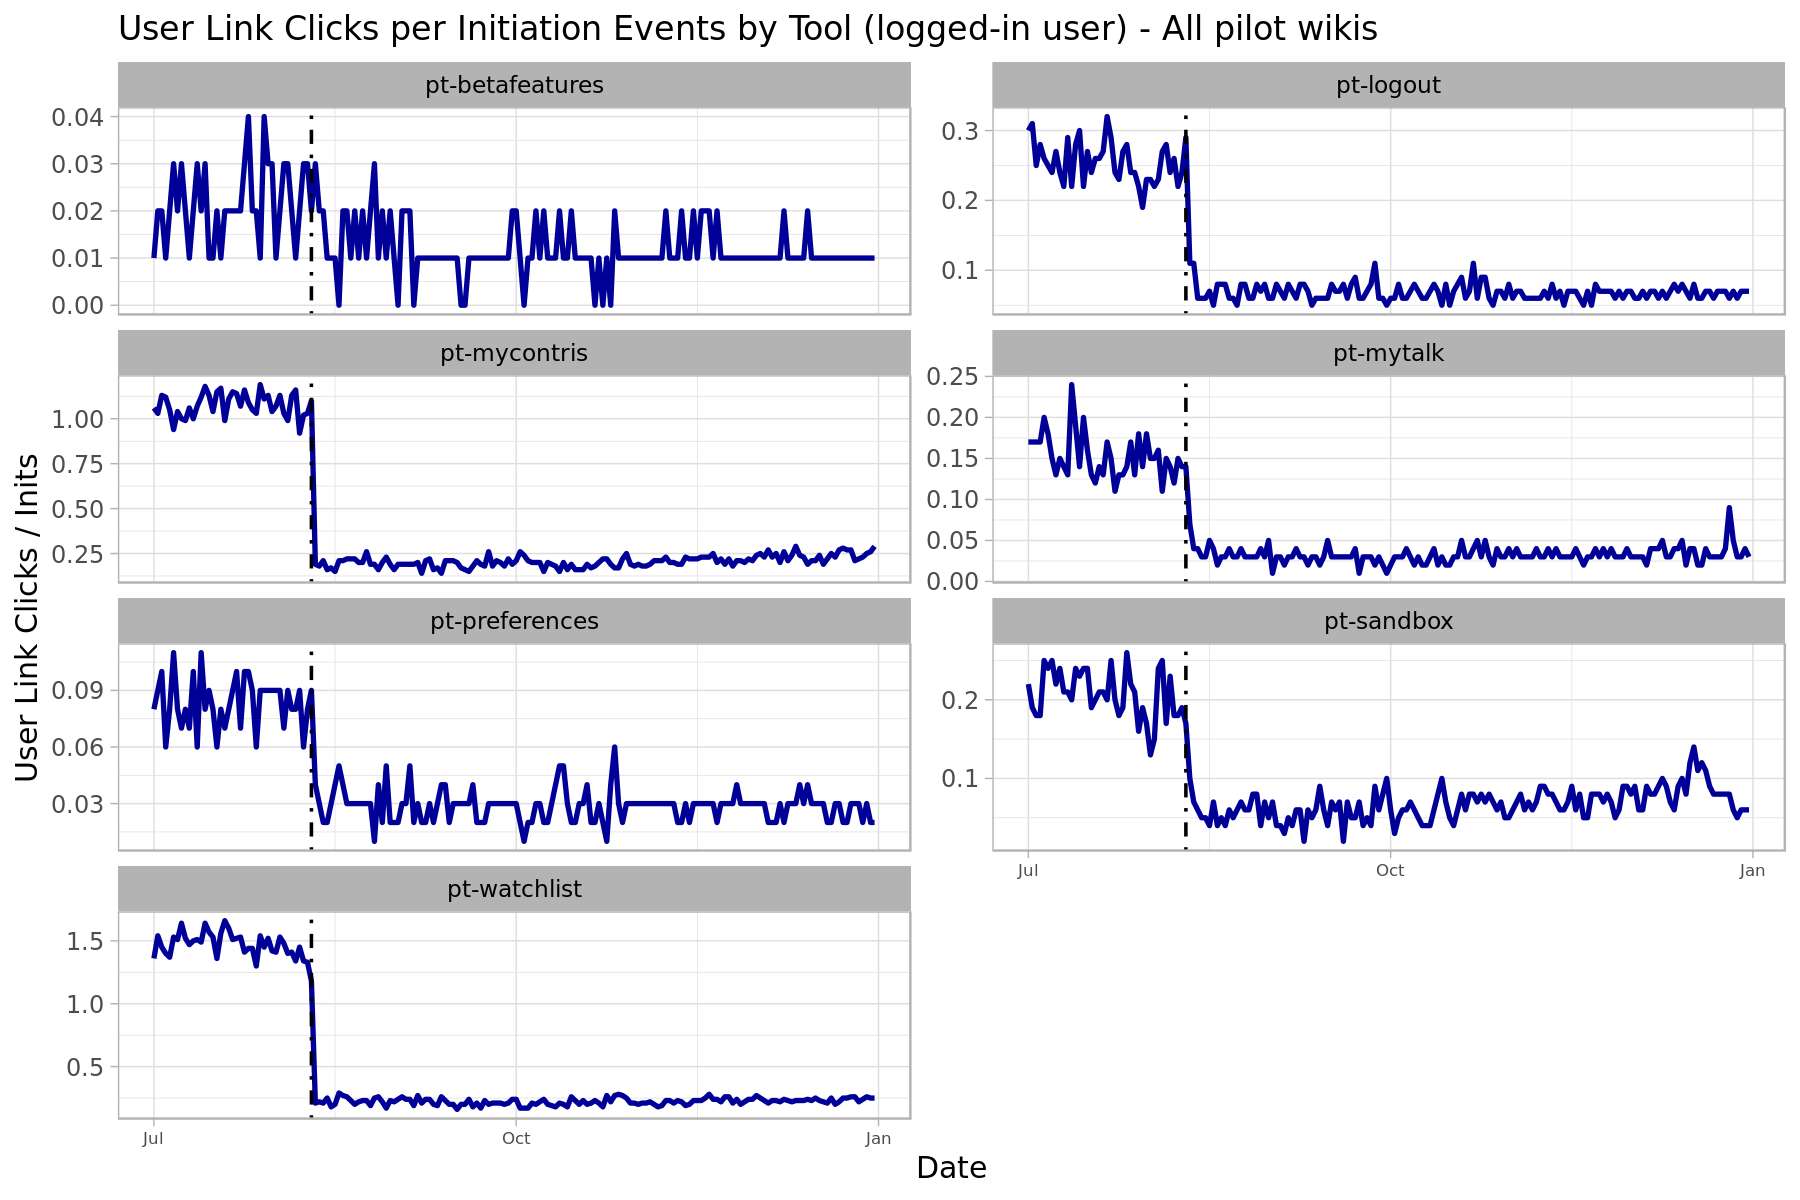

In [149]:
tool_g2 <- ggplot(data=df_init_tool,
                                mapping=aes(x=event_date)) +
geom_line(aes(y=clicks_per_inits ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~name,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks per Initiation Events by Tool (logged-in user) - All pilot wikis ',
     x = 'Date',
     y = 'User Link Clicks / Inits ') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
tool_g2 

__Summary__:

- The user link clicks dropped since the user menu was deployed on 2021-08-10. It is expected. 
- The jump in Oct 28, 2021 is due to the change of sampling rate. https://phabricator.wikimedia.org/T292588


# Comparison of Pre and Post Deployment

In [138]:
# add column classifying pre and post deployment dates
df_user_link_clicks_prepost <- df_user_link_clicks %>%
    mutate(deployment = case_when(
        event_date >= '2021-07-13' & event_date <= '2021-08-09'  ~ 'pre',
        event_date >= '2021-08-10' & event_date <= '2021-09-06'  ~ 'post',      
        TRUE ~ 'NA'
    ))   %>%
    filter((deployment!='NA')&(isanon=='false')& (name!='ui.dropdown-p-personal')) %>%
    group_by(wiki_name,wiki, deployment, name,isanon) %>%
    summarize(sum_clicks = sum(clicks),  .groups = 'drop')

In [146]:

df_init_click_prepost <- df_init_events %>%
    mutate(deployment = case_when(
        event_date >= '2021-07-13' & event_date <= '2021-08-09'  ~ 'pre',
        event_date >= '2021-08-10' & event_date <= '2021-09-06'  ~ 'post',      
        TRUE ~ 'NA'
    ))   %>%
    filter(deployment!='NA') %>%
    group_by(wiki, deployment) %>%
    summarize(sum_inits = sum(init_events),  .groups = 'drop') %>%
    left_join(df_user_link_clicks_prepost, by=c('wiki','deployment')) %>% 
     mutate(clicks_per_inits=round((sum_clicks/sum_inits)* 100 , 2))

In [148]:
df_init_click_prepost$deployment <- factor(df_init_click_prepost$deployment,levels = c("pre", "post"))

## Watchlist

In [150]:
watchlist_clicks_barchart <- df_init_click_prepost %>%
        filter(name=='pt-watchlist') %>%
        ggplot(aes(x = deployment, y= clicks_per_inits, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(clicks_per_inits)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "User link clicks / Inits",
             title = "User link clicks per initiation events before and after deployment -- Watchlist",
             caption = "User type: logged-in User with new skin version ") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
           # axis.title.x=element_blank(),
           # axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

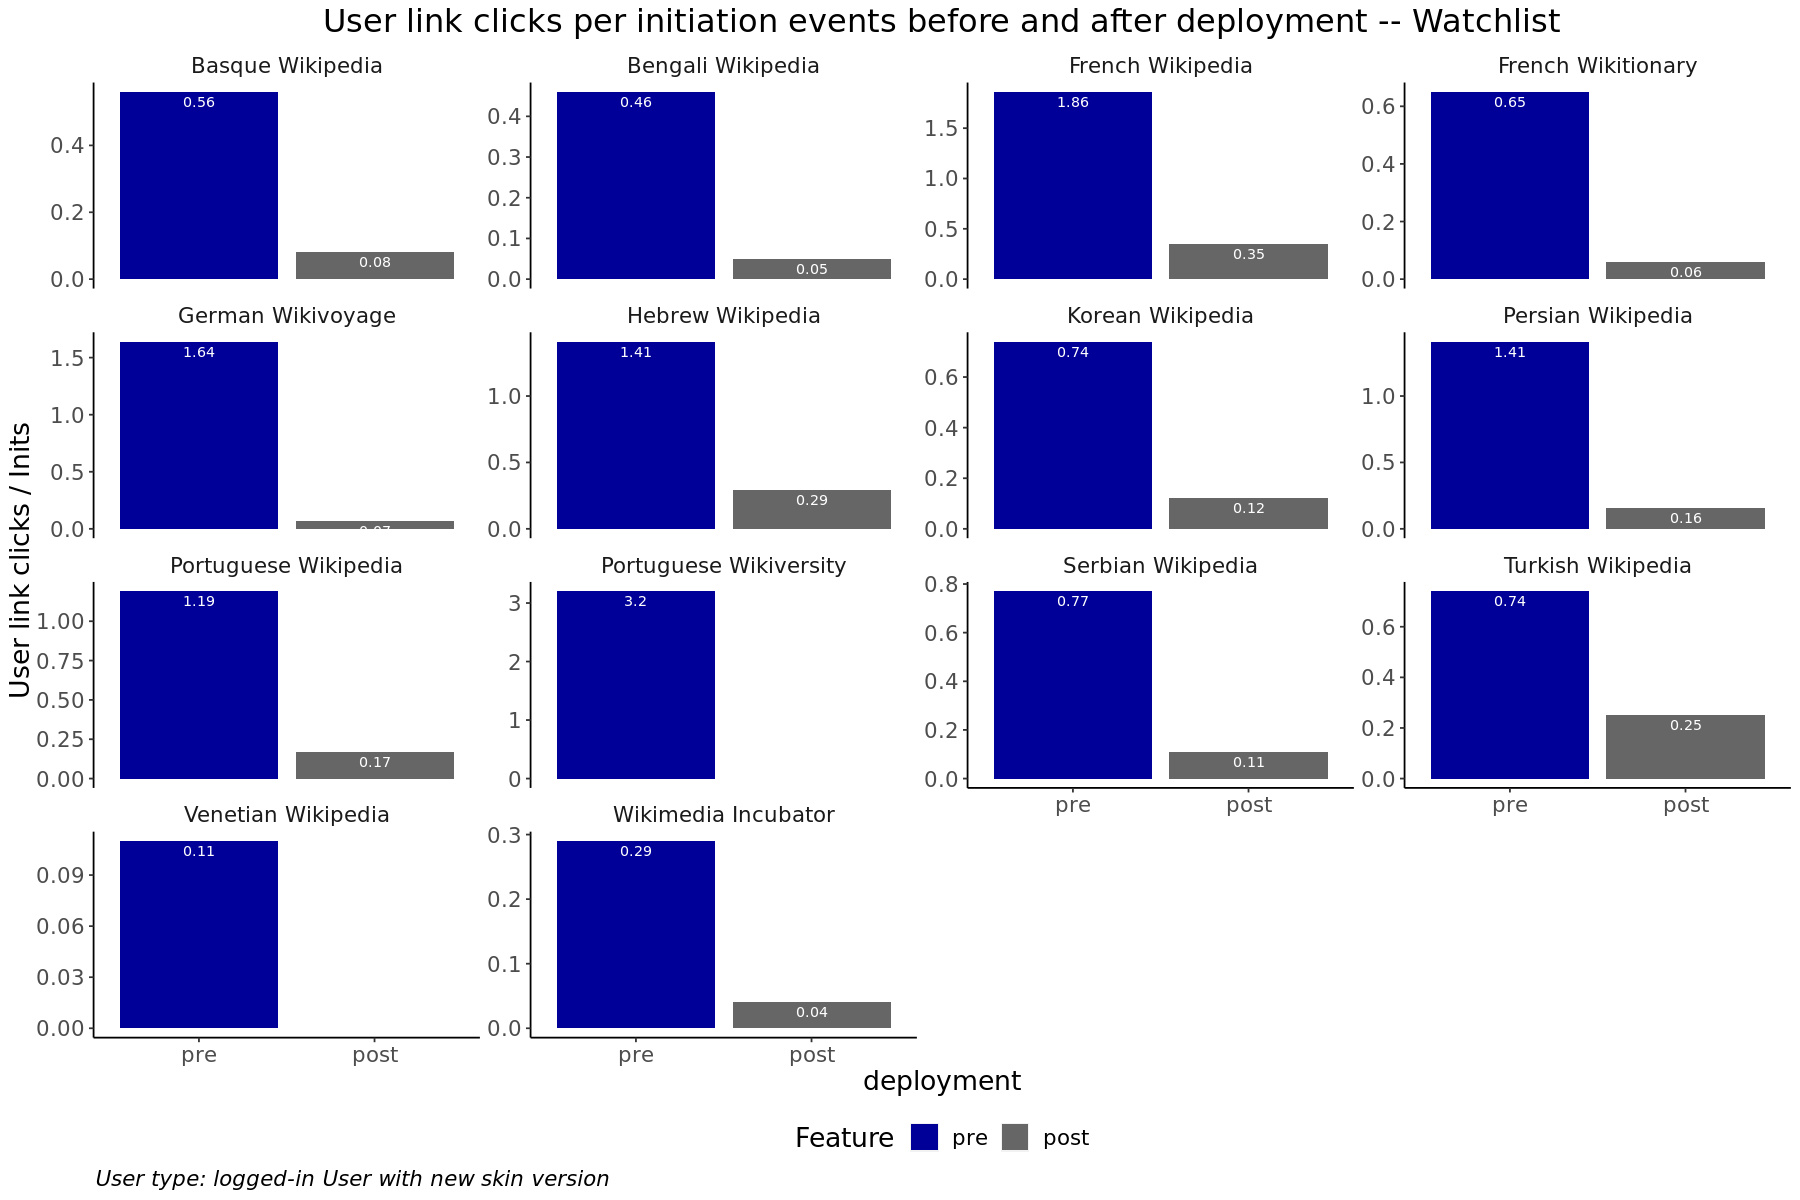

In [151]:
watchlist_clicks_barchart

__Determin the percentage of changes__

In [152]:
# determine percent change

df_watchlist_clicks_prepost_w <- df_init_click_prepost %>%
  filter(name=='pt-watchlist') %>%
  select(wiki_name, deployment,clicks_per_inits) %>%
  pivot_wider(names_from = deployment, values_from = clicks_per_inits) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

In [153]:
df_watchlist_clicks_prepost_w

wiki_name              post pre  pct_change
1  Bengali Wikipedia      0.05 0.46 -89.13    
2  German Wikivoyage      0.07 1.64 -95.73    
3  Basque Wikipedia       0.08 0.56 -85.71    
4  Persian Wikipedia      0.16 1.41 -88.65    
5  French Wikipedia       0.35 1.86 -81.18    
6  French Wikitionary     0.06 0.65 -90.77    
7  Hebrew Wikipedia       0.29 1.41 -79.43    
8  Wikimedia Incubator    0.04 0.29 -86.21    
9  Korean Wikipedia       0.12 0.74 -83.78    
10 Portuguese Wikipedia   0.17 1.19 -85.71    
11 Portuguese Wikiversity   NA 3.20     NA    
12 Serbian Wikipedia      0.11 0.77 -85.71    
13 Turkish Wikipedia      0.25 0.74 -66.22    
14 Venetian Wikipedia       NA 0.11     NA

Warning message:
“Removed 2 rows containing missing values (geom_pointrange).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”


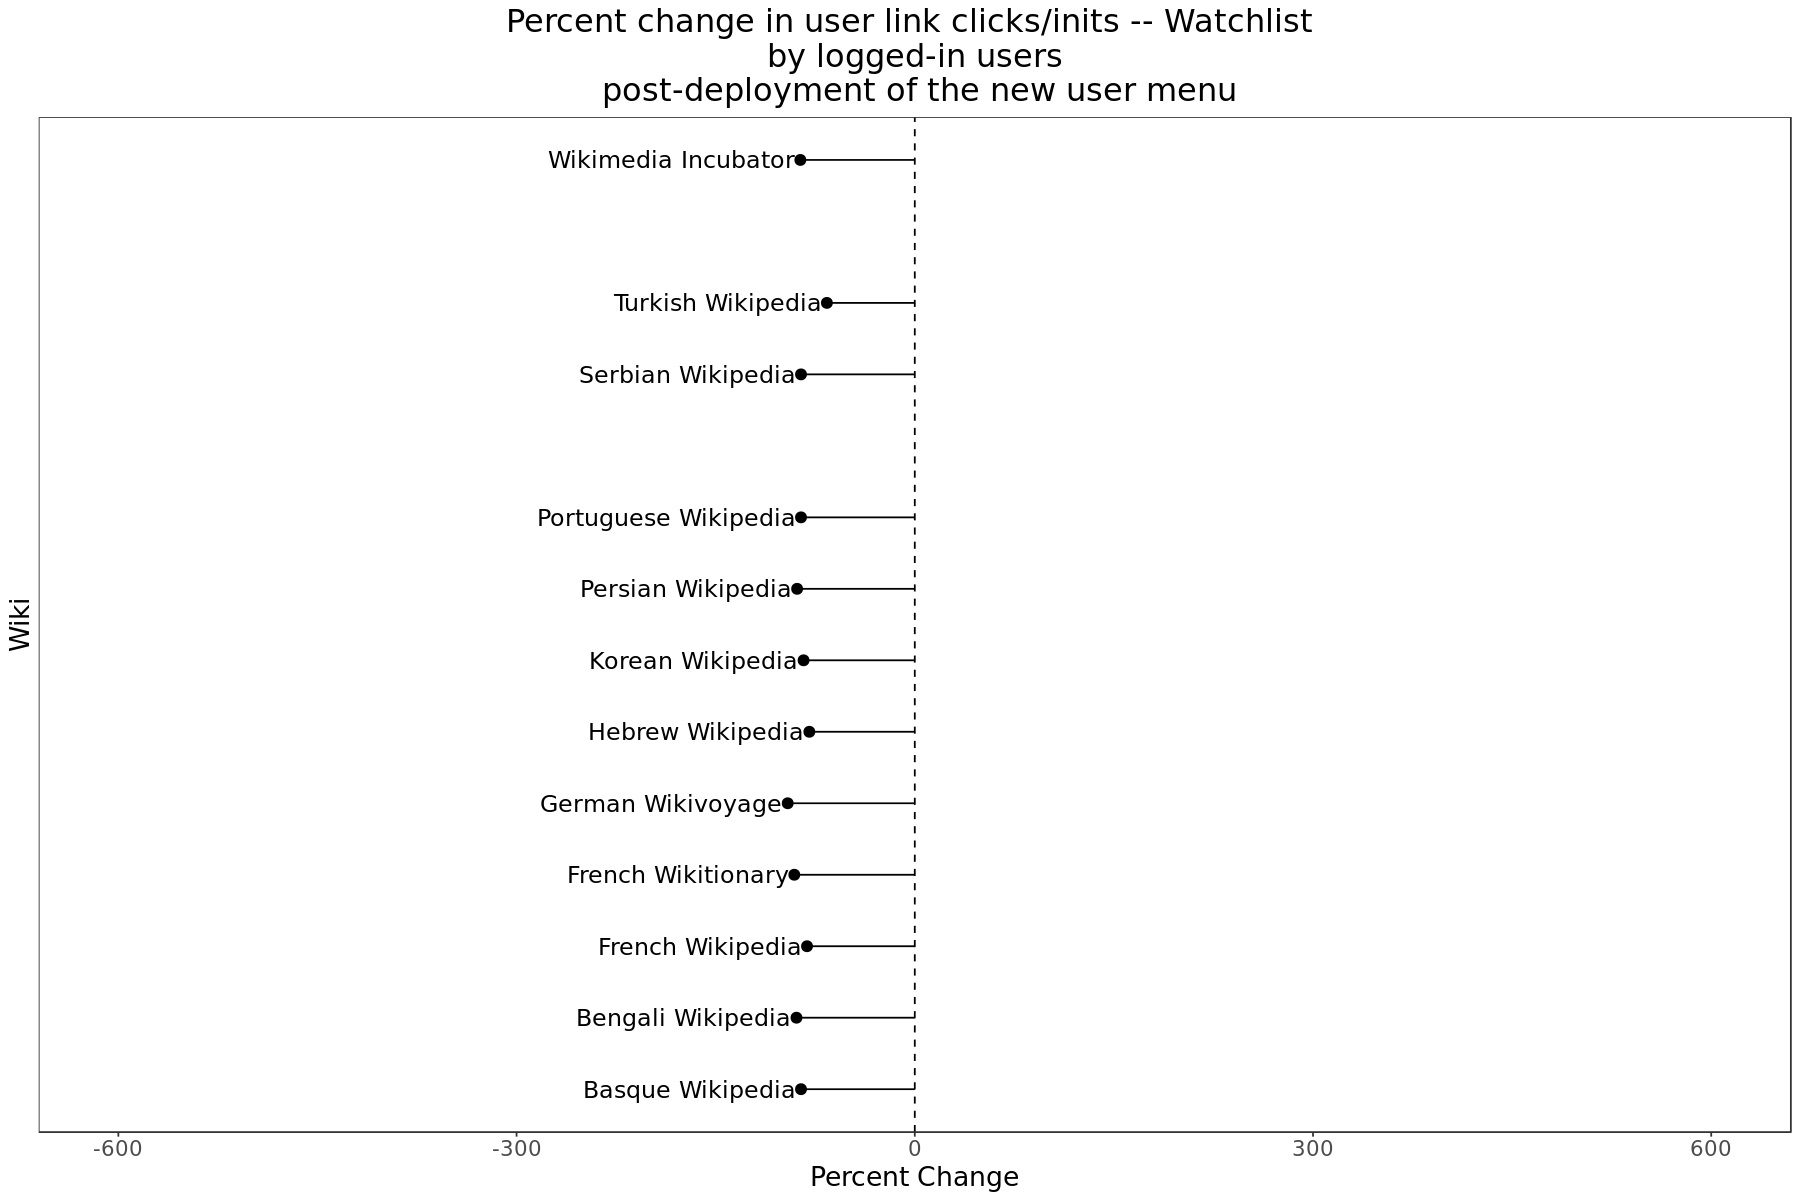

In [154]:
# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_watchlist_g <- df_watchlist_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in user link clicks/inits -- Watchlist \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_watchlist_g 



__Average percent change__


Average of the percent changes observed on each early adopter wiki

In [155]:
mean((filter(df_watchlist_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] -84.8525

## Talk


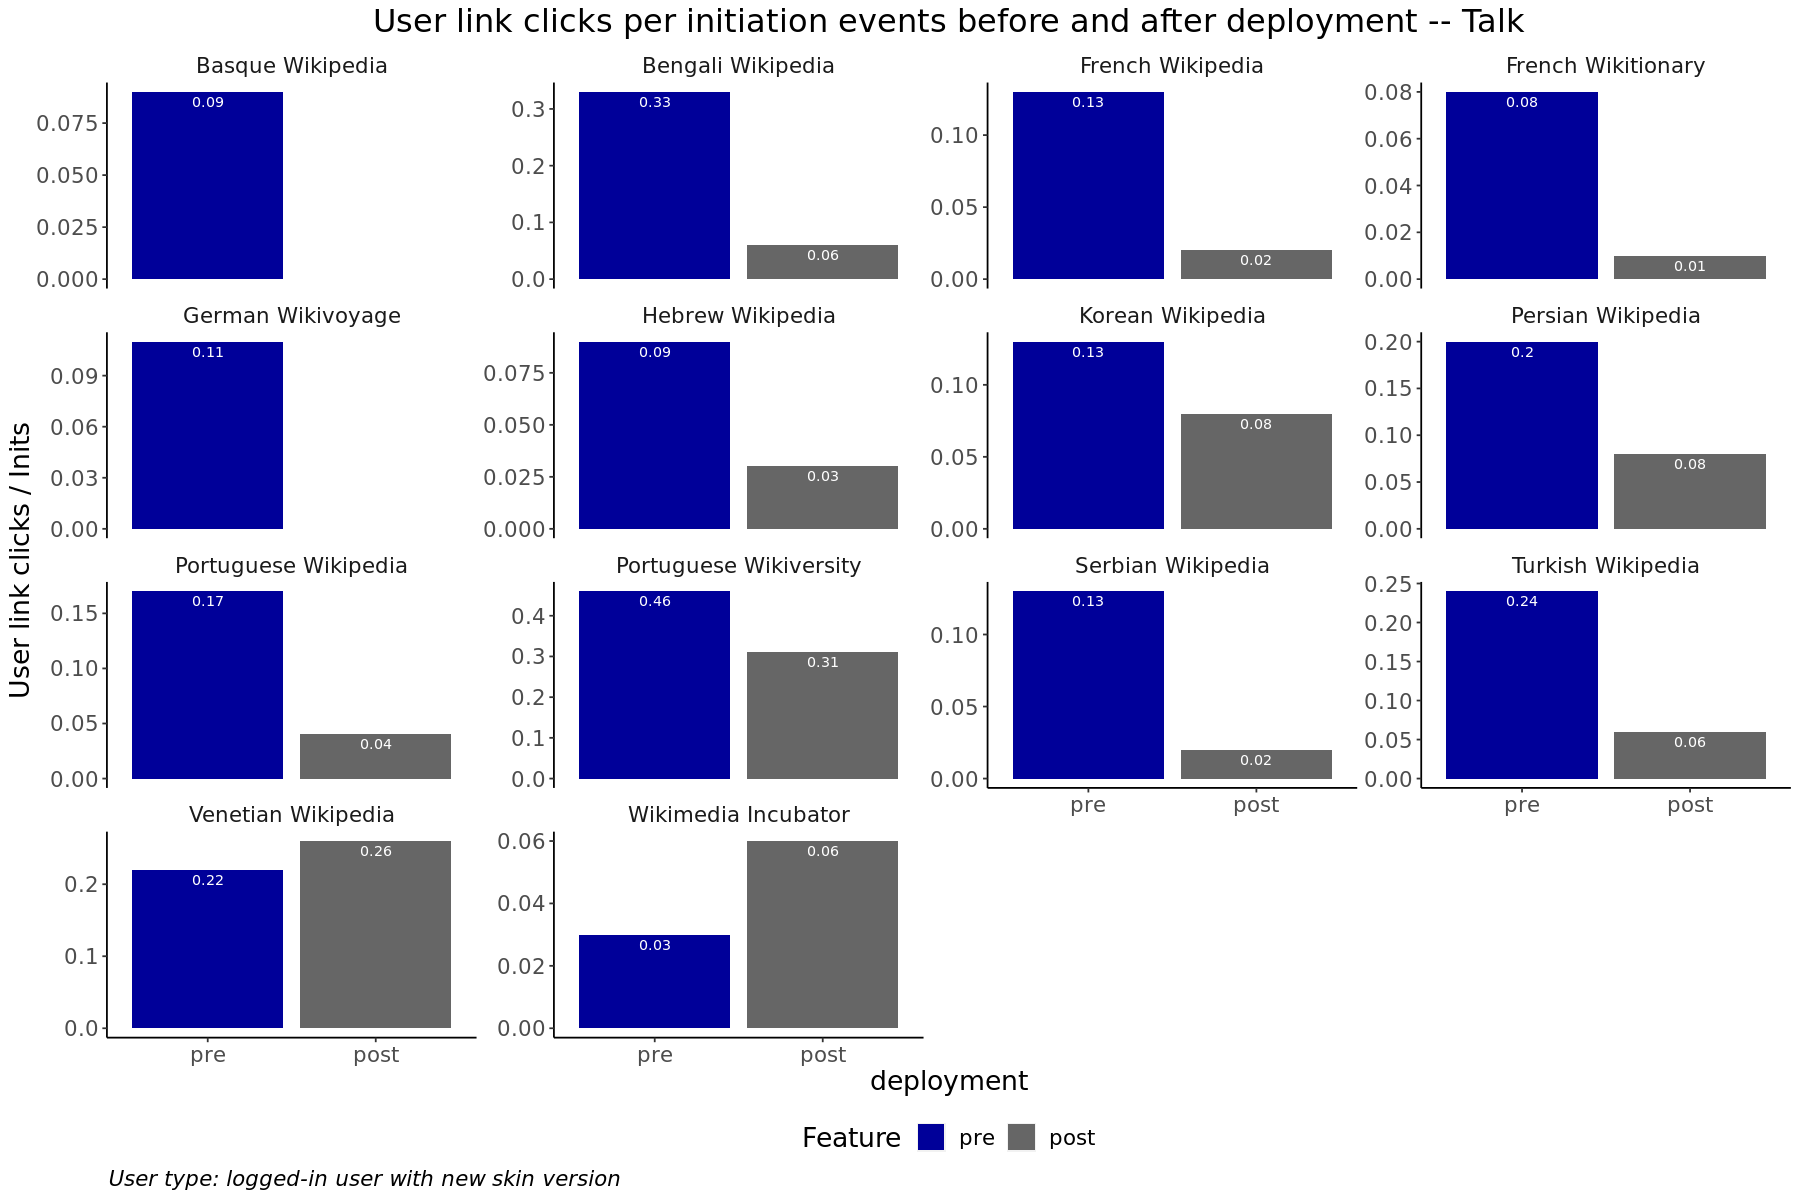

In [156]:
talk_clicks_barchart <- df_init_click_prepost %>%
        filter(name=='pt-mytalk') %>%
        ggplot(aes(x = deployment, y= clicks_per_inits, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(clicks_per_inits)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "User link clicks / Inits",
             title = "User link clicks per initiation events before and after deployment -- Talk",
             caption = "User type: logged-in user with new skin version ") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

talk_clicks_barchart

__Determin the percentage of changes__

In [159]:
# determine percent change

df_talk_clicks_prepost_w <- df_init_click_prepost %>%
  filter(name=='pt-mytalk') %>%
  select(wiki_name, deployment,clicks_per_inits) %>%
  pivot_wider(names_from = deployment, values_from = clicks_per_inits) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

df_talk_clicks_prepost_w

wiki_name              post pre  pct_change
1  Bengali Wikipedia      0.06 0.33 -81.82    
2  German Wikivoyage        NA 0.11     NA    
3  Basque Wikipedia         NA 0.09     NA    
4  Persian Wikipedia      0.08 0.20 -60.00    
5  French Wikipedia       0.02 0.13 -84.62    
6  French Wikitionary     0.01 0.08 -87.50    
7  Hebrew Wikipedia       0.03 0.09 -66.67    
8  Wikimedia Incubator    0.06 0.03 100.00    
9  Korean Wikipedia       0.08 0.13 -38.46    
10 Portuguese Wikipedia   0.04 0.17 -76.47    
11 Portuguese Wikiversity 0.31 0.46 -32.61    
12 Serbian Wikipedia      0.02 0.13 -84.62    
13 Turkish Wikipedia      0.06 0.24 -75.00    
14 Venetian Wikipedia     0.26 0.22  18.18

Warning message:
“Removed 2 rows containing missing values (geom_pointrange).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”


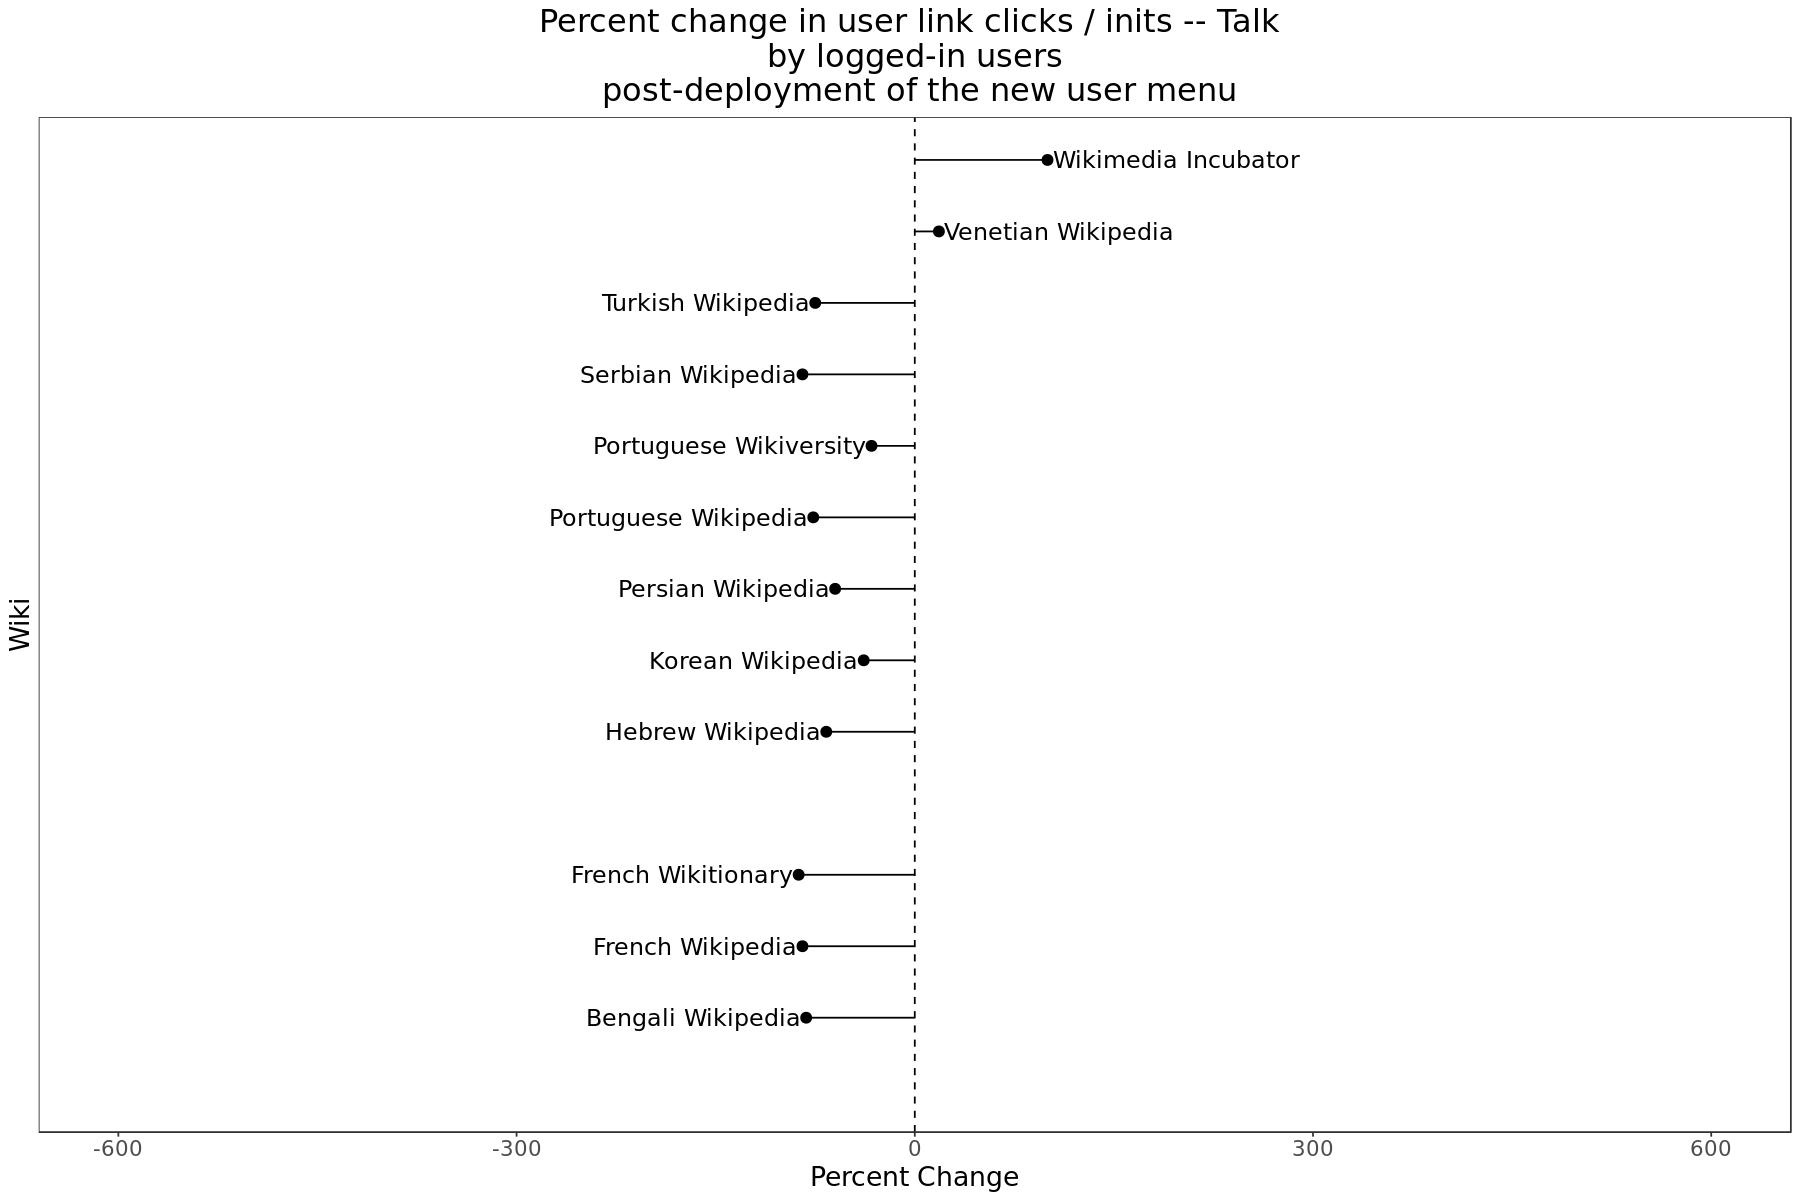

In [161]:
# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_talk_g <- df_talk_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in user link clicks / inits -- Talk \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_talk_g 


__Average percent change__

Average of the percent changes observed on each early adopter wiki

In [162]:
mean((filter(df_talk_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] -47.46583

## Sandbox


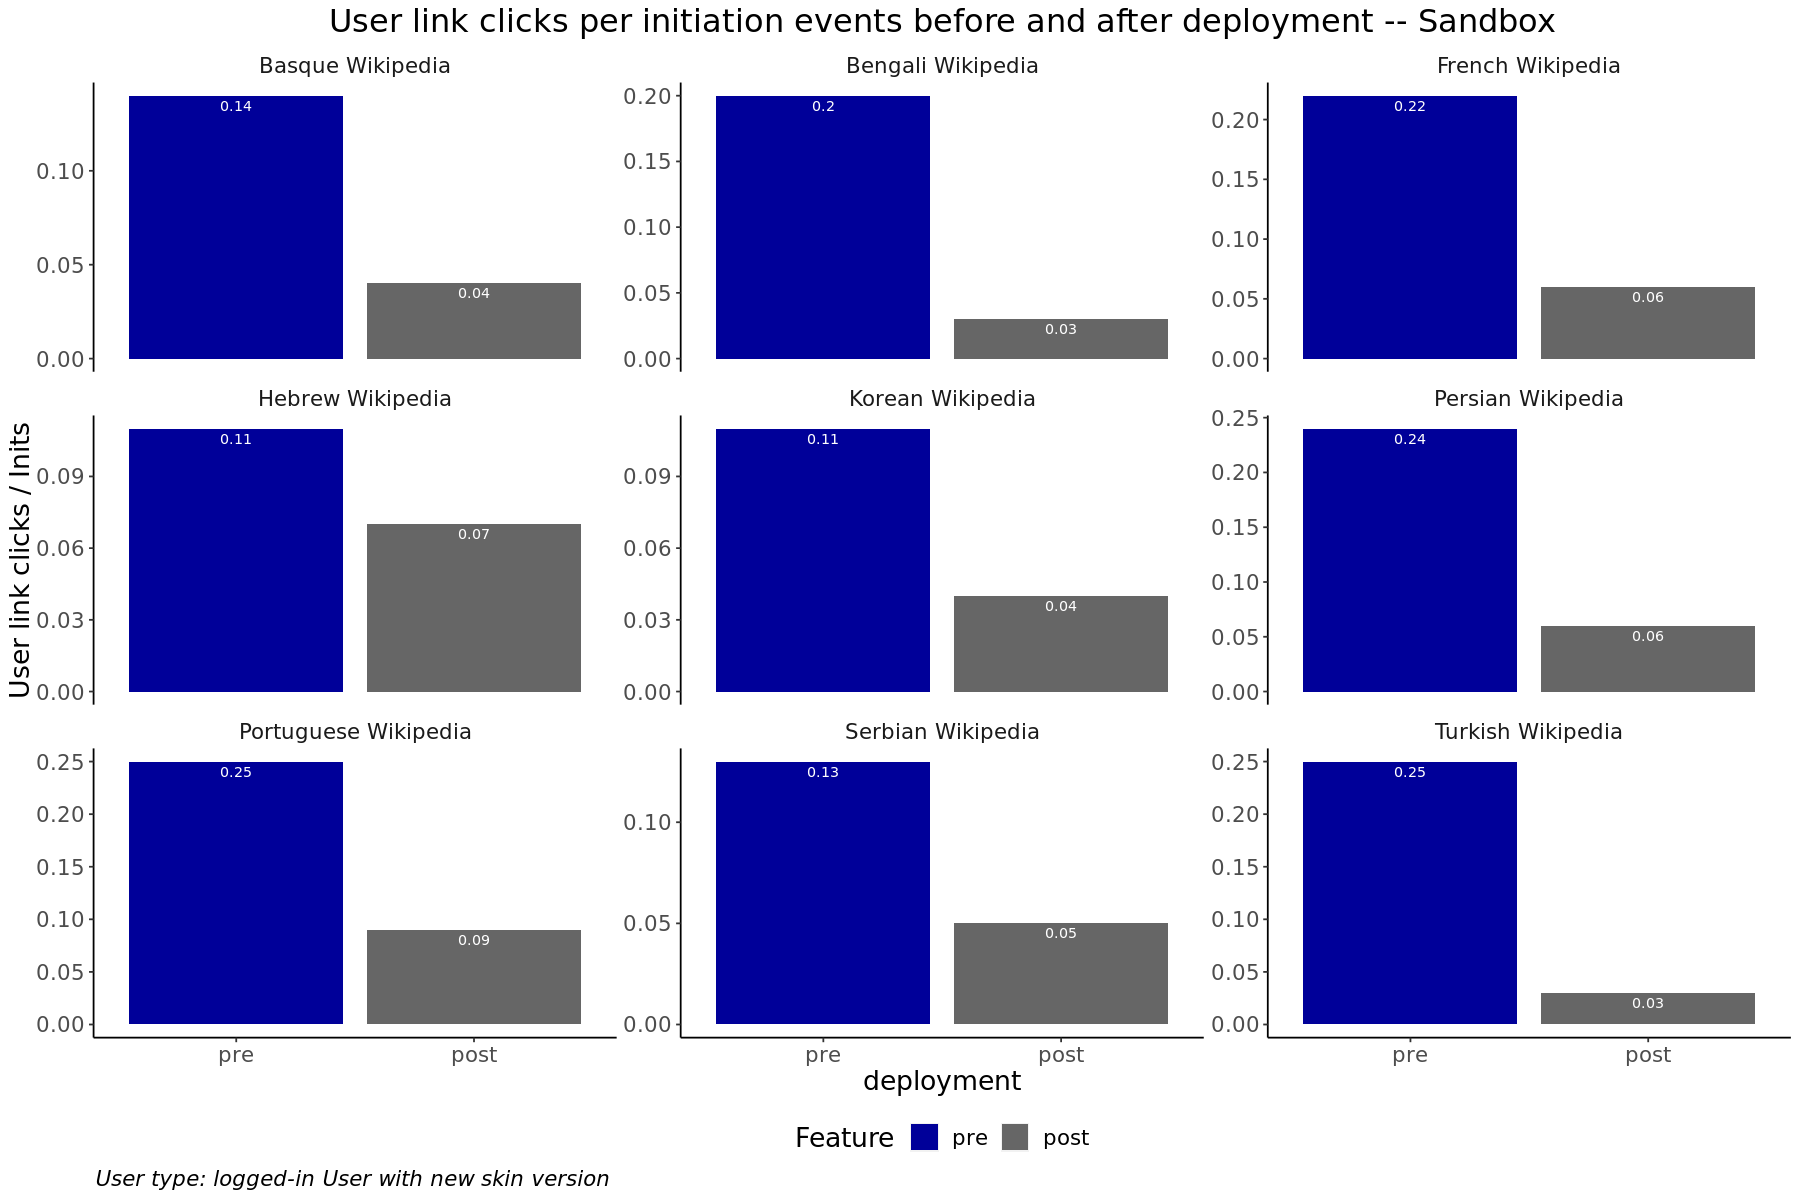

In [163]:
sandbox_clicks_barchart <- df_init_click_prepost %>%
        filter(name=='pt-sandbox') %>%
        ggplot(aes(x = deployment, y= clicks_per_inits, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(clicks_per_inits)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "User link clicks / Inits",
             title = "User link clicks per initiation events before and after deployment -- Sandbox",
             caption = "User type: logged-in User with new skin version") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

sandbox_clicks_barchart



__Determin the percentage of changes__


In [164]:

# determine percent change

df_sandbox_clicks_prepost_w <- df_init_click_prepost %>%
  filter(name=='pt-sandbox') %>%
  select(wiki_name, deployment,clicks_per_inits) %>%
  pivot_wider(names_from = deployment, values_from =clicks_per_inits) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

df_sandbox_clicks_prepost_w


wiki_name            post pre  pct_change
1 Bengali Wikipedia    0.03 0.20 -85.00    
2 Basque Wikipedia     0.04 0.14 -71.43    
3 Persian Wikipedia    0.06 0.24 -75.00    
4 French Wikipedia     0.06 0.22 -72.73    
5 Hebrew Wikipedia     0.07 0.11 -36.36    
6 Korean Wikipedia     0.04 0.11 -63.64    
7 Portuguese Wikipedia 0.09 0.25 -64.00    
8 Serbian Wikipedia    0.05 0.13 -61.54    
9 Turkish Wikipedia    0.03 0.25 -88.00

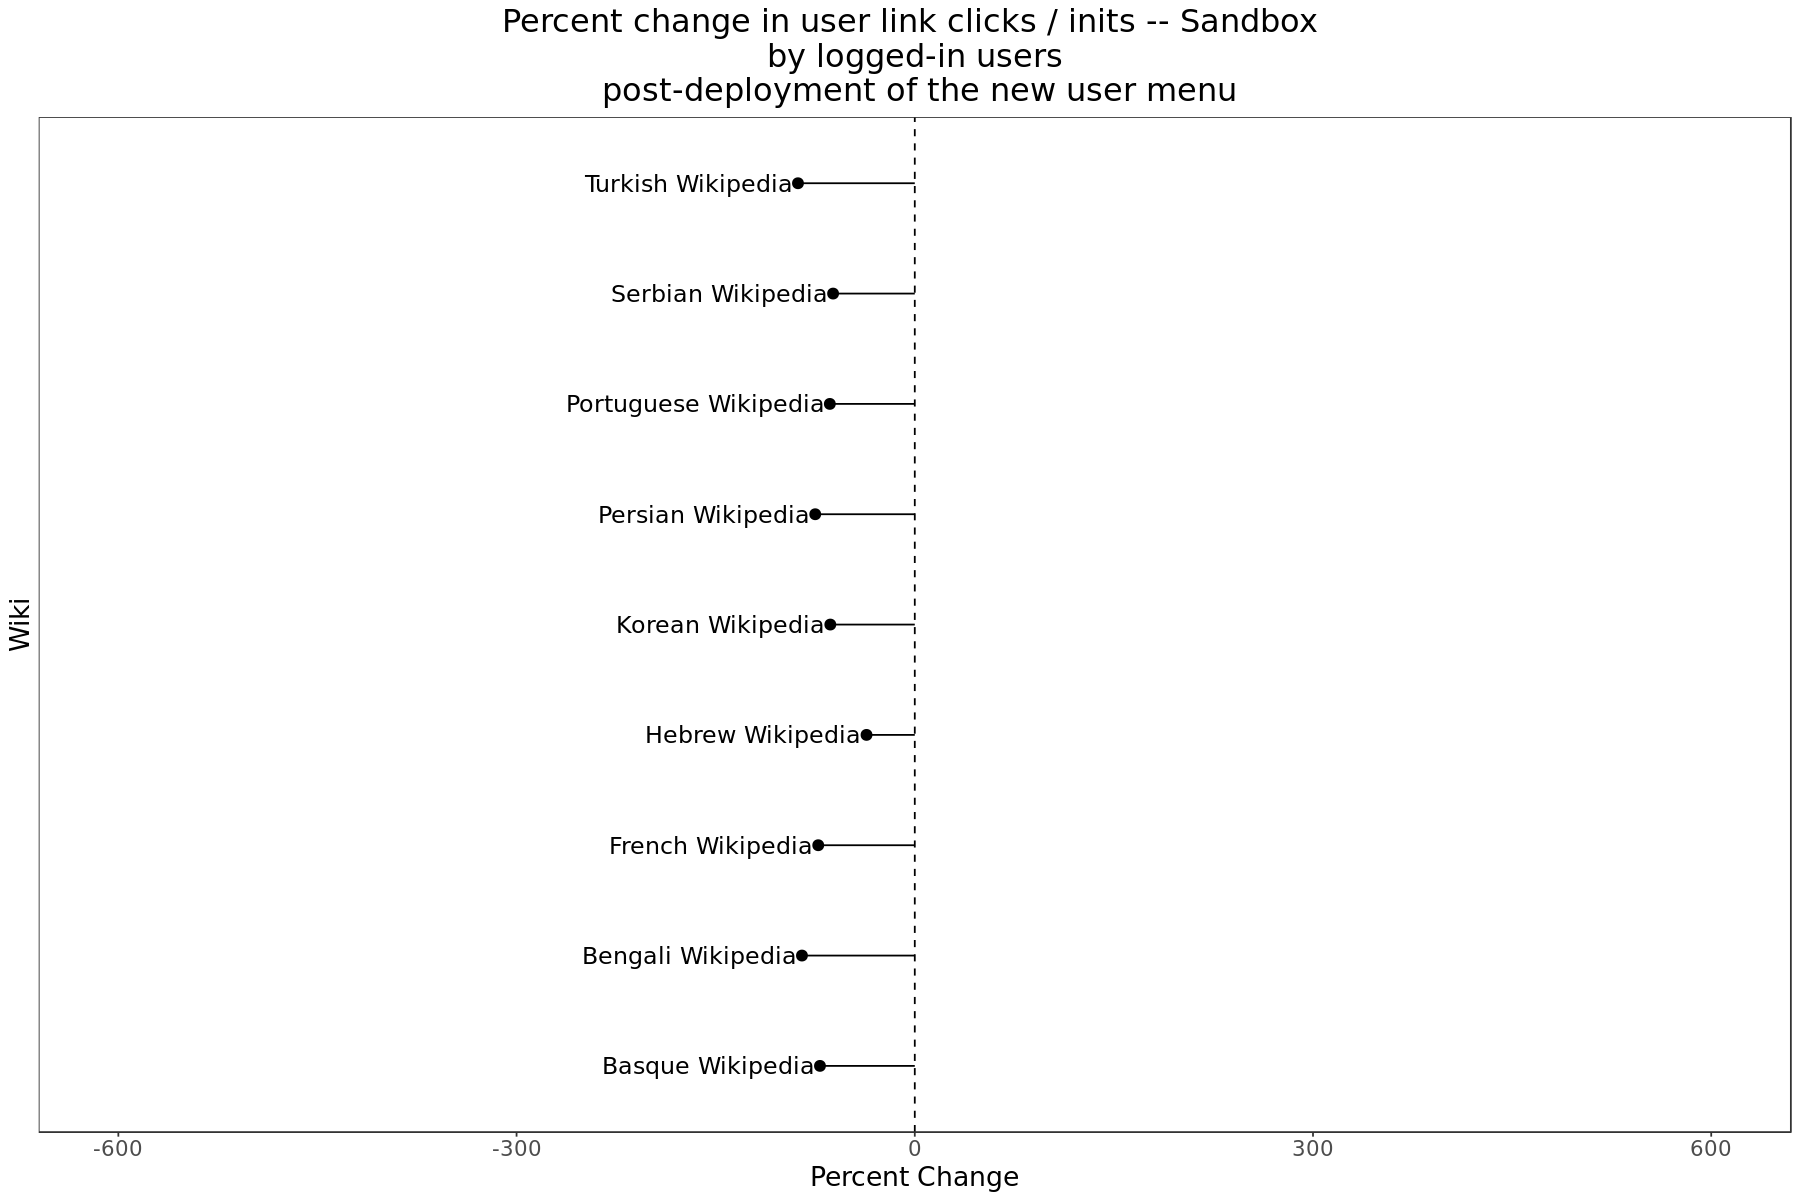

In [165]:

# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_sandbox_g <- df_sandbox_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in user link clicks / inits -- Sandbox \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_sandbox_g 




__Average percent change__

Average of the percent changes observed on each early adopter wiki

In [166]:


mean((filter(df_sandbox_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] -68.63333

## Preferences


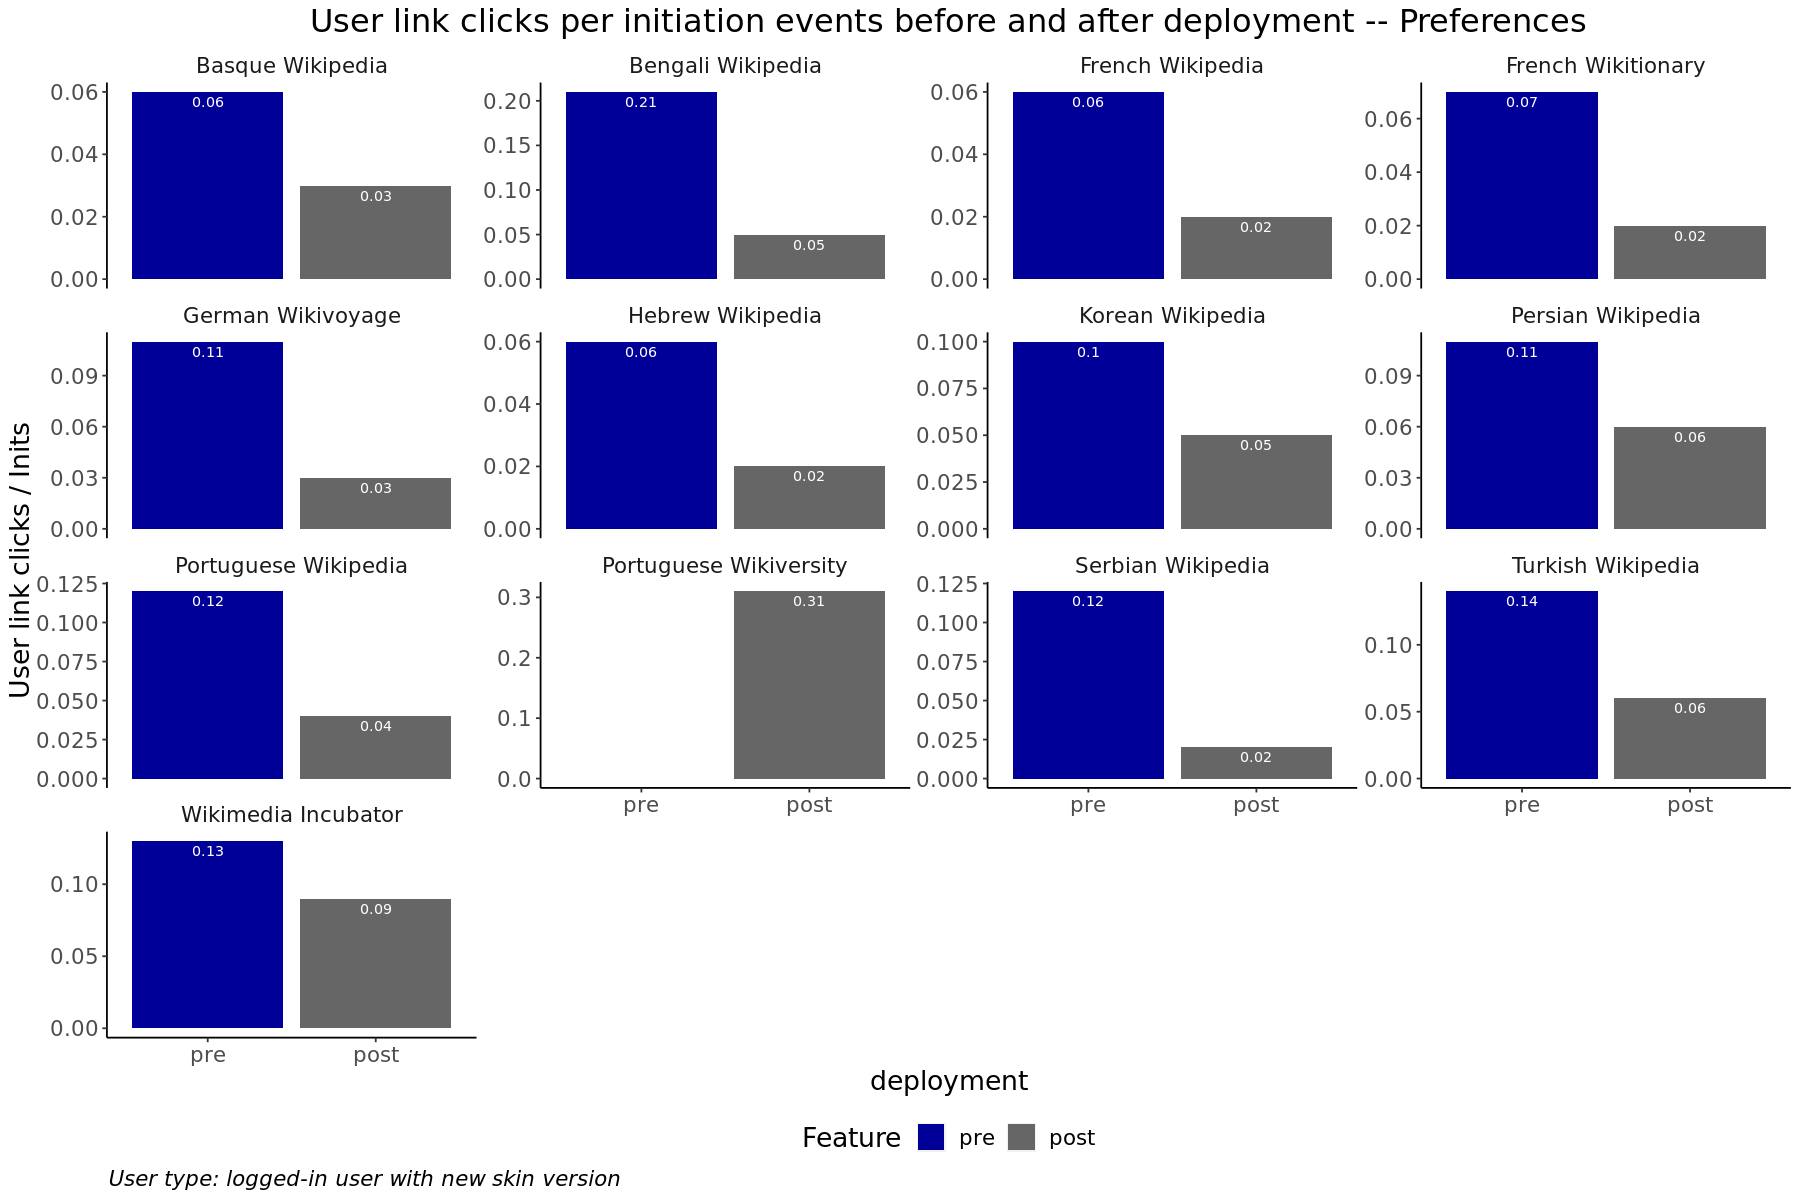

In [167]:
pref_clicks_barchart <- df_init_click_prepost %>%
        filter(name=='pt-preferences') %>%
        ggplot(aes(x = deployment, y= clicks_per_inits, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(clicks_per_inits)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "User link clicks / Inits",
             title = "User link clicks per initiation events before and after deployment -- Preferences",
             caption = "User type: logged-in user with new skin version") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
pref_clicks_barchart

__Determin the percentage of changes__

In [168]:

# determine percent change

df_pref_clicks_prepost_w <- df_init_click_prepost %>%
  filter(name=='pt-preferences') %>%
  select(wiki_name, deployment,clicks_per_inits) %>%
  pivot_wider(names_from = deployment, values_from = clicks_per_inits) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

df_pref_clicks_prepost_w

wiki_name              post pre  pct_change
1  Bengali Wikipedia      0.05 0.21 -76.19    
2  German Wikivoyage      0.03 0.11 -72.73    
3  Basque Wikipedia       0.03 0.06 -50.00    
4  Persian Wikipedia      0.06 0.11 -45.45    
5  French Wikipedia       0.02 0.06 -66.67    
6  French Wikitionary     0.02 0.07 -71.43    
7  Hebrew Wikipedia       0.02 0.06 -66.67    
8  Wikimedia Incubator    0.09 0.13 -30.77    
9  Korean Wikipedia       0.05 0.10 -50.00    
10 Portuguese Wikipedia   0.04 0.12 -66.67    
11 Portuguese Wikiversity 0.31   NA     NA    
12 Serbian Wikipedia      0.02 0.12 -83.33    
13 Turkish Wikipedia      0.06 0.14 -57.14

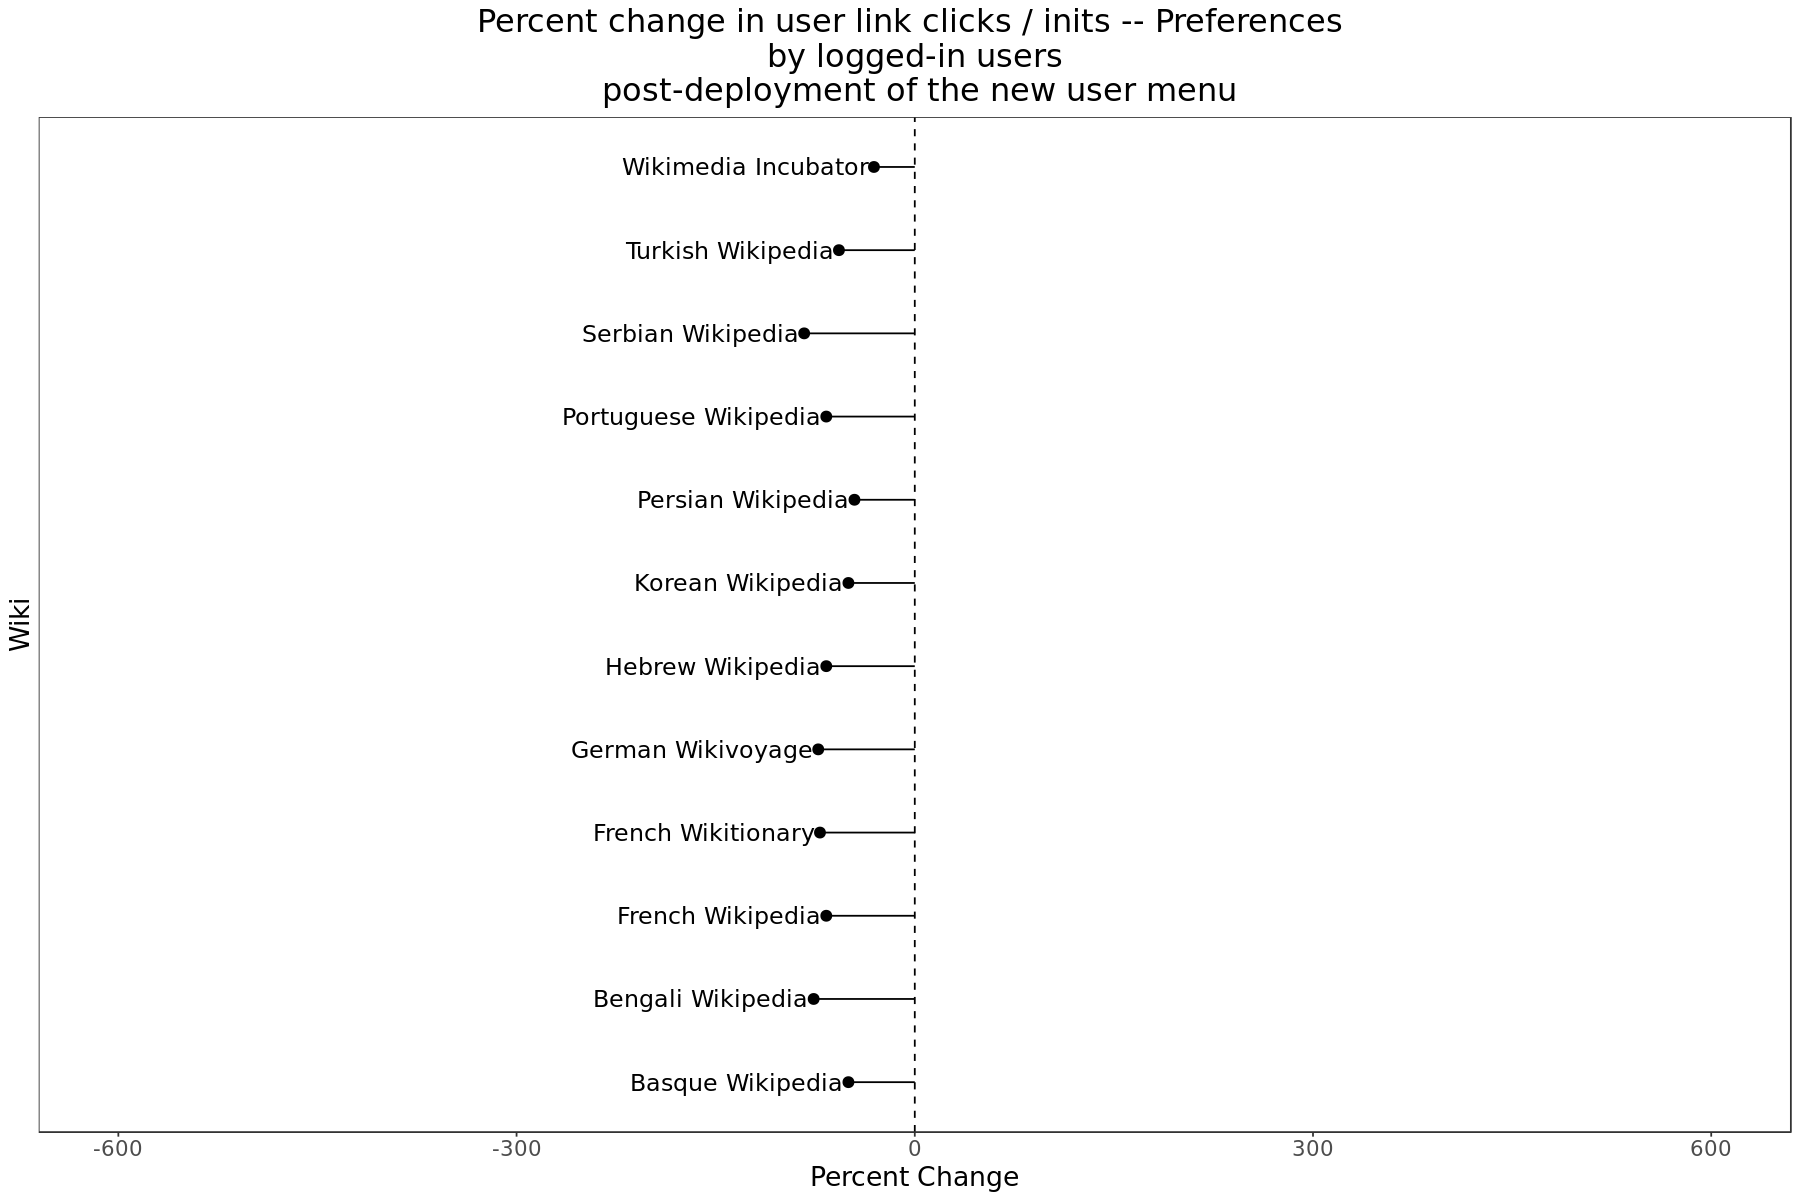

In [169]:
# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_pref_g <- df_pref_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in user link clicks / inits -- Preferences \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_pref_g 






__Average percent change__

Average of the percent changes observed on each early adopter wiki

In [170]:
mean((filter(df_pref_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] -61.42083

## Beta


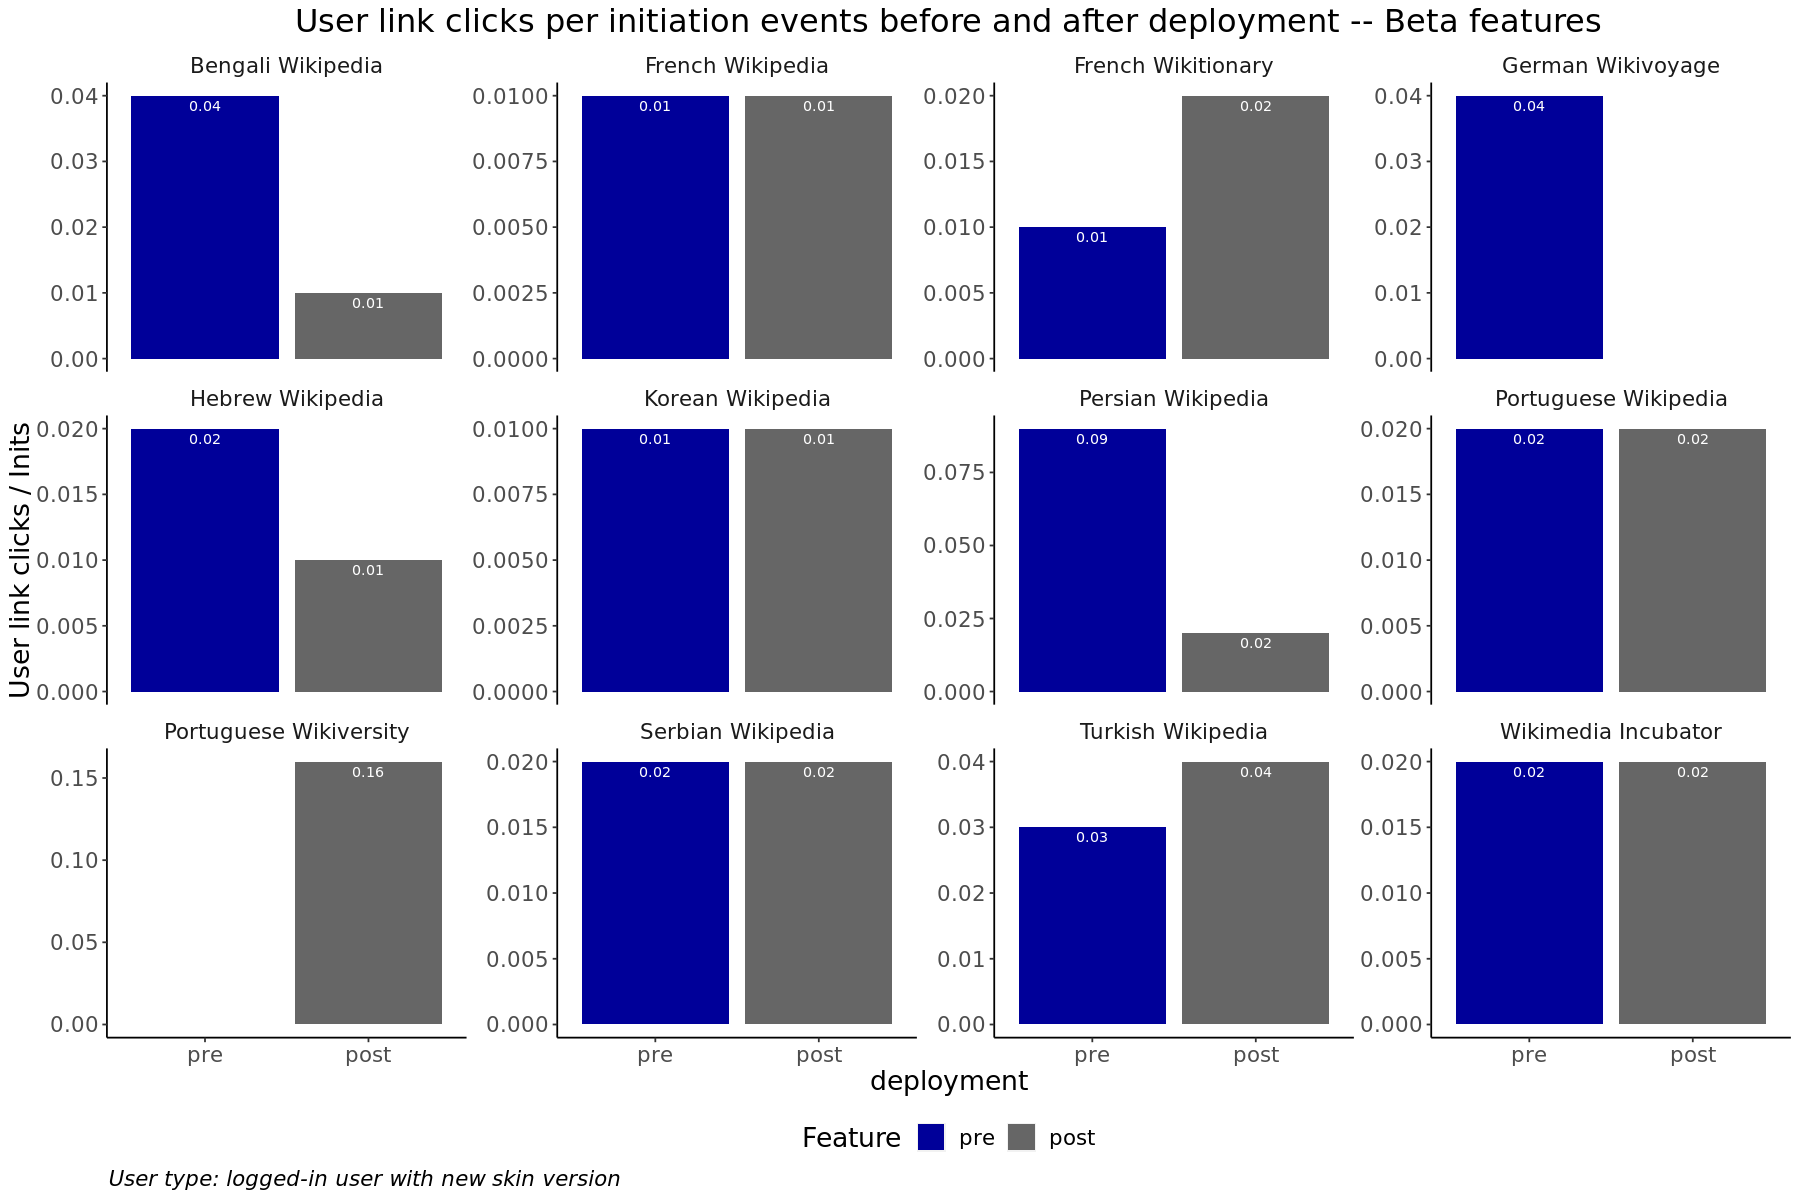

In [172]:
beta_clicks_barchart <- df_init_click_prepost %>%
        filter(name=='pt-betafeatures') %>%
        ggplot(aes(x = deployment, y= clicks_per_inits, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(clicks_per_inits)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "User link clicks / Inits",
             title = "User link clicks per initiation events before and after deployment -- Beta features",
             caption = "User type: logged-in user with new skin version ") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

beta_clicks_barchart



__Determin the percentage of changes__

In [173]:

# determine percent change

df_beta_clicks_prepost_w <- df_init_click_prepost %>%
  filter(name=='pt-betafeatures') %>%
  select(wiki_name, deployment,clicks_per_inits) %>%
  pivot_wider(names_from = deployment, values_from = clicks_per_inits) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

df_beta_clicks_prepost_w

wiki_name              post pre  pct_change
1  Bengali Wikipedia      0.01 0.04 -75.00    
2  German Wikivoyage        NA 0.04     NA    
3  Persian Wikipedia      0.02 0.09 -77.78    
4  French Wikipedia       0.01 0.01   0.00    
5  French Wikitionary     0.02 0.01 100.00    
6  Hebrew Wikipedia       0.01 0.02 -50.00    
7  Wikimedia Incubator    0.02 0.02   0.00    
8  Korean Wikipedia       0.01 0.01   0.00    
9  Portuguese Wikipedia   0.02 0.02   0.00    
10 Portuguese Wikiversity 0.16   NA     NA    
11 Serbian Wikipedia      0.02 0.02   0.00    
12 Turkish Wikipedia      0.04 0.03  33.33

Warning message:
“Removed 1 rows containing missing values (geom_pointrange).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


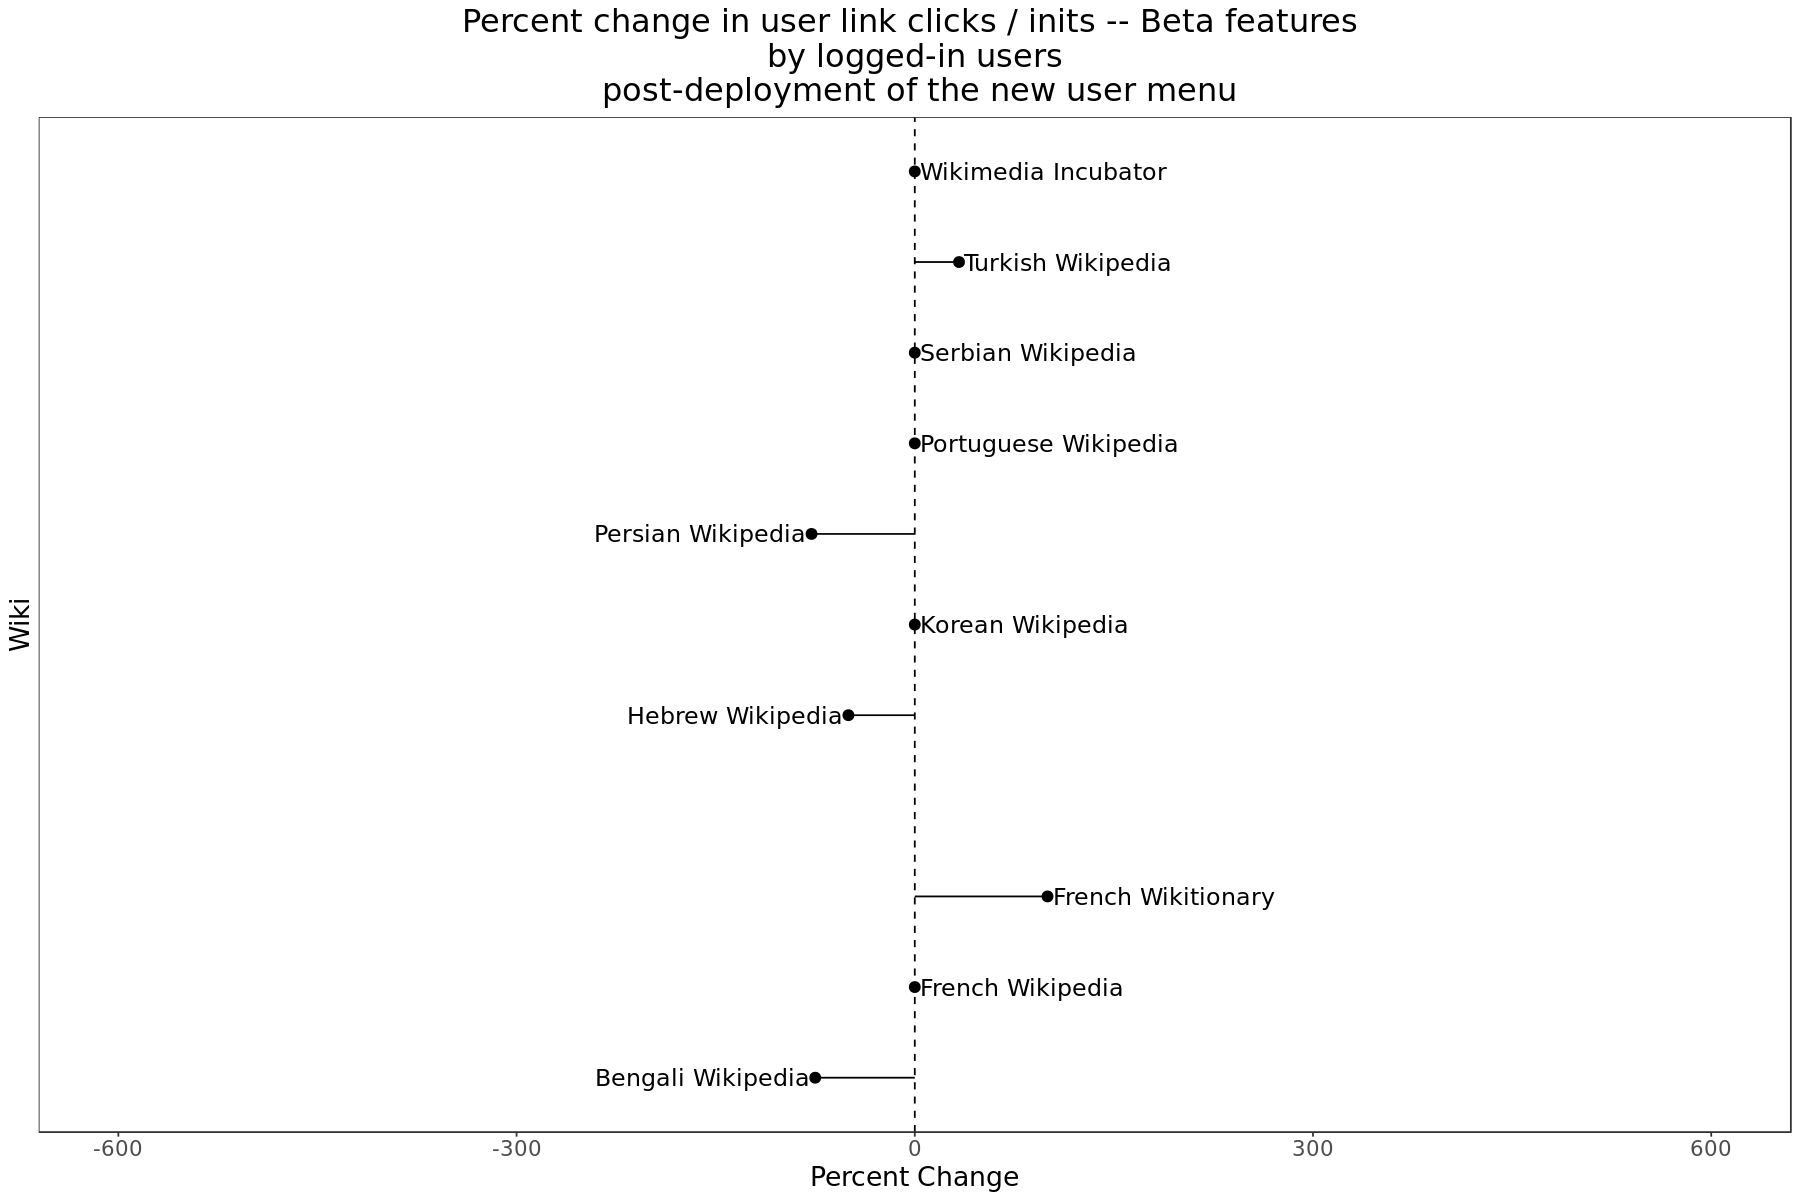

In [174]:
# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_beta_g <- df_beta_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in user link clicks / inits -- Beta features \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_beta_g 

__Average percent change__

Average of the percent changes observed on each early adopter wiki

In [175]:


mean((filter(df_beta_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] -6.945

## Contributions


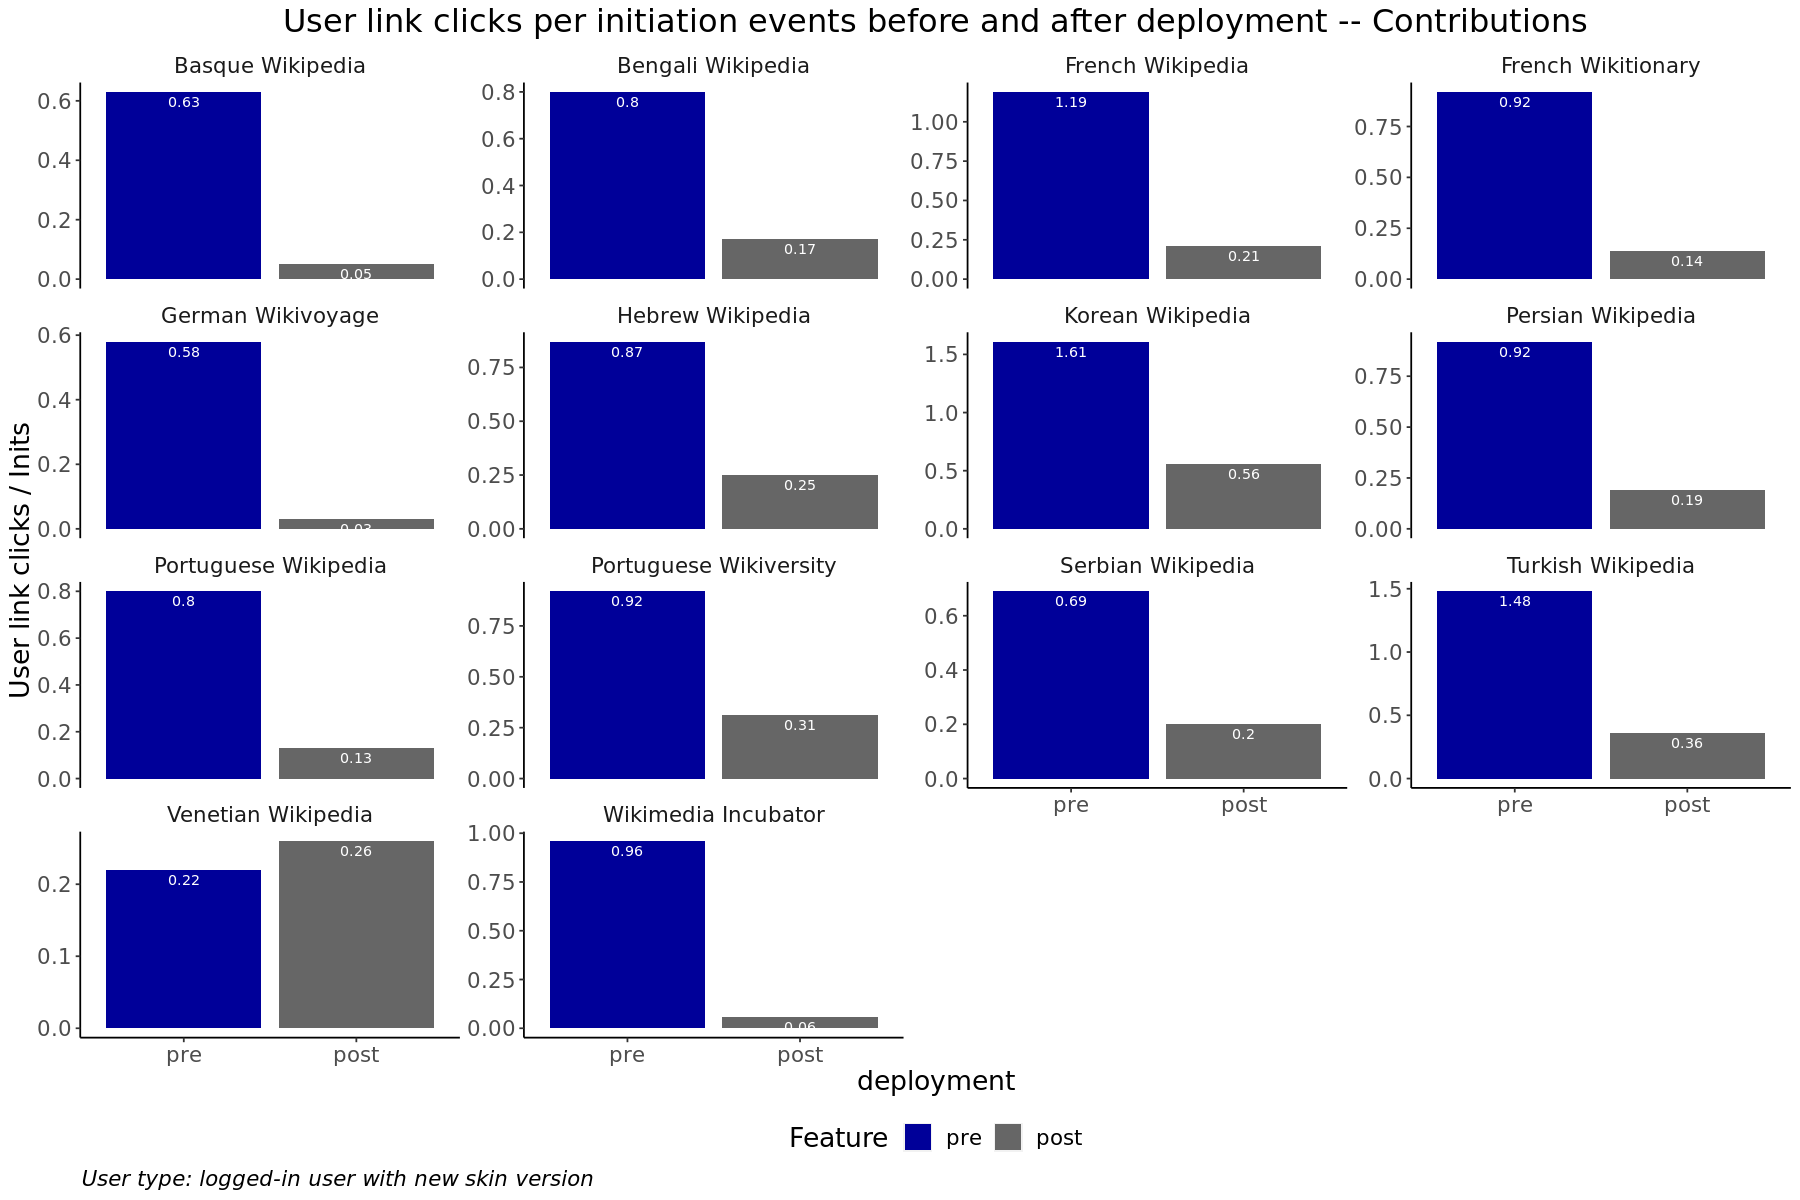

In [181]:
contris_clicks_barchart <- df_init_click_prepost %>%
        filter(name=='pt-mycontris') %>%
        ggplot(aes(x = deployment, y= clicks_per_inits, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(clicks_per_inits)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "User link clicks / Inits",
             title = "User link clicks per initiation events before and after deployment -- Contributions",
             caption = "User type: logged-in user with new skin version") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

contris_clicks_barchart



__Determin the percentage of changes__

In [178]:
# determine percent change

df_contris_clicks_prepost_w <- df_init_click_prepost %>%
  filter(name=='pt-mycontris') %>%
  select(wiki_name, deployment,clicks_per_inits) %>%
  pivot_wider(names_from = deployment, values_from = clicks_per_inits) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

df_contris_clicks_prepost_w

wiki_name              post pre  pct_change
1  Bengali Wikipedia      0.17 0.80 -78.75    
2  German Wikivoyage      0.03 0.58 -94.83    
3  Basque Wikipedia       0.05 0.63 -92.06    
4  Persian Wikipedia      0.19 0.92 -79.35    
5  French Wikipedia       0.21 1.19 -82.35    
6  French Wikitionary     0.14 0.92 -84.78    
7  Hebrew Wikipedia       0.25 0.87 -71.26    
8  Wikimedia Incubator    0.06 0.96 -93.75    
9  Korean Wikipedia       0.56 1.61 -65.22    
10 Portuguese Wikipedia   0.13 0.80 -83.75    
11 Portuguese Wikiversity 0.31 0.92 -66.30    
12 Serbian Wikipedia      0.20 0.69 -71.01    
13 Turkish Wikipedia      0.36 1.48 -75.68    
14 Venetian Wikipedia     0.26 0.22  18.18

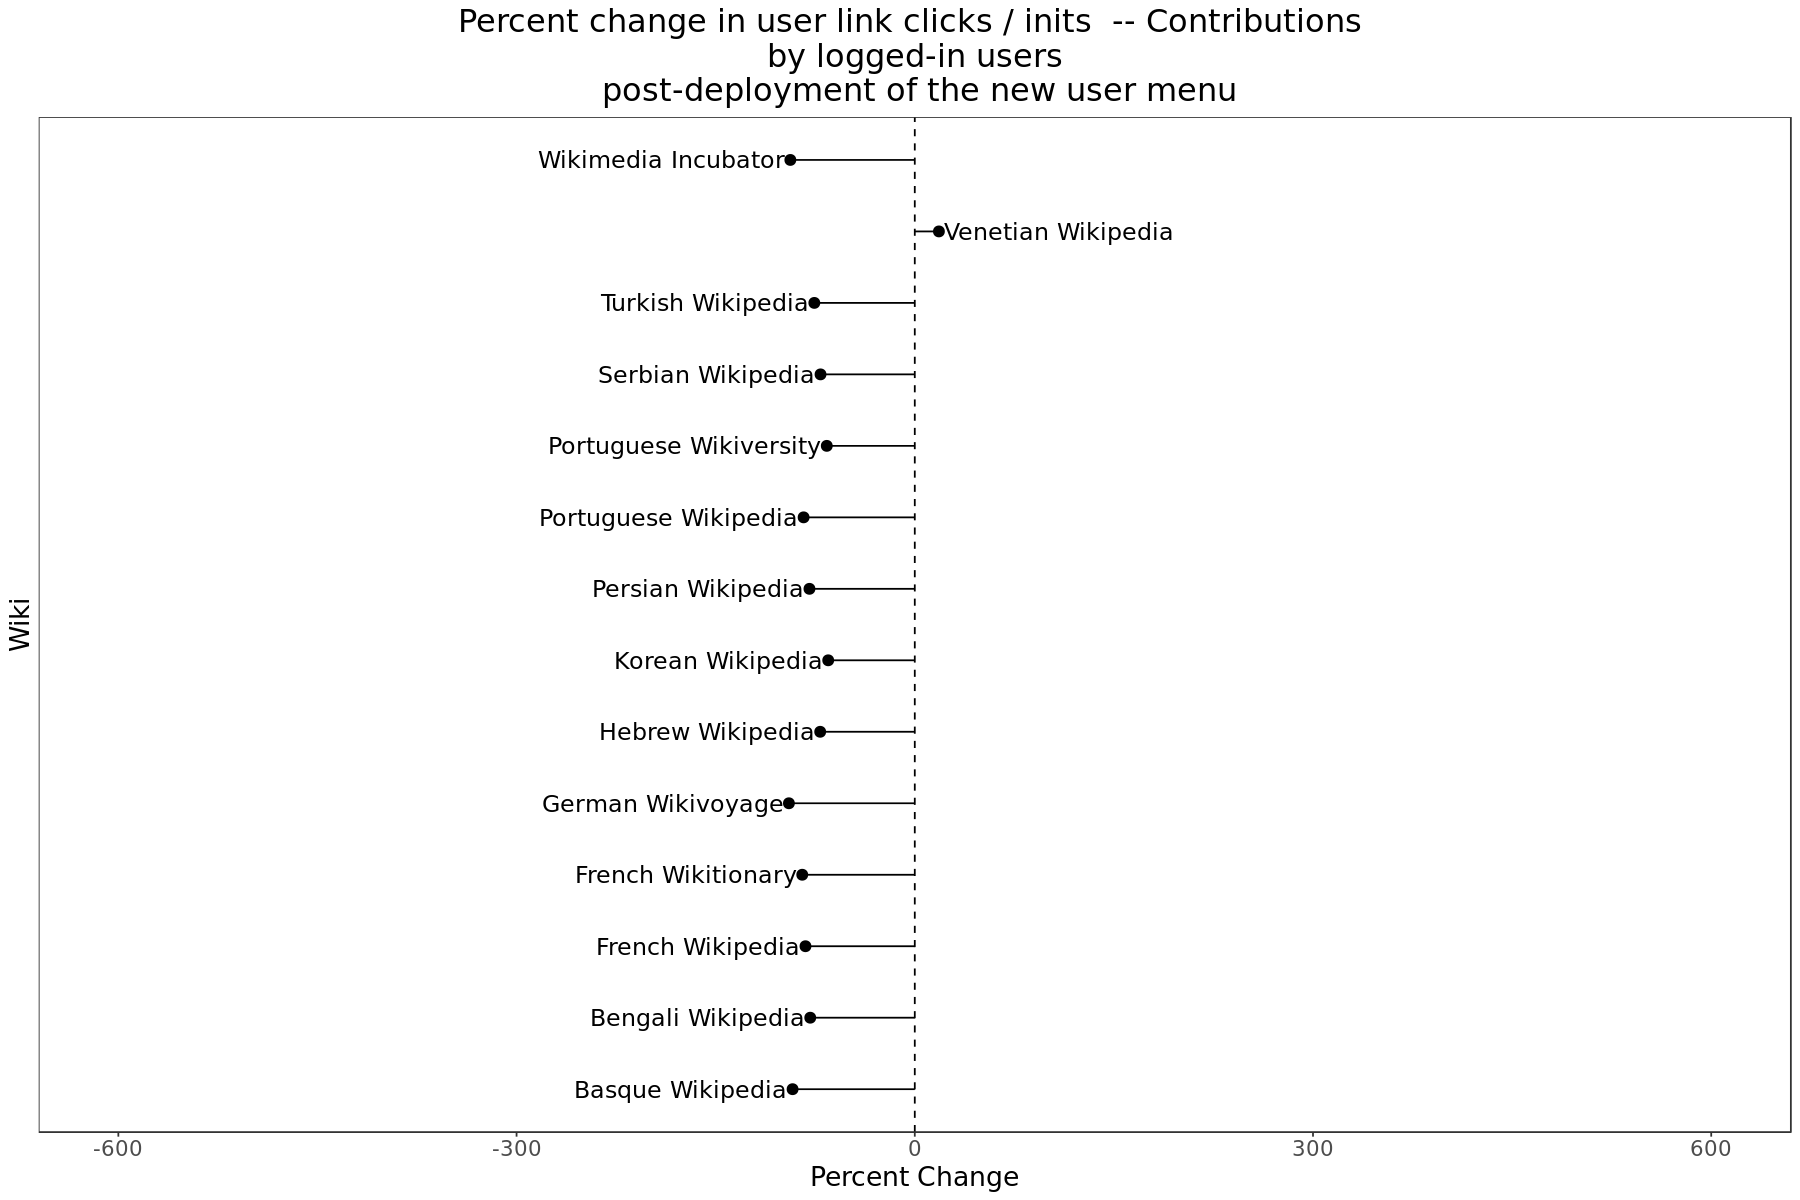

In [179]:

# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_contris_g <- df_contris_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in user link clicks / inits  -- Contributions \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_contris_g 







__Average percent change__

Average of the percent changes observed on each early adopter wiki


In [180]:

mean((filter(df_contris_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] -72.92214

## Log out

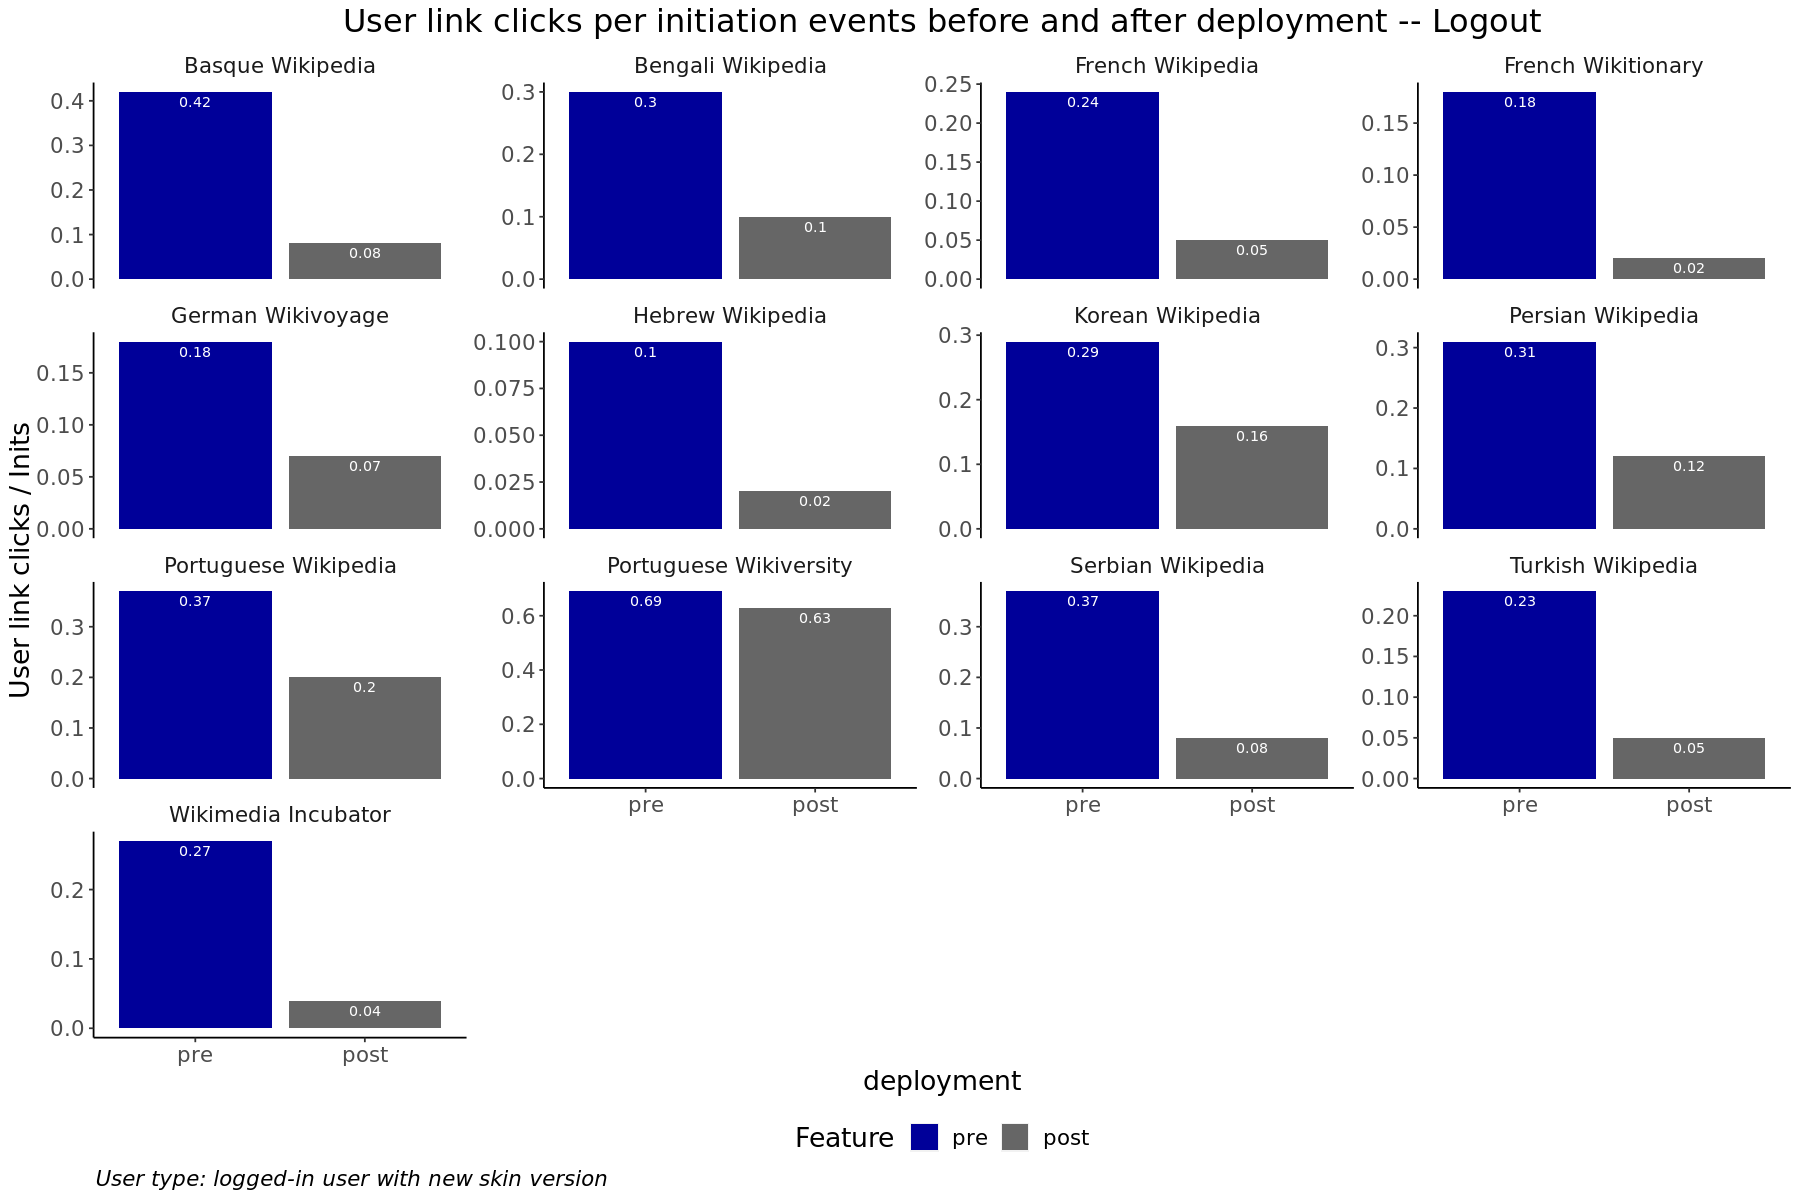

In [182]:
logout_clicks_barchart <- df_init_click_prepost %>%
        filter(name=='pt-logout') %>%
        ggplot(aes(x = deployment, y= clicks_per_inits, fill=deployment)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(clicks_per_inits)), color = "white", position = position_dodge(0.9), vjust = 1.5, size = 3) +
        facet_wrap(~wiki_name, scale = 'free_y') +
        labs (
              y = "User link clicks / Inits",
             title = "User link clicks per initiation events before and after deployment -- Logout",
             caption = "User type: logged-in user with new skin version") +
     scale_fill_manual(values= c( "#000099", "#666666"), name = "Feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

logout_clicks_barchart

__Determin the percentage of changes__

In [183]:
# determine percent change

df_logout_clicks_prepost_w <- df_init_click_prepost %>%
  filter(name=='pt-logout') %>%
  select(wiki_name, deployment,clicks_per_inits) %>%
  pivot_wider(names_from = deployment, values_from = clicks_per_inits) %>%
  mutate(pct_change=round((post-pre)/pre * 100 , 2))

df_logout_clicks_prepost_w

wiki_name              post pre  pct_change
1  Bengali Wikipedia      0.10 0.30 -66.67    
2  German Wikivoyage      0.07 0.18 -61.11    
3  Basque Wikipedia       0.08 0.42 -80.95    
4  Persian Wikipedia      0.12 0.31 -61.29    
5  French Wikipedia       0.05 0.24 -79.17    
6  French Wikitionary     0.02 0.18 -88.89    
7  Hebrew Wikipedia       0.02 0.10 -80.00    
8  Wikimedia Incubator    0.04 0.27 -85.19    
9  Korean Wikipedia       0.16 0.29 -44.83    
10 Portuguese Wikipedia   0.20 0.37 -45.95    
11 Portuguese Wikiversity 0.63 0.69  -8.70    
12 Serbian Wikipedia      0.08 0.37 -78.38    
13 Turkish Wikipedia      0.05 0.23 -78.26

Warning message:
“Removed 2 rows containing missing values (geom_pointrange).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”


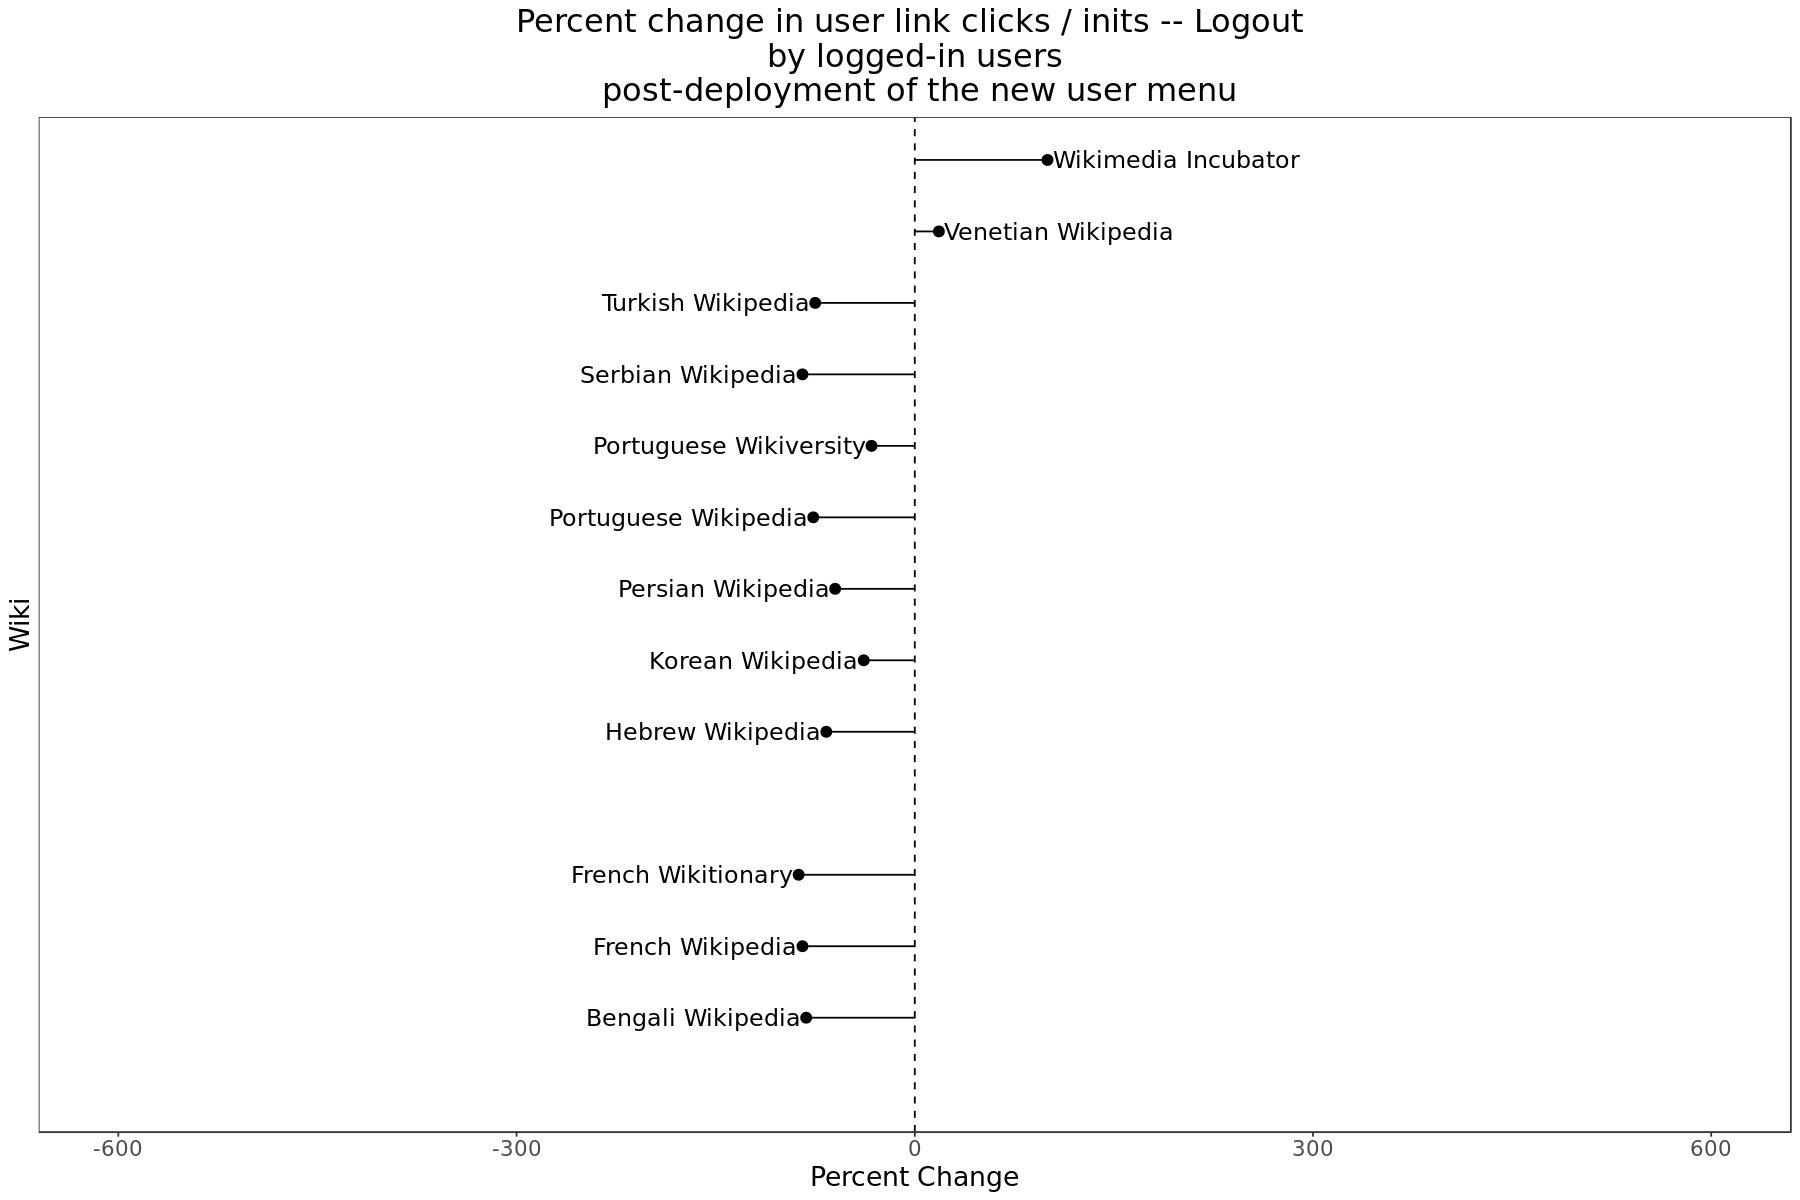

In [184]:






# chart percent change in logged-out sessions pre and post deployment for each of the early adopter wikis

pct_logout_g <- df_talk_clicks_prepost_w %>%
        filter( is.numeric(pct_change) & pre>0) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki_name, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki_name, label = wiki_name,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-600, 600)) +
         labs (x = "Wiki",
                y = "Percent Change",
             title = "Percent change in user link clicks / inits -- Logout \n by logged-in users \n post-deployment of the new user menu") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_logout_g 




__Average percent change__

Average of the percent changes observed on each early adopter wiki



In [185]:
mean((filter(df_logout_clicks_prepost_w, is.numeric(pct_change) & pre>0))$pct_change, na.rm=TRUE)

[1] -66.10692

__Summary__

- After deployed new user menu, clicks per initiation events by users with new skin decreased on all types of links. The changes varied between -47% ~ -84%. Some tools with low usage are excluded. The trend is smilar to what we see in the numbers of clicks on user links.
- It's expected that the clicks will drop after the deployment. 
- Need to confirm with PM and engineer on whether a 47%~84% decrease is within the expected range.

# Pattern by edit buckets

In [60]:
query_user_link_clicks_2 <- 
"
SELECT TO_DATE(dt) AS event_date, 
    wiki, 
    event.name, 
    event.editCountBucket, 
    COUNT(1) AS clicks 
FROM event_sanitized.desktopwebuiactionstracking 
WHERE year=2021 and month >=7
AND event.action='click' 
-- only users with new skin version will see the new user menu
AND event.skinversion=2
-- only logged-in user
AND NOT event.isAnon 
AND event.name IN ('pt-watchlist' , 'pt-mytalk', 
'pt-sandbox', 'pt-preferences', 'pt-betafeatures', 'pt-mycontris', 'pt-logout') 
AND wiki IN ('frwiktionary' , 'hewiki' ,'ptwikiversity' ,'frwiki', 'euwiki' ,
         'fawiki' ,'ptwiki' , 'kowiki' , 'trwiki' , 'srwiki' , 'bnwiki' , 'dewikivoyage' ,
         'vecwiki' , 'incubatorwiki' )
GROUP BY  TO_DATE(dt) , wiki, event.name, event.editCountBucket
"

In [61]:
df_user_link_clicks_editbuckets  <-  wmfdata::query_hive(query_user_link_clicks_2 )

Don't forget to authenticate with Kerberos using kinit



In [ ]:
df_user_link_clicks_editbuckets$event_date <- as.Date(df_user_link_clicks_editbuckets$event_date)

In [200]:
query_init_events_editbuckets <- 
"
SELECT TO_DATE(dt) AS event_date, 
    event.editCountBucket,
    COUNT(1) AS init_events 
FROM event_sanitized.desktopwebuiactionstracking 
WHERE year=2021 and month >=7
AND event.action='init' AND NOT event.isAnon
-- only users with new skin version will see the new user menu
AND event.skinversion=2
AND wiki IN ('frwiktionary' , 'hewiki' ,'ptwikiversity' ,'frwiki', 'euwiki' ,
         'fawiki' ,'ptwiki' , 'kowiki' , 'trwiki' , 'srwiki' , 'bnwiki' , 'dewikivoyage' ,
         'vecwiki' , 'incubatorwiki' )
GROUP BY  TO_DATE(dt) ,  event.editCountBucket
"


In [201]:
df_init_events_eb <-  wmfdata::query_hive(query_init_events_editbuckets)

Don't forget to authenticate with Kerberos using kinit



In [202]:
df_init_events_eb$event_date <- as.Date(df_init_events_eb$event_date)

In [206]:
df_clicks_inits_eb <- df_user_link_clicks_editbuckets   %>%
    group_by(editcountbucket, event_date) %>%
    summarize(user_link_clicks=sum(clicks, na.rm=TRUE), .groups='drop') %>%
    right_join(df_init_events_eb, by=c('event_date','editcountbucket') ) %>%
    mutate(clicks_per_inits=round((user_link_clicks/init_events)* 100 , 2))

In [209]:
tail(df_clicks_inits_eb)

editcountbucket event_date user_link_clicks init_events clicks_per_inits
1 5-99 edits      2021-12-26 188              41079       0.46            
2 5-99 edits      2021-12-27 189              43279       0.44            
3 5-99 edits      2021-12-28 196              46790       0.42            
4 5-99 edits      2021-12-29 201              45030       0.45            
5 5-99 edits      2021-12-30 169              45428       0.37            
6 5-99 edits      2021-12-31 142              37913       0.37

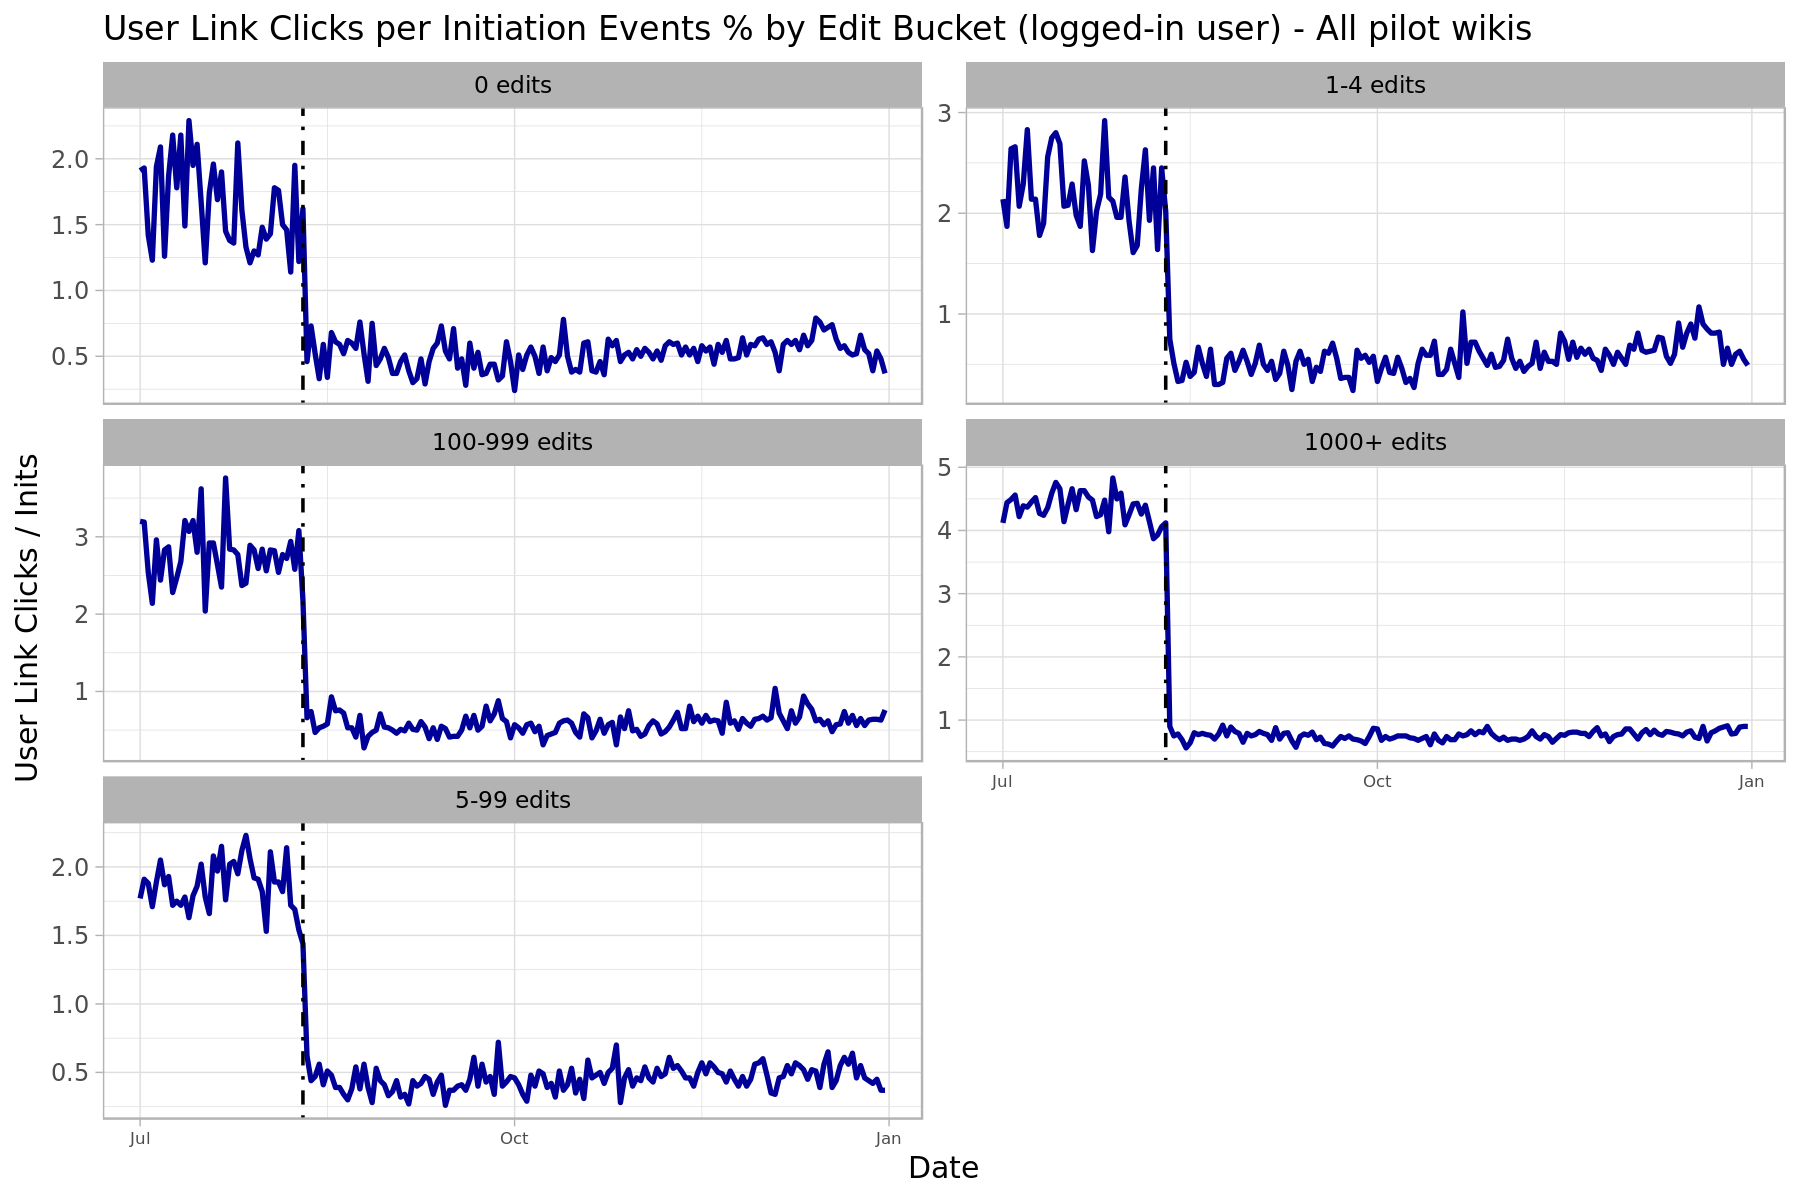

In [208]:
click_eb_g <- ggplot(data=df_clicks_inits_eb , mapping=aes(x=event_date)) +
geom_line(aes(y=clicks_per_inits ), color="#000099" , size = 1.5) +
geom_vline(aes(xintercept = as.numeric(as.Date('2021-08-10'))), linetype="dotdash", color="black", size=1)+
facet_wrap(~editcountbucket ,nrow=4,scale = 'free_y')+
labs(title = 'User Link Clicks per Initiation Events % by Edit Bucket (logged-in user) - All pilot wikis ',
     x = 'Date',
     y = 'User Link Clicks / Inits ') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20))
click_eb_g 

__Summary__:

- The user link clicks per inits dropped since the user menu was deployed. The pattern is consistent across edits bucket groups. It is smilar to what we see in the number of user link clicks by edit buckets.
- 1000+ edits groups have higher click through rate. Experienced users used this feature more often.
